# Análisis de las bioseñales EMG y ROM de sujetos de edad avanzada
### Daniel Anchuela Cantarero - d.anchuela@usp.ceu.es






### Importar paquetes


In [ ]:
#Import Packages
import glob
import pandas as pd
import numpy as np
from scipy import signal
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, RationalQuadratic as RQ, WhiteKernel, ExpSineSquared as Exp, DotProduct as Lin
from sklearn import preprocessing
import scipy.integrate as integrate
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets, linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
import sys
print(sys.version)

## Leer y almacenar datos en memoria

<div style="text-align: justify"> 

<br>Leemos todos los EMG almacenados en la carpeta. Los nombres de los archivos siguen esta regla: nombrePaciente_velocidad_peso (Antonio_jose_collado_alta00) 
- Estos EMG son los filtrados por Mdurance
</div>





In [ ]:
# especificando la ruta a los archivos csv
path= "./EMG"  
# archivos csv en la ruta
files = glob.glob(path + "/*.csv")
  
# definir una lista vacía para almacenar el contenido
data_frame = pd.DataFrame()
content = []
  
diccionario={}
#creamos un diccionario para almacenar un dataset para cada nombre de archivo

# comprobando todos los archivos csv en la ruta especificada

for filename in files:
# las claves del diccionario son el nombre de los archivos quitando el resto de la ruta y el valor es el conjunto de datos en sí
    #Ejemplo: list(diccionario.keys())[0] = Antonio_jose_collado_alta00
    diccionario[filename[(len(path)+1):len(filename)-4]]=pd.read_csv(filename, index_col=None,on_bad_lines='skip',delimiter=";", decimal=",")
  
print(diccionario.keys())

### Trazado de señales EMG

<div style="text-align: justify"> 

<br>
    Para todas las entradas del diccionario, pintamos el valor relativo a esa key. Es decir, pintamos los datos pertenecientes a ese paciente.
    Nos fijamos como los datos de cada músculo están almacenados en las columnas 7,8,9 y 10 del dataset.
    Con la librería de Pandas seleccionamos columnas con la función iloc.

</div>

In [ ]:
def ajustar_outliers(datos):
    Q1 = np.percentile(datos, 25)
    Q3 = np.percentile(datos, 75)
    IQR = Q3 - Q1

    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    # Ajustar outliers
    datos_ajustados = np.where(datos < limite_inferior, limite_inferior, datos)
    datos_ajustados = np.where(datos_ajustados > limite_superior, limite_superior, datos_ajustados)

    return datos_ajustados

In [ ]:
import pandas as pd

def limpiar_outlayers_yplotear(lista):
    colores = ['blue', 'green', 'red', 'purple']  # Colores para cada músculo

    for key in lista:
        dataset = diccionario.get(key)

        # Extraer los datos
        rms_gemelo_interno_derecho = ajustar_outliers(dataset.iloc[:, 7].values)
        rms_tibial_anterior_derecho = ajustar_outliers(dataset.iloc[:, 8].values)
        rms_gemelo_interno_izquierdo = ajustar_outliers(dataset.iloc[:, 9].values)
        rms_tibial_anterior_izquierdo = ajustar_outliers(dataset.iloc[:, 10].values)
        eje_x = dataset.iloc[:, 6].values

        # Actualizar el DataFrame en el diccionario
        nuevas_columnas = dataset.columns
        datos_ajustados = np.column_stack((dataset.iloc[:, :7], rms_gemelo_interno_derecho, rms_tibial_anterior_derecho, rms_gemelo_interno_izquierdo, rms_tibial_anterior_izquierdo))
        diccionario[key] = pd.DataFrame(datos_ajustados, columns=nuevas_columnas)

        # Gráfico de líneas
        plt.figure(figsize=(10, 5))
        plt.plot(eje_x, rms_gemelo_interno_derecho, label="rms_gemelo_interno_derecho", color=colores[0])
        plt.plot(eje_x, rms_tibial_anterior_derecho, label="rms_tibial_anterior_derecho", color=colores[1])
        plt.plot(eje_x, rms_gemelo_interno_izquierdo, label="rms_gemelo_interno_izquierdo", color=colores[2])
        plt.plot(eje_x, rms_tibial_anterior_izquierdo, label="rms_tibial_anterior_izquierdo", color=colores[3])
        plt.title(key)
        plt.legend()
        plt.show()

        # Gráfico de boxplots
        plt.figure(figsize=(10, 5))
        data_to_plot = [rms_gemelo_interno_derecho, rms_tibial_anterior_derecho, rms_gemelo_interno_izquierdo, rms_tibial_anterior_izquierdo]
        box = plt.boxplot(data_to_plot, patch_artist=True)
        
        # Colorear cada boxplot
        for patch, color in zip(box['boxes'], colores):
            patch.set_facecolor(color)

        plt.title(f"Boxplot - {key}")
        plt.xticks([1, 2, 3, 4], ["RMS Gemelo Interno Derecho", "RMS Tibial Anterior Derecho", "RMS Gemelo Interno Izquierdo", "RMS Tibial Anterior Izquierdo"])
        plt.show()

limpiar_outlayers_yplotear(diccionario.keys())


### Plotting EMG upsampled

<div style="text-align: justify"> 

<br>
También puede ser interesante pintar la time response. Lo utilizaremos más adelante al comparar ROM y EMG. Además vamos a añadir un factor de resampling para que la señal tenga más muestras y se vea mejor.
    

</div>

In [ ]:
def imprimir_emg_Izq_time(lista,col,upsampling_factor=10):

    for key in lista:
        dataset=diccionario.get(key)
      
#min2+x>max1    x>max1-min2
    
    
        rms_gemelo_interno_izquierdo=dataset.iloc[:,9].values
        rms_gemelo_interno_izquierdo=signal.resample(rms_gemelo_interno_izquierdo,int(len(rms_gemelo_interno_izquierdo)*upsampling_factor))
        
        plt.plot(np.arange(0,len(rms_gemelo_interno_izquierdo)/(fsEMG*upsampling_factor),1/(fsEMG*upsampling_factor)),rms_gemelo_interno_izquierdo+10, label="rms_gemelo_interno_izquierdo")
    
        
        rms_tibial_anterior_izquierdo=dataset.iloc[:,10].values
        rms_tibial_anterior_izquierdo=signal.resample(rms_tibial_anterior_izquierdo,int(len(rms_tibial_anterior_izquierdo)*upsampling_factor))

        plt.plot(np.arange(0,len(rms_tibial_anterior_izquierdo)/(fsEMG*upsampling_factor),1/(fsEMG*upsampling_factor)),rms_tibial_anterior_izquierdo+max(rms_gemelo_interno_izquierdo)+10, label="rms_tibial_anterior_izquierdo")
        
        plt.title(key+" "+col)
        plt.legend()
        
        
def imprimir_emg_Der_time(lista,col,upsampling_factor=10):

     for key in lista:
         dataset=diccionario.get(key)
         rms_gemelo_interno_derecho=dataset.iloc[:,7].values
         rms_gemelo_interno_derecho=signal.resample(rms_gemelo_interno_derecho,int(len(rms_gemelo_interno_derecho)*upsampling_factor))

        

         
         plt.plot(np.arange(0,len(rms_gemelo_interno_derecho)/(fsEMG*upsampling_factor),1/(fsEMG*upsampling_factor)),rms_gemelo_interno_derecho+10, label="rms_gemelo_interno_derecho")
         
         rms_tibial_anterior_derecho=dataset.iloc[:,8].values
        
         rms_tibial_anterior_derecho=signal.resample(rms_tibial_anterior_derecho,int(len(rms_tibial_anterior_derecho)*upsampling_factor))

         plt.plot(np.arange(0,len(rms_tibial_anterior_derecho)/(fsEMG*upsampling_factor),1/(fsEMG*upsampling_factor)),rms_tibial_anterior_derecho+max(rms_gemelo_interno_derecho)+10, label="rms_tibial_anterior_derecho")
     
         
         plt.title(key+" "+col)
         plt.legend()
         
#imprimir_emg_Der_time(diccionario.keys(),"a")
#imprimir_emg_Izq_time(diccionario.keys(),"a")

### Estimación rudimentaria de dónde hay contracciones

<div style="text-align: justify"> 

<br>
    - Para estudiar el EMG de los sujetos, lo primero va a ser extraer las contracciones de los músculos. 
    Una forma muy simple de hacer esto podría ser simplemente detectar en qué momentos la señal está por encima de un cierto umbral, como por ejemplo la media de la propia señal.
    <br><br>
    - Esta es una forma muy rudimentaria, pero nos permite hacer una primera aproximación para saber en qué momentos existe contracción o no. Este método no es eficaz con señales que presentan ruido de baja frecuencia o que presentan mucho ruido de alta frecuencia.
    <br><br>
    - Este método es solo para saber aproximadamente dónde hay o no contracciones. No para saber la magnitud.

</div>

In [ ]:
def sacar_contracciones(lista):
   diccionario_contracciones={}

   for key in lista:
       dataset=diccionario.get(key)
       dataset_binario=pd.DataFrame()
       for i in np.arange(7,11):
           array_binario=(dataset.iloc[:,i].values>np.mean(dataset.iloc[:,i].values))
           array_binario = np.multiply(array_binario, 1)
           dataset_binario[dataset.columns.values[i]]=array_binario
           
           
       
       diccionario_contracciones[key]=dataset_binario
   return (diccionario_contracciones)

diccionario_contracciones=sacar_contracciones( diccionario.keys())

def imprimir_todo_binario(lista):

    for key in lista:
        
        dataset_binario=diccionario_contracciones.get(key)
        plt.plot(np.arange(len(dataset_binario.iloc[:,3])),dataset_binario.iloc[:,3]+6,label=dataset_binario.columns.values[3])
        plt.plot(diccionario.get(key).iloc[:,10]/max(diccionario.get(key).iloc[:,10])+6)

        plt.plot(np.arange(len(dataset_binario.iloc[:,2])),dataset_binario.iloc[:,2]+5,label=dataset_binario.columns.values[2])
        plt.plot(diccionario.get(key).iloc[:,9]/max(diccionario.get(key).iloc[:,9])+5)

        plt.plot(np.arange(len(dataset_binario.iloc[:,1])),dataset_binario.iloc[:,1]+1,label=dataset_binario.columns.values[1])
        plt.plot(diccionario.get(key).iloc[:,8]/max(diccionario.get(key).iloc[:,8])+1)

        plt.plot(np.arange(len(dataset_binario.iloc[:,0])),dataset_binario.iloc[:,0],label=dataset_binario.columns.values[0])
        plt.plot(diccionario.get(key).iloc[:,7]/max(diccionario.get(key).iloc[:,7]))
       
        
        plt.title(key)
        plt.legend()
        plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
        plt.figure()
imprimir_todo_binario(diccionario_contracciones.keys())  


### Leemos y pintamos el ROM
La explicación es la misma que en el caso del EMG



In [ ]:
#laFS del ROM se ha sacado de coger un archivo y dividir las muestras totales entre el tiempo total
fsROM=484/(42085/1000)#celestina_garcia_baja_25
print(fsROM)

diccionarioRom={}

# especificando la ruta a los archivos csv
pathROM= "./ROM"  
diccionarioRom={}
# archivos csv en la ruta
filesROM = glob.glob(pathROM + "/*.xlsx")
data_frame = pd.DataFrame()


for filename in filesROM:
    #la clave del diccionario es el nombre del archivo sin toda la ruta y el resultado es el propio dataset
    diccionarioRom[filename[(len(pathROM)+1):(len(filename)-5)]]=pd.read_excel(filename)


In [ ]:
#normalizar rom

def normalizarDatos(dataset):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    return scaler.fit_transform(dataset.values.reshape(-1, 1)).flatten()

def normalizarTodosLosRoms(diccionarioRom):
    for key in diccionarioRom:
        datasetRom = diccionarioRom[key]

        # Normalizar cada columna de interés
        datasetRom.iloc[:,3] = normalizarDatos(datasetRom.iloc[:,3])
        datasetRom.iloc[:,4] = normalizarDatos(datasetRom.iloc[:,4])

        # Guardar el dataset normalizado en el diccionario
        diccionarioRom[key] = datasetRom

# Llama a la función con tu diccionario de ROMs
#normalizarTodosLosRoms(diccionarioRom)

In [ ]:
def imprimirRom(listaKeys):
    for key in listaKeys:
        plt.figure(figsize=(16, 4))
        datasetRom=diccionarioRom.get(key)
        left_hip_real=datasetRom.iloc[:,3].values
        right_hip_real=datasetRom.iloc[:,4].values
        weight_gauge=datasetRom.iloc[:,5].values

        plt.plot(np.arange(len(left_hip_real)),left_hip_real, label="left_hip_real" ,c="blue")
        plt.plot(np.arange(len(right_hip_real)),right_hip_real+4, label="right_hip_real", c="green")
        plt.legend()
        

        plt.title(key)
        plt.figure()

imprimirRom(diccionarioRom.keys())

In [ ]:
import scipy.signal as sig
def define_ma(L):
    return np.repeat(1. / (2 * L + 1), 2 * L + 1)


In [ ]:


diccionarioRomInterpolado = {}
factorinterpolacion=10
frecuenciarominterpolada=fsROM*factorinterpolacion
def define_ma(L):
    return np.repeat(1. / (2 * L + 1), 2 * L + 1)
def apply_highpass_filter(data, cutoff_freq=0.1):
    # Diseñar el filtro paso alto
    b, a = butter(N=4, Wn=cutoff_freq / (frecuenciarominterpolada/2), btype='high', analog=False)
    filtered_data = filtfilt(b, a, data)
    #filtered_data = data
    return filtered_data

def limpiar_inicio(senal1,senal2,amplitud_percentil1=30,amplitud_percentil2=70,porcentaje_x=20):
    percentil1senal1=np.percentile(senal1[int(len(senal1)*(porcentaje_x/100)):],amplitud_percentil1)
    percentil2senal1=np.percentile(senal1[int(len(senal1)*(porcentaje_x/100)):],amplitud_percentil2)
    percentil1senal2=np.percentile(senal2[int(len(senal2)*(porcentaje_x/100)):],amplitud_percentil1)
    percentil2senal2=np.percentile(senal2[int(len(senal2)*(porcentaje_x/100)):],amplitud_percentil2)
    
    for i in np.arange(int(len(senal1)*0.8)):
       
        if senal1[0]>percentil1senal1 and senal1[0]<percentil2senal1 and senal2[0]>percentil1senal2 and senal2[0]<percentil2senal2:
            senal1 = senal1[1:]
            senal2 = senal2[1:]
            

        else:
            break
    return senal1,senal2


def corregir_centrado_en_0 (señal):
    # Calcula el rango de la señal
    rango = abs(max(señal) - min(señal))
    print(rango)
    # Calcula el 25% del rango
    ajuste = 0.25 * rango
    
    # Devuelve la señal corregida sumando el 25% del rango a cada punto de la señal
    return [x + ajuste for x in señal]

def imprimirRomInterpolado(listaKeys ):
    
    for key in listaKeys:
        #plt.figure(figsize=(16, 4))
        
        try:
            datasetRom = diccionarioRom.get(key)
            x = np.arange(len(datasetRom))
            x_interp = np.linspace(0, len(datasetRom) - 1, len(datasetRom) * factorinterpolacion)
    
            left_hip_real = datasetRom.iloc[:, 3].values
            right_hip_real = datasetRom.iloc[:, 4].values
            weight_gauge = datasetRom.iloc[:, 5].values
    
            
            #aplicar mooving average
            L = 10
            b = define_ma(L)
            
            # Crear funciones de interpolación lineal
            left_hip_interp = interp1d(x, left_hip_real, kind='cubic')
            right_hip_interp = interp1d(x, right_hip_real, kind='cubic')
            weight_gauge_interp = interp1d(x, weight_gauge, kind='cubic')
    
            columns = ['Columna1', 'Columna2', 'Columna3', 'Columna4', 'Columna5']
    
            df = pd.DataFrame(columns=columns)
            
            filt3 =  apply_highpass_filter(left_hip_interp(x_interp))
            filt4= apply_highpass_filter(right_hip_interp(x_interp))
            filt5  = apply_highpass_filter(weight_gauge_interp(x_interp))
            """
            filt3 = left_hip_interp(x_interp)
            filt4= right_hip_interp(x_interp)
            filt5  = weight_gauge_interp(x_interp)
            """
            
            filt3 = sig.filtfilt(b, 1, filt3)
            filt4 = sig.filtfilt(b, 1, filt4)
            
            
            #limpiar_inicio señal
            filt3,filt4 = limpiar_inicio(filt3,filt4)
            
            
            #filt3=filt3[int(0.3*frecuenciarominterpolada):]
            #filt4=filt4[int(0.3*frecuenciarominterpolada):]
            
            filt3=corregir_centrado_en_0(filt3)
            filt4=corregir_centrado_en_0(filt4)
            filt5=corregir_centrado_en_0(filt5)
            
            min_length = min(len(filt3), len(filt4), len(filt5))
            df['Columna3'] = filt3[:min_length]
            df['Columna4'] = filt4[:min_length]
            df['Columna5'] = filt5[:min_length]
            
            diccionarioRomInterpolado[key] = df
    
           # plt.plot(np.arange(min_length), df['Columna3'], label="left_hip_real", c="blue")
            ##plt.plot(np.arange(min_length), df['Columna4'] + 20, label="right_hip_real", c="green")
            #plt.plot(np.arange(min_length), df['Columna5'] + 35, label="weight_gauge", c="red")
           # plt.legend()
    
           # plt.title(key)
           # plt.show()
        except:
            print(key)
# Llamada a la función con el factor de muestreo y frecuencia de corte especificados
imprimirRomInterpolado(diccionarioRom.keys())


In [ ]:
for key in diccionarioRomInterpolado.keys():
    plt.figure(figsize=(16, 4))
    plt.plot(np.arange(len(diccionarioRom[key].iloc[:,4]))/(484/(42085/1000)),diccionarioRom[key].iloc[:,4],label="OR-DER")
    plt.plot(np.arange(len(diccionarioRomInterpolado[key].iloc[:,3]))/frecuenciarominterpolada,diccionarioRomInterpolado[key].iloc[:,3],label="FIL-DER")
    plt.figure(figsize=(16, 4))

    plt.plot(np.arange(len(diccionarioRom[key].iloc[:,3]))/(484/(42085/1000)),diccionarioRom[key].iloc[:,3],label="OR-IZQ")

    plt.plot(np.arange(len(diccionarioRomInterpolado[key].iloc[:,2]))/frecuenciarominterpolada,diccionarioRomInterpolado[key].iloc[:,2],label="FIL-IZQ")
    plt.legend()
    plt.title(key)
    


In [ ]:
for key in diccionarioRomInterpolado.keys():
    plt.figure(figsize=(16, 4))
    plt.plot(np.arange(len(diccionarioRomInterpolado[key].iloc[:,3]))/frecuenciarominterpolada,diccionarioRomInterpolado[key].iloc[:,3],label="FIL-DER")


    plt.plot(np.arange(len(diccionarioRomInterpolado[key].iloc[:,2]))/frecuenciarominterpolada,diccionarioRomInterpolado[key].iloc[:,2],label="FIL-IZQ")
    plt.legend()
    plt.title(key)
    

In [ ]:
#esta bien hacer los filtros porque hay que centrar en 0. aunque la amplitud del rom sea mas pequeña es la correcta
#ademas para el ancho del paso por ejemplo hay que tomar la amplitud como lo que mide la fase swing de media y no los picos maximos de la señal


maximosinterpolados={}
maximosnomales={}

for key in diccionarioRomInterpolado.keys():
    
    
    maximosinterpolados[key+"izq"]=np.max(diccionarioRomInterpolado[key].iloc[:,2])
    
    maximosnomales[key+"izq"]=np.max(diccionarioRom[key].iloc[:,3])
    
    
    maximosinterpolados[key+"der"]=np.max(diccionarioRomInterpolado[key].iloc[:,3])
    maximosnomales[key+"der"]=np.max(diccionarioRom[key].iloc[:,4])
# Crear listas de claves y valores para ambos diccionarios
print(diccionarioRomInterpolado)
print(diccionarioRom)



claves = list(maximosinterpolados.keys())
print(claves)

valores_interpolados = list(maximosinterpolados.values())
valores_nomales = list(maximosnomales.values())

# Configurar el ancho de las barras
ancho_barra = 0.35

# Configurar la posición de las barras en el eje x
posiciones = range(len(claves))

# Crear el barplot
fig, ax = plt.subplots(figsize=[50, 20])
barra_interpolada = ax.bar(posiciones, valores_interpolados, ancho_barra, label='Interpolados')
barra_nomales = ax.bar([pos + ancho_barra for pos in posiciones], valores_nomales, ancho_barra, label='No interpolados')

# Configurar etiquetas y título
ax.set_xlabel('Claves')
ax.set_ylabel('Valores máximos')
ax.set_title('Comparación de máximos interpolados y no interpolados por clave')
ax.set_xticks([pos + ancho_barra / 2 for pos in posiciones])
ax.set_xticklabels(claves, rotation=90)  # Rotar las etiquetas a 90 grados
ax.legend()

# Mostrar el gráfico
plt.show()


### Fases de la marcha
- Para muchos de los estudios en los que se utiliza el ROM es necesario separar entre las distintas fases de la marcha. 
- Las fases de la marcha se pueden dividir en más o menos etapas. En este caso vamos a dividir entre fase Stance y fase Swing.
	- La fase de Swing se refiere al momento en que el pie está levantado del suelo y se mueve hacia adelante en preparación para el siguiente paso. 
    - La fase de Stance es cuando el pie se mueve hacia atrás mientras está en contacto con el suelo.
    
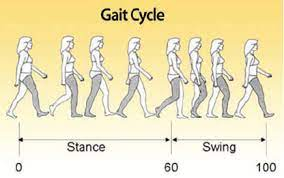


- Esto lo podemos ver en la señal del ROM, ya que cuando el ángulo es mínimo estamos al inicio de la fase Swing, ya que el pie está en la parte de atrás. Por otra parte, cuando en el ROM se vea un ángulo máximo, el pie está en su posición máxima hacia adelante, es decir al final de la fase Swing e inicio de la fase Stance.

#### Para sacar las fases de la marcha
Entonces, para sacar las fases de la marcha nos vamos a quedar con todos aquellos valores de la señal que vayan de un mínimo a un máximo y se los vamos a asignar a la fase swing mientras que los puntos que vayan de un máximo a un mínimo se los vamos a asignar a la fase Stance. Esto lo vamos a hacer de la siguiente manera:

1. Detectar picos máximos  y mínimos del ROM (función detector_picos)
2. Intercalar máximos y mínimos en la misma secuencia de picos (función secuenciaPicos)
3. Corregimos algunos picos mal detectados (función segundaSecuenciaPicos)
<br>Cuando ya tenemos una secuencia limpia de máximos y mínimos intercalados...
4. Sacamos las fases de la marcha (función fasesMarcha)

La función principal se llama fasesMarchaVSEMG porque lo que vamos a hacer es ver si podemos comparar EMG y fases de la marcha
- Fijarse que los bloques de programación están implementados en orden inverso. Es decir que el primero que vamos a programar es el último en usarse (Ir a leer primero al paso 0)


In [ ]:
"funcion para detectar picos, para cada ventana de 5 o 10 muestras, calculo el percentil 70 para que el maximo sea adaptable para cada fucnion"

def segmentar_senal(senal, ancho_ventana):
    # Calcula la cantidad de segmentos posibles
    num_segmentos = len(senal) // ancho_ventana

    # Lista para almacenar los segmentos
    segmentos = []

    # Itera a través de la señal y crea segmentos
    for i in range(num_segmentos):
        inicio = i * ancho_ventana
        fin = inicio + ancho_ventana
        segmento = senal[inicio:fin]
        segmentos.append(segmento)

    return segmentos




diccionario_threshold_ventana={}
for key in diccionarioRomInterpolado.keys():
    datasetRom = diccionarioRomInterpolado.get(key)

    left_hip_real = datasetRom.iloc[:, 2].values
    
    ancho_ventana = 60
    señalcuantil=[]
    segmentos = segmentar_senal(left_hip_real, ancho_ventana)
    for segmento in segmentos:
        cuartil=np.percentile(segmento,60)
        señalcuantil.extend([cuartil] * len(segmento))
        
    
    #plt.figure(figsize=(16, 4))
    #plt.plot(señalcuantil,label="cuantil")
    #plt.plot(left_hip_real,label="original")
    #plt.legend()
    #plt.figure()
    while len(left_hip_real)>len(señalcuantil):
        señalcuantil.append(señalcuantil[-1])
    diccionario_threshold_ventana[str(key)+" "+ "left_hip_real"]=señalcuantil
    
    
    right_hip_real = datasetRom.iloc[:, 3].values
    ancho_ventana = 60
    señalcuantil=[]
    segmentos = segmentar_senal(right_hip_real, ancho_ventana)
    for segmento in segmentos:
        cuartil=np.percentile(segmento,60)
        señalcuantil.extend([cuartil] * len(segmento))
        
    while len(right_hip_real)>len(señalcuantil):
        señalcuantil.append(señalcuantil[-1])
        
    #plt.figure(figsize=(16, 4))
    #plt.plot(señalcuantil,label="cuantil")
    #plt.plot(right_hip_real,label="original")
    #plt.legend()
    #plt.figure()
    diccionario_threshold_ventana[str(key)+" "+ "right_hip_real"]=señalcuantil
   

diccionario_threshold_funcionNegativa={}

    
for key in diccionarioRomInterpolado.keys():
    datasetRom = diccionarioRomInterpolado.get(key)

    left_hip_real = -datasetRom.iloc[:, 2].values
    
    ancho_ventana = 60
    señalcuantil=[]
    segmentos = segmentar_senal(left_hip_real, ancho_ventana)
    for segmento in segmentos:
        cuartil=np.percentile(segmento,60)
        señalcuantil.extend([cuartil] * len(segmento))
        
    
   # plt.figure(figsize=(16, 4))
   # plt.plot(señalcuantil,label="cuantil")
   # plt.plot(left_hip_real,label="original")
   # plt.legend()
    #plt.figure()
    while len(left_hip_real)>len(señalcuantil):
        señalcuantil.append(señalcuantil[-1])
    diccionario_threshold_funcionNegativa[str(key)+" "+ "left_hip_real"]=señalcuantil
    
    
    right_hip_real = -datasetRom.iloc[:, 3].values
    ancho_ventana = 60
    señalcuantil=[]
    segmentos = segmentar_senal(right_hip_real, ancho_ventana)
    for segmento in segmentos:
        cuartil=np.percentile(segmento,60)
        señalcuantil.extend([cuartil] * len(segmento))
        
    while len(right_hip_real)>len(señalcuantil):
        señalcuantil.append(señalcuantil[-1])
        
    #plt.figure(figsize=(16, 4))
    #plt.plot(señalcuantil,label="cuantil")
    #plt.plot(right_hip_real,label="original")
    #plt.legend()
    #plt.figure()
    diccionario_threshold_funcionNegativa[str(key)+" "+ "right_hip_real"]=señalcuantil

In [ ]:
fsROM=fsROM*factorinterpolacion

In [ ]:
"""
Paso 4:
A esta función le llega la segunda secuencia de picos que ya es una secuencia de máximos y mínimos intercalada sin imperfecciones.
Para separar la señal columna (el ROM) en fase Swing y fase Stance.
Cada señal del ROM está compuesta de varios pasos, y cada paso se compone de la fase de swing y la fase Stance.
Cada fase de Swing y cada fase de Stance va a ser una lista de todos esos puntos de la señal columna que forman esa fase de la marcha.
Así que tendremos un conjunto de fases de swing y un conjunto de fases de Stance representados en listas.
De esta manera vamos a crear dos listas: fasesSwing y fasesStance. En la lista  fasesSwing vamos a meter todas las listas de las fases de swing y lo mismo para la lista fasesStance.
Además, estas listas fasesSwing y fasesStance van a ser almacenadas en un diccionario con la misma key de los demás diccionarios (diccionarioFasesMarcha)
En resumen, las fases de la marcha van a ir almacenadas en la siguiente estructura de datos:
Por ejemplo para el archivo de Jose_antonio_collado_alta50
diccionarioFasesMarcha['Jose_antonio_collado_alta50_right_hip_real']=[[fasesSwing_Jose_antonio_collado_alta50],[fasesStance_Jose_antonio_collado_alta50]]
					(Lo mismo para left_hip_real)

donde: fasesSwing_Jose_antonio_collado_alta50_right_hip_real=[[fase_swing_1],[fase_swing_2],[fase_swing_3],...]=Lista agrupando el conjunto de todas las fases de swing de la señal de ROM de la pierna derecha del caso Joseantonio_alta50 
       fasesStance_Jose_antonio_collado_alta50_right_hip_real=[[fase_Stance_1],[fase_Stance_2],[fase_Stance_3],...]=Lista agrupando el conjunto de todas las fases de stance de la señal de ROM de la pierna derecha del caso Joseantonio_alta50 


donde: fase_swing_x=[12,13,14,...] lista con los valores extraidos de la señal de ROM perteneciente a la fase swing numero X del caso en cuestion
       (Lo mismo para la fase stance)

Vamos a ir descomponiendo el rom de la siguiente manera:
- Detectamos el primer pico. Si por ejemplo el primer pico es máximo, todos los valores de la señal hasta el siguiente mínimo pertenecen a la fase de stance ya que pertenecen a los momentos desde que el pie estaba en el maximo angulo hasta que está en el punto mínimo.
  De esta manera: 
  Todos los puntos de la señal que vayan de un maximo a un mínimo pertenecen a una fase stance
  Todos los puntos de la señal que van de un mínimo a un máximo pertenecen a una fase swing
  
  vamos creando las diferentes listas de fase swing y fase stance y al final del todo las metemos en las listas fasesSwing y fasesStance
  Además, vamos ploteando las fases cronologicamente
  Para cada ROM ploteamos también los EMG separando por pierna derecha y pierna izquierda para poderlos comparar
  Para ello tenemos que plotear las señales en el dominio del tiempo, ya que las señales fueron recogidas con diferentes frecuencias de muestreo

"""
diccionarioFasesMarcha={}
def fasesMarcha(picos, columna, key,col):
    fasesSwing=[]
    fasesStance=[]
    primeravezstance= True 
    primeravezswing= True
    plt.figure(figsize=[16,4])

    for i in np.arange(0,len(picos)-1):
        aux=columna[picos[i]:picos[i+1]]

        if(columna[picos[i]]<=columna[picos[i+1]]):
            fasesSwing.append(aux)
            if primeravezswing==True:
                plt.plot(np.arange(picos[i],picos[i+1])/fsROM,aux,"red",label="swing")

                primeravezswing=False
            else:
                plt.plot(np.arange(picos[i],picos[i+1])/fsROM,aux,"red")
 
        else: 
            fasesStance.append(aux)
            if primeravezstance==True:

                plt.plot(np.arange(picos[i],picos[i+1])/fsROM,aux,"green",label="stance")
                primeravezstance=False
            else: 
                plt.plot(np.arange(picos[i],picos[i+1])/fsROM,aux,"green")
    
    #voy a meter el inicio de la señal hasta el primer  pico al principio segun si es bajada o subida
    
    listaprincipio=columna[:picos[0]]
    if (listaprincipio[-1] - listaprincipio[0])<0:
        #si la lista va hacia abajo estamos en stance
        fasesStance.insert(0,listaprincipio)
    elif(listaprincipio[-1] - listaprincipio[0])>0:
        fasesSwing.insert(0,listaprincipio)
    
    listafinal=columna[picos[-1]:]
    if (listafinal[-1] - listafinal[0])<0:
        #si la lista va hacia abajo estamos en stance
        fasesStance.append(listafinal)
    elif(listafinal[-1] - listafinal[0])>0:
        fasesSwing.append(listafinal)
    
    
    
    senal_threshold=diccionario_threshold_ventana[str(key)+" "+ col]
    senal_threshold = np.array(senal_threshold, dtype=float)
    
    senal_thresholdNega=diccionario_threshold_funcionNegativa[str(key)+" "+ col]
    senal_thresholdNega = np.array(senal_thresholdNega, dtype=float)
    
    tiempo = np.arange(0, len(senal_threshold) / fsROM, 1 / fsROM)
    tiempo = tiempo[:len(senal_threshold)]
    
    #plt.plot(tiempo,diccionarioRomInterpolado.get(key).iloc[:,3].values,"--")
    #lt.plot(tiempo,senal_threshold,label="threshold + " +str(key)+" "+ col)
    #lt.plot(tiempo,senal_thresholdNega,label="threshold - " +str(key)+" "+ col)
    
    
   
    
    diccionarioFasesMarcha[key+" "+col]=[fasesSwing,fasesStance]
    plt.ylabel("grados cadera y EMG")
    plt.xlabel("tiempo[s]")
    plt.title(key+" "+col)


    
    """
    if(col[0]=="r"):

        imprimir_emg_Der_time([key],col)
    elif(col[0]=="l"):
        imprimir_emg_Izq_time([key],col)
    """
    plt.legend()

    plt.figure()



In [ ]:
"""
Paso 3:
Aquí llega la lista de índices de picos ordenada, pero hay que corregir casos de detección de dos puntos considerados como mínimos o máximos seguidos, de manera que al final realmente solo tengamos maximos y mínimos bien intercados.
También vamos a corregir el hecho de que la señal es mala al inicio de la prueba, ya que se están detectando falsos máximos y mínimos en ese momento
Como no sabemos si los picos detectados son máximos o mínimos porque solo tenemos el índice en x, para saberlo vamos a utilizar la media de la señal. Si el pico detectado está por encima de la media es un máximo y si está por debajo es un mínimo.
Esto lo vamos a utilizar para saber si el primero es un máximo o un mínimo, de forma que nos permita saber si todos los siguientes son mínimos o máximos, ya que sabemos que despues de un máximo tiene que venir un mínimo y viceversa.
Para cada posición (0,len(secuenciaPicos))
Si por ejemplo estamos en el caso de detectar un máximo, todos los picos detectados a continuación que estén por encima de la media se van a meter en una nueva lista y el verdadero pico maximo va a ser el maximo de todos esos picos detectados. 
Con esto estamos corrigiendo el caso en el que se detecten dos picos máximos seguidos, por ejemplo. Si eso pasa, el verdadero máximo va a ser el máximo de esos dos picos detectados
Si estamos en el caso de mínimo, será el mínimo de esos picos detectados
"""
def segundaSecuenciaPicos(columna, secuenciaPicos, media):
    primeroMax=False
    
    segundaSecuenciaPicos=[]
    for picos in np.arange(len(secuenciaPicos)):
        if(columna[secuenciaPicos[picos]]>media):
            primeroMax=True
        picosAcumulados=[]
        picosAcumulados.append(secuenciaPicos[picos])
        for picosPosteriores in np.arange(picos+1,len(secuenciaPicos)):
            if((columna[secuenciaPicos[picosPosteriores]]>media)==primeroMax):
                picosAcumulados.append(secuenciaPicos[picosPosteriores])
            else: break
        if(primeroMax==True):
            segundaSecuenciaPicos.append(max(picosAcumulados))
        else: segundaSecuenciaPicos.append(min(picosAcumulados))
        primeroMax=False
     
    return(segundaSecuenciaPicos)



In [ ]:
"""
Paso 2:
La función detectorPicos llama a esta función para que los máximos y mínimos detectados se intercalen.
Creamos una lista vacía para ir almacenando la secuencia de picos
Creamos una variable auxiliar que va a ir recorriendo la posición actual de la señal. Es decir, para cada posición del eje x de la señal... (esto lo hacemos porque recordemos que picosMax y picosMin son las posiciones de x donde aparece un pico en la señal columna)
Como tenemos que intercalar todos los picos, vamos a tener que estar detectando picos mientras que nuestra lista de secuencia de picos intercalada sea más corta o igual que la suma del numero de máximos y mínimos. Es decir que, dejaremos de ordenar picos cuando todos los maximos y minimos estén ya en nuestra lista de manera que len(secuenciaPicos)==(len(picosMax)+len(picosMin))
Si aún no están todos los picos ya ordenados dentro de la lista de secuenciaPicos...
Si la posición actual que estamos mirando en el eje x de la señal (actualCol) es igual al primer pico máximo detectado (picosMax[actualMax]) añadimos el pico máximo a la lista de secuencia picos y subimos el indice de actualMax para poder evaluar sobre el segundo máximo de la lista en la siguiente iteración. Vamos a ir subiendo este índice mientras no sobrepasemos el tamaño de la lista de picos máximos, que en ese caso ya dejaríamos de detectar.
Hacemos la misma comprobación por si el valor de la señal que estamos evaluando en ese momento es un mínimo.
Hacemos iteraciones hasta el final.
Al final del todo idealmente deberíamos tener una secuencia intercalada de índices donde aparecen los máximos e índices donde aparecen los mínimos.
Pero esto no es así, ya que debido a irregularidades de la señal, en algunos casos se detectan dos mínimos seguidos, por ejemplo. Entonces, antes de sacar las fases de la marcha hay que corregir estas imperfecciones

Forma mucho más simple de hacer esto: 
función concatenate() para concatenar la lista de índices de picosMax y la de PicosMin una detrás de la otra.
función sort() para ordenar los índices de menor a mayor.
"""
def SecuenciaPicos(columna, picosMax, picosMin):
    secuenciaPicos=[]
    actualMax=0
    actualMin=0
    actualCol=0
    for actualCol in np.arange(len(columna)):
        if (len(secuenciaPicos)<=(len(picosMax)+len(picosMin))):
            if(actualCol==picosMax[actualMax]):
                secuenciaPicos.append(actualCol)
                if(actualMax<len(picosMax)-1):
                    actualMax+=1 
            if(actualCol==picosMin[actualMin]):    
                secuenciaPicos.append(actualCol)
                if(actualMin<len(picosMin)-1):
                    actualMin+=1
    
    secuenciaPicos = np.concatenate((picosMax, picosMin))  # Utilizamos la función concatenate
    secuenciaPicos = np.sort(secuenciaPicos)
    
    return secuenciaPicos
     

In [ ]:
"""
Paso 1:
Se sacan los máximos con la función de findpeaks donde col es todo el registro del ROM de la pierna izquierda o de la derecha dependiendo de si estamos leyendo la columna 3 o 4 de cada entrada del diccionario de rom
Para sacar los mínimos se le tiene que dar la vuelta a la función y sacarlos como máximos
Como en realidad la función find_peaks te devuelve las posiciones "en x" donde se encuentran los picos, y no los picos como tal, para representar los picos se tienen que representar la columna de valores de la señal solo en el array de aparición de picos:  columna[picos]
Para detectar los picos hemos elegido un threshold de altura de la media de la señal, es decir, que no se detecten picos por debajo de la media y una distancia en x de 10 muestras. Para que si se detectan dos picos cercanos que se considere como uno quedándose con el más grande
Ahora mismo tenemos los máximos, por un lado, y los mínimos por otro, pero hay que intercalarlos: Paso 2.
Esta primera secuencia de picos contiene errores, hace falta limpiarla. Sobre todo porque en muchos casos la primera parte de la señal no se ha recogido bien y se han detectado picos que no interesan por no ser máximos ni mínimos que molestan a la hora de hacer una secuencia intercalada.
De esta manera, de esta primera secuencia vamos a generar una segunda secuencia de máximos y mínimos más robusta: Paso 3.
Al final vamos a devolver la secuencia de picos a la función fasesMarchaVSEMG para que luego ella la mande a fases_marcha: Paso 4.
Las líneas comentadas son para representar los picos detectados, las secuencias de picos, etc. en cada momento.
"""

def detector_picos(columna,key,col):
    
    senal_threshold=diccionario_threshold_ventana[str(key)+" "+ col]
    senal_threshold = np.array(senal_threshold, dtype=float)
    #picosMax, _ = find_peaks(columna,height=senal_threshold,distance=100)
    picosMax, _ = find_peaks(columna,height=np.percentile(columna,55),distance=80)
    
    #picosMax,_=find_peaks(columna, height=np.percentile(columna, 70), distance=50)
    # plt.plot(picosMax, columna[picosMax],"x",color="r")
    columnaGirada=columna*(-1)
    
    senal_threshold=diccionario_threshold_funcionNegativa[str(key)+" "+ col]
    senal_threshold = np.array(senal_threshold, dtype=float)
    
    #picosMin,_=find_peaks(columnaGirada, height=senal_threshold,distance=100)   
    picosMin,_=find_peaks(columnaGirada, height=np.percentile(columnaGirada,55),distance=80)   
    # plt.plot(picosMin, columna[picosMin],"x",color="g")
    secuenciapicos=SecuenciaPicos(columna,picosMax,picosMin)
    
    segundaSecuencia=secuenciapicos
    #segundaSecuencia=segundaSecuenciaPicos(columna, secuenciapicos,np.mean(columna))
    
    
    #plt.plot(segundaSecuencia, columna[segundaSecuencia]+30,"x",color="r")
    eje_x=np.arange(len(columna))
    # plt.plot(eje_x, np.ones(len(eje_x))*np.mean(columna),color="g")
    # plt.plot(eje_x,columna,color="b")
    # plt.title(key+" "+col)
    # plt.figure()
    return(segundaSecuencia,columna)

In [ ]:
"""
Paso 0:
Para todas las entradas del diccionario, es decir para cada registro de paciente_velocidad_peso...
Para cada columna (3 y 4) donde está registrado el ROM
Creamos una variable y le damos como valor una string que luego nos va a permitir saber si el gráfico ploteado pertenece a la left hip o a la right hip. De esta manera podríamos estudiar simetrías entre piernas y demás
Detectamos todos los picos de la secuencia con la función detector_picos (paso 1)
Cuando ya tenemos la secuencia de picos intercalados, sacamos las fases de la marcha (Paso 4)
Fijarse que la key que pasamos siempre como parámetro nos va a servir tanto para el diccionario de ROM como para el de EMG, ya que las entradas de ambos diccionarios son iguales para poder comparar los valores de EMG y ROM más fácilmente.
Las fases de la marcha han quedado almacenadas en el diccionario declarado en el bloque del paso 4
"""
def fasesMarchaVSEMG():
    for key in diccionarioRomInterpolado.keys():
        for numCol in np.arange(2,4):

            col="";
            if(numCol==2):
                col="left_hip_real"
            else:
                col="right_hip_real"
            segundaSecuencia,columna= detector_picos(diccionarioRomInterpolado.get(key).iloc[:,numCol].values,key,col)
            fasesMarcha(segundaSecuencia,columna,key,col)
fasesMarchaVSEMG()

#Esta comparación de EMG y ROM al final no sirve por dificultades en la recogida de datos que hicieron que no se pudiesen tomar las muestras al mismo tiempo
#Se puede ver como el ROM no empieza en tiempo t=0 porque se ha quitado la primera parte del ROM por contener mucho ruido en algunos casos

In [ ]:
diccionario_porcentaje_swing={}
diccionario_porcentaje_stance={}
for key in diccionarioFasesMarcha.keys():
    
    fases_swing=diccionarioFasesMarcha[key][0]
    fases_stance=diccionarioFasesMarcha[key][1]
    total_elementos_swing = sum(len(arr) for arr in fases_swing)
    total_elementos_stance = sum(len(arr) for arr in fases_stance)


    diccionario_porcentaje_swing[key]=(total_elementos_swing/(total_elementos_swing+total_elementos_stance))*100
    diccionario_porcentaje_stance[key]=(total_elementos_stance/(total_elementos_swing+total_elementos_stance))*100



print(diccionario_porcentaje_swing)
print(diccionario_porcentaje_stance)


In [ ]:
diccionario_tiempos_rom={}
def imprimirRomInterpoTiempo():
    for key in diccionarioRomInterpolado.keys():
        
        datasetRom = diccionarioRomInterpolado.get(key)
        left_hip_real = datasetRom.iloc[:, 2].values
        right_hip_real = datasetRom.iloc[:, 3].values
        time_column_left = np.arange(0, len(left_hip_real)) / frecuenciarominterpolada  
        time_column_right = np.arange(0, len(right_hip_real)) / frecuenciarominterpolada 
        diccionario_tiempos_rom[str(key)+" "+ "left_hip_real"]=max(time_column_left)
        diccionario_tiempos_rom[str(key)+" "+ "right_hip_real"]=max(time_column_right)

imprimirRomInterpoTiempo()       


In [ ]:

amplitudrommediastance={}
amplitudrommediaswing={}


"""
cuento el numero de fases swing y me quedo con las posibles mal contadas


cuento la suma de las dos piernas


for key in diccionarioFasesMarcha.keys():
    
    fases_swing=diccionarioFasesMarcha[key][0]
    fases_stance=diccionarioFasesMarcha[key][1]
    
    tamanosswing=[]
    tamanosstance=[]
    
        

    longitudes_SW = [len(fase) for fase in fases_swing]
    longitudes_ST = [len(fase) for fase in fases_stance]

    fases_filtradas_swing=[]
    fases_filtradas_stance=[]
    for fase in fases_swing:
        if len(fase)>= np.percentile(longitudes_SW,5):
            fases_filtradas_swing.append(fase)
    
    for fase in fases_stance:
        if len(fase)>= np.percentile(longitudes_ST,5):
            fases_filtradas_stance.append(fase)    

    


    #de todas las fases swing y stance reales sacamos la media de las diferencias para sacar la amplitud media
    lista_diff_sw=[max(fase)-min(fase) for fase in fases_filtradas_swing]
    lista_diff_st=[max(fase)-min(fase) for fase in fases_filtradas_stance]
    
    
    amplitudrommediaswing[str(key)+" Swing"]=round(np.mean(lista_diff_sw),2)
    amplitudrommediastance[str(key)+" Stance"]=round(np.mean(lista_diff_st),2)
   
    
    
print(amplitudrommediaswing)  
print(amplitudrommediastance)  
    
"""
    
for key in diccionarioRomInterpolado.keys():
    
    datasetRom = diccionarioRomInterpolado.get(key)
    left_hip_real = datasetRom.iloc[:, 2].values
    
    # Encontrar picos máximos
    peaks_max, _ = find_peaks(left_hip_real, height=np.percentile(left_hip_real,55),distance=80)  # height es el umbral mínimo para considerar un pico
    
    # Encontrar picos mínimos
    peaks_min, _ = find_peaks(-left_hip_real, height=np.percentile(-left_hip_real,55),distance=80)  # Invertimos los datos para encontrar mínimos
    
    # Graficar la serie de datos y los picos encontrados
    plt.plot(left_hip_real)
    plt.plot(peaks_max, left_hip_real[peaks_max], 'ro')  # Máximos
    plt.plot(peaks_min, left_hip_real[peaks_min], 'go')  # Mínimos
    plt.title(str(key))
    plt.xlabel('Índice')
    plt.ylabel('Valor')
    plt.legend(['Datos', 'Picos Máximos', 'Picos Mínimos'])
    plt.show()



    
    #altura_media_maximos_left_hip_real = np.mean(left_hip_real[peaks_max])
    #altura_media_minimos_left_hip_real = np.mean(left_hip_real[peaks_min])

    altura_media_maximos_left_hip_real = np.max(left_hip_real[peaks_max])
    altura_media_minimos_left_hip_real = np.min(left_hip_real[peaks_min])


    
    
    print("personaIZQQQ"+str(key))
    print("maximos"+str(altura_media_maximos_left_hip_real))
    print("miiiin"+str(altura_media_minimos_left_hip_real))


    
    right_hip_real = datasetRom.iloc[:, 3].values

    
    peaks_max, _ = find_peaks(right_hip_real, height=np.percentile(right_hip_real, 55), distance=80)  
    
    # Encontrar picos mínimos
    peaks_min, _ = find_peaks(-right_hip_real, height=np.percentile(-right_hip_real, 55), distance=80)  
    
    # Graficar la serie de datos y los picos encontrados
    plt.plot(right_hip_real)
    plt.plot(peaks_max, right_hip_real[peaks_max], 'ro')  # Máximos
    plt.plot(peaks_min, right_hip_real[peaks_min], 'go')  # Mínimos
    plt.title(str(key))
    plt.xlabel('Índice')
    plt.ylabel('Valor')
    plt.legend(['Datos', 'Picos Máximos', 'Picos Mínimos'])
    plt.show()



    
    #altura_media_maximos_right_hip_real = np.mean(right_hip_real[peaks_max])
    #altura_media_minimos_right_hip_real = np.mean(right_hip_real[peaks_min])    
    
    altura_media_maximos_right_hip_real = np.max(right_hip_real[peaks_max])
    altura_media_minimos_right_hip_real = np.min(right_hip_real[peaks_min])



    
    print("personaDERRR " + str(key))
    print("media de los picos máximosDERECG: " + str(altura_media_maximos_right_hip_real))
    print("media de los picos mínimos DERRRR: " + str(altura_media_minimos_right_hip_real))



    amplitudrommediaswing[str(key)+" right_hip_real"+" Swing"]=round(altura_media_maximos_right_hip_real,2) #SWING ES LA FLEXION EXTENDER MAXIMO"
    amplitudrommediastance[str(key)+" right_hip_real"+" Stance"]=round(altura_media_minimos_right_hip_real,2)#STANCE LA EXTENSION, LA NEGATIVA MINIMA

    amplitudrommediaswing[str(key)+" left_hip_real"+" Swing"]=round(altura_media_maximos_left_hip_real,2) #SWING ES LA FLEXION EXTENDER MAXIMO"
    amplitudrommediastance[str(key)+" left_hip_real"+" Stance"]=round(altura_media_minimos_left_hip_real,2)#STANCE LA EXTENSION, LA NEGATIVA MINIMA

#### Contracción media

Para comparar el impacto que tiene los diferentes casos de estudio sobre el EMG de los sujetos, compararemos las contracciones medias de los EMG y no toda la señal. 
- Los cambios abruptos de la media de la contracción aparecen cuando un determinado número de contracciones se han acabado y valen 0. Por eso la media de las contracciones cae abruptamente. Se podría suavizar para que quede más bonito, pero tampoco aportaría nada porque estos gráficos sirven simplemente para estudiar la amplitud de la contracción y la duración.


In [ ]:

listaSDalta=[]
listaSDbaja=[]
listaSDmedia=[]

diccionarioMaximaMediaEmg={}
def contraccionMedia():
    
    for key in diccionario.keys():
        
        dataset=diccionario.get(key)#PARA CADA CONJUNTO DE DATOS  
        for musculo in np.arange(7,11): # PARA CADA MÚSCULO 
            listaContracciones=[]#CREAMOS UNA LISTA DE LOS VALORES DEL EMG PARA CADA MÚSCULO Y PARA CADA CONJUNTO DE DATOS
            columnaMusculo=dataset.iloc[:,musculo].values#PONEMOS TODOS LOS VALORES DE LA COLUMNA DEL DATASET EN LA LISTA
            if(np.isnan(columnaMusculo[-1])):#HAY ALGUNOS EMGS CUYO ULTIMO VALOR ES NAN, ASÍ QUE LOS ELIMINAMOS
                columnaMusculo=columnaMusculo[:-1]
            columnaMusculo=signal.resample(columnaMusculo,1000) # REMUESTREAMOS LAS SEÑALES A 1000 PORQUE LAS SEÑALES ORIGINALES TIENEN POCO NÚMERO DE MUESTRAS

            
#UNA VEZ TENEMOS LA SEÑAL, VAMOS A DIVIDIR TODA NUESTRA SEÑAL EN CONTRACCIONES ÚNICAS PARA POSTERIOR CALCULAR LA MEDIA DE LAS CONTRACCIONES. 
#PARA HACER ESTO, VAMOS A DETECTAR LOS PICOS INFERIORES PARA CONSIDERAR QUE, UNA SOLA CONTRACCIÓN SERÁN TODAS LAS MUESTRAS DE LA SEÑAL 
#ENTRE UN MINIMO Y EL SIGUIENTE
            columnaGirada=[]#VAMOS A DETECTAR LOS PICOS INFERIORES
            for i in columnaMusculo:
                columnaGirada.append(i*-1)##ASÍ QUE INVERTIMOS LA SEÑAL PARA OBTENER LOS "NUEVOS MÁXIMOS"
            columnaMusculo=np.array(columnaMusculo)
            picosMin,_=find_peaks(columnaGirada, height=np.mean(columnaGirada),distance=30)#DETECTAMOS LOS PICOS
            for i in np.arange(0,len(picosMin)-1):
                contraccion=columnaMusculo[picosMin[i]:picosMin[i+1]] #UNA CONTRACCIÓN ES DEL PRIMER MÍNIMO AL SIGUIENTE, ESTO APLICA A TODOS LOS PICOS
                if max(contraccion)<200: ##CON ESTO LIMPIAMOS UNOS ENORMES OUTLAYERS MAL DETECTADOS POR LOS SENSORES
                    listaContracciones.append(contraccion)#CREAMOS UNA LISTA DE LISTAS DONDE CADA LISTA ES UNA CONTRACCIÓN

            listaContracciones.sort(key=len) #ORDENAMOS LAS CONTRACCIONES POR DURACIÓN PARA SABER FÁCILMENTE LA DURACIÓN DE LA MÁS LARGA
#QUEREMOS ESTO PORQUE PARA CALCULAR LA MEDIA DE TODAS LAS CONTRACCIONES, NECESITAMOS QUE SEAN DEL MISMO TIEMPO 
#ASÍ QUE LOS LLENAREMOS TODOS CON CEROS PARA QUE SEAN IGUAL QUE EL LARGO
            
            for i in np.arange(len(listaContracciones)):
    
                numeroPosMax=len(listaContracciones)-1 #OBTENEMOS EL TAMAÑO DE LA CONTRACCIÓN MAS LARGA
                listamax=np.asarray(listaContracciones[numeroPosMax])
                tamMax=len(listamax)
                tamMin=len(listaContracciones[i])
                cuantosceros=tamMax-tamMin#CALCULAMOS LA DIFERENCIA DE CEROS QUE NECESITA CADA CONTRACCIÓN
                aux=listaContracciones[i].flatten().tolist()#CAMBIAMOS DE ARRAY A LIST PARA AGREGAR FÁCILMENTE 0's
                #plt.plot(listaContracciones[i])
                for cero in np.arange(cuantosceros):
                    aux.append(0)#SUMAMOS EL NUMERO EXACTO DE 0
                listaContracciones[i]=np.asarray(aux) ##VOLVEMOS A TRABAJAR CON NUMPY ARRAYS
#CALCULAREMOS 2 GRÁFICOS DISTINTOS PARA CADA CASO, EL GRÁFICO MEDIO DE LAS CONTRACCIONES Y EL STD
            listamedias=[]
            listasd=[]
            for cadaPosicion in np.arange(tamMax): #PARA CADA VALOR DEL EJE X
                listaTodaPosicion=[] #CREAMOS UNA LISTA PARA ALMACENAR TODOS LOS VALORES DE CADA PUNTO DEL EJE X
                for cadaContraccion in np.arange(len(listaContracciones)):#PARA CADA CONTRACCIÓN
#AÑADIMOS A ESA LISTA, UN CONJUNTO DE LISTAS QUE CONTIENEN TODOS LOS VALORES DE CADA CONTRACCIÓN PARA CADA POSICIÓN DEL EJE X
                    listaTodaPosicion.append(listaContracciones[cadaContraccion][cadaPosicion]) 
#PARA CADA POSICIÓN DEL EJE X CALCULAMOS LA MEDIA DE TODAS LAS CONTRACCIONES Y LA GUARDAMOS EN UNA NUEVA LISTA PARA TENER EL GRÁFICO DE LA CONTRACCIÓN MEDIA
                listamedias.append(np.mean(listaTodaPosicion))
                listasd.append(np.std(listaTodaPosicion))#HACEMOS LO MISMO PARA LA SD
            if "alta" in str(key):
                listaSDalta.append(listasd)
            elif "baja" in str(key):
                listaSDbaja.append(listasd) 
            elif "medi" in str(key):
                listaSDmedia.append(listasd)
            #LIMPIAMOS LA MEDIA
            listamediasMejorada=[]
            for m in np.arange(len(listamedias)):
                inicio=listamedias[0]
                if(listamedias[m]>=inicio):
                    listamediasMejorada.append(listamedias[m])
            
#GRAFIAMOS EL RESULTADO DE LA CONTRACCIÓN MEDIA Y ESPECIFICAMOS LOS MÚSCULOS EN LA LEYENDA
            listamedias=listamediasMejorada
            musculotitulo="" 
            if(musculo==7):
                musculotitulo="gemeloInternoDerecho"
            elif(musculo==8):
                musculotitulo="tibialAnteriorDerecho"

            elif(musculo==9):
                musculotitulo="gemeloInternoIzquierdo"

            elif(musculo==10):
                musculotitulo="tibialAnteriorIzquierdo"
            plt.title("media contracciones de "+key)
            plt.plot(listamedias, label=musculotitulo)
            #plt.plot(listasd, label=musculotitulo,color="Blue",lw=4)
            listasd=listasd[:len(listamedias)]
            plt.fill_between(np.arange(len(listasd)), np.array(listamedias) - np.array(listasd), np.array(listamedias) + np.array(listasd),  alpha=0.35 )

            #plt.figure()
            
#ALMACENAREMOS ESTOS RESULTADOS EN UN DICCIONARIO PARA UTILIZARLOS MÁS TARDE
            if len(listamedias)>0:
                diccionarioMaximaMediaEmg[key+" "+musculotitulo]=max(listamedias)
            else:                 diccionarioMaximaMediaEmg[key+" "+musculotitulo]=0
        plt.legend()
        plt.figure()

contraccionMedia()

#### Cálculo resultados comparativa EMG

Utilizaremos la amplitud media de las contracciones sacada en el apartado anterior para estudiar si el variar, la velocidad o el soporte de peso, realmente tiene un impacto significativo en la actividad muscular.
<br>
Para una misma velocidad, se espera que cambie la fuerza de contracción para los distintos
pesos. Por ejemplo, para una velocidad establecida, los sujetos deberían hacer menos fuerza
(menos contracción) cuanto más peso levanta la máquina. Por otra parte, las contracciones de
los tibiales son superiores a las de los gemelos en una marcha normal. Para este estudio se han
escalado las contracciones entre 0 y 1 para cada músculo.
<br>
Cogemos como ejemplo a María Dolores Puig
“Media” porque camina bien (11) y se
corresponde con lo esperado: La actividad de
los tibiales es mayor a la de los gemelos y los
músculos presentan una contracción media
inferior cuando el andador levanta al sujeto.
 <br>
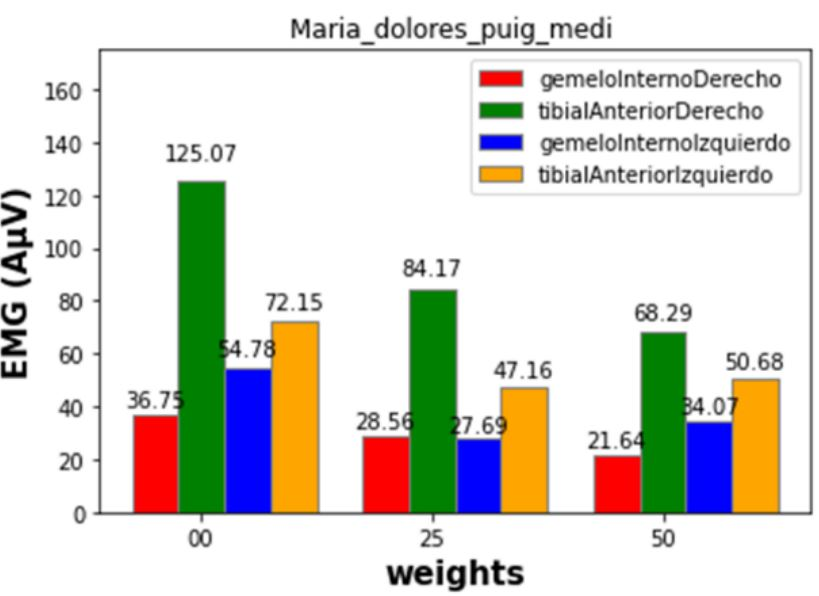
<br>
Debido al bajo número de sujetos y a las
notables diferencias en el estado de los mismos,
se va a analizar a cada sujeto por separado para
posteriormente intentar sacar conclusiones
generales.
###### Resultados y conclusiones en las páginas 1-6 del pdf Resultados.pdf

In [ ]:
"""
Esta función es simplemente para colocar el número encima de la barra.
Para cada barra, se saca la altura de la barra y se coloca un texto con
ese valor un poco por encima y en el centro de la barra.
"""
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
    
        plt.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                round(height,2) ,
                ha='center', va='bottom')         
            

            

"""
Vamos a calcular las diferencias de cada músculo para los distintos casos de estudio.
Además, dependiendo del caso se van a generar unos resultados en formato texto que resumirán lo que se 
puede apreciar en las gráficas. 

La función calculoResultados va a ser llamada por la función comparativaContraccionEmg, que es la que genera 
los gráficos. Esta llamada se realizará en el momento en el que la función comparativaContraccionEmg necesite los resultados
generados por esta primera función.

La función calculoResultados funciona de la siguiente manera:
Para cada caso (paciente_velocidad_soporte de peso) Vamos a guardar el músculo de mayor actividad y las diferencias de cada músculo 
entre los pesos 0-25 y 0-50. De esta manera podremos ver si hay diferencia o no con respecto al 0 y si 25% tiene más o menos impacto que 50%.
También vamos a comprobar la diferencia entre la media de la actividad de los gemelos y los tibiales, ya que los que presentan
menos diferencia entre tibiales y gemelos caminan peor y pueden presentar más cocontracciones mientras que los que presentan más diferencia 
deberían tener una marcha más clara presentando menos cocontracciones. (Esto lo validaremos más tarde)

Como hay algunos pacientes a los que no se les registró la actividad en algunas condiciones, saltará una excepción al buscarlos en el diccionario.
Por ejemplo, no existe un registro Petra_sanz_alta_50, pero como estamos leyendo todo en un bucle, el programa intentará buscarlo.
Por eso utilizamos un try-except, para que en los casos donde no se encuentra ese registro el programa siga con el siguiente

"""           
def calculoResultados(nombre, velocidad, gemeloInternoDerecho,tibialAnteriorDerecho,gemeloInternoIzquierdo,tibialAnteriorIzquierdo):
    MusculoMayorActividad={}
    DiferenciasEntreMusculos0y25={}
    DiferenciasEntreMusculos0y50={}
    
    pesos=["00","25","50"]
    
    """
    primero guardamos la diferencia (abs) entre músculos antagonistas.
    Redondeamos a dos decimales round((...),2)
    Calculamos la diferencia en porcentaje (resta y división). En la lista lo tenemos almacenado en las posiciones 0,1,2 que es al final 0/25, 25/25 y 50/25 -> aprovechamos el bucle.
    """
    for peso in pesos:
        try:
            diccionarioDiferenciaPorcentajesAntagonistas[nombre+velocidad+peso+"Izquierda"]=abs(round(((tibialAnteriorIzquierdo[int(int(peso)/25)]-gemeloInternoIzquierdo[int(int(peso)/25)])/gemeloInternoIzquierdo[int(int(peso)/25)])*100,2))
            diccionarioDiferenciaPorcentajesAntagonistas[nombre+velocidad+peso+"Derecha"]=abs(round(((tibialAnteriorDerecho[int(int(peso)/25)]-gemeloInternoDerecho[int(int(peso)/25)])/gemeloInternoDerecho[int(int(peso)/25)])*100,2))
            
        except:

            print(nombre+velocidad+peso)

            """
            Calculamos la media de los gemelos y de los tibiales y luego la diferencia. 
            """
        mediagemelos=(gemeloInternoDerecho[int(int(peso)/25)]+gemeloInternoIzquierdo[int(int(peso)/25)])/2
        mediatibiales=(tibialAnteriorDerecho[int(int(peso)/25)]+tibialAnteriorIzquierdo[int(int(peso)/25)])/2
        diferencia= mediagemelos-mediatibiales
        """
          Hacemos las comprobaciones de cuál tiene más contracción, ya que hay que comprobar si los pacientes de verdad usan más el tibial que el gemelo
          Metemos el resultado de ese paciente para ese peso en el diccionario de resultados de músculo con mayor actividad.
          La comprobación de si es 0 o no se hace por los pacientes que no tienen datos, para que en vez de tener un None tengan un 0
        """
        if(diferencia<0):
            if(mediagemelos!=0):
                MusculoMayorActividad["Para el peso " +peso+", el tibial tiene más contracción"]= round(((mediatibiales-mediagemelos)/mediagemelos)*100,2)
            else: 
                MusculoMayorActividad["Para el peso " +peso+", el tibial tiene más contracción"]=0
        
        else: 
           if(mediatibiales!=0):
            MusculoMayorActividad["Para el peso " +peso+", el gemelo tiene más contracción"]= round(((mediagemelos-mediatibiales)/mediatibiales)*100,2)
           else:
            MusculoMayorActividad["Para el peso " +peso+", el gemelo tiene más contracción"]=0
    
    """
    Miramos la diferencia entre gemelo derecho a peso 0 y 25. Como habíamos dicho antes, la actividad para peso 0 es la almacenada
    en la posición [0] de la lista y la almacenada en la posición [1] es la de 25. La de 50 aparecerá en la posición [2]
    """
    diferenciagemeloInternoDerecho0y25=gemeloInternoDerecho[0]-gemeloInternoDerecho[1]
    if diferenciagemeloInternoDerecho0y25<0:
           if(gemeloInternoDerecho[0]!=0):

               DiferenciasEntreMusculos0y25["gemeloInternoDerecho hace más fuerza en peso 25 que en peso 0" ]=round(((gemeloInternoDerecho[1]-gemeloInternoDerecho[0])/gemeloInternoDerecho[0])*100,2)
           else:
               DiferenciasEntreMusculos0y25["gemeloInternoDerecho hace más fuerza en peso 25 que en peso 0" ]=0
               
    else:
           if(gemeloInternoDerecho[1]!=0):

               DiferenciasEntreMusculos0y25["gemeloInternoDerecho hace más fuerza en peso 0 que en peso 25" ]=round(((gemeloInternoDerecho[0]-gemeloInternoDerecho[1])/gemeloInternoDerecho[1])*100,2)
           else:
               DiferenciasEntreMusculos0y25["gemeloInternoDerecho hace más fuerza en peso 0 que en peso 25" ]=0
    
    diferenciagemeloInternoDerecho0y50=gemeloInternoDerecho[0]-gemeloInternoDerecho[2]
    """
    Ahora miramos la diferencia de actividad del gemelo derecho entre los pesos 0 y 50
    """
    if diferenciagemeloInternoDerecho0y50<0:
        if(gemeloInternoDerecho[0]!=0):
            DiferenciasEntreMusculos0y50["gemeloInternoDerecho hace más fuerza en peso 50 que en peso 0"]=round(((gemeloInternoDerecho[2]-gemeloInternoDerecho[0])/gemeloInternoDerecho[0])*100,2)
        else:
            DiferenciasEntreMusculos0y50["gemeloInternoDerecho hace más fuerza en peso 50 que en peso 0"]=0
    else:
        if(gemeloInternoDerecho[2]!=0):
            
            DiferenciasEntreMusculos0y50["gemeloInternoDerecho hace más fuerza en peso 0 que en peso 50"]=round(((gemeloInternoDerecho[0]-gemeloInternoDerecho[2])/gemeloInternoDerecho[2])*100,2)
        else:
            DiferenciasEntreMusculos0y50["gemeloInternoDerecho hace más fuerza en peso 0 que en peso 50"]=0
    
    
    """
    Hacemos lo mismo pero en este caso para los tibiales
    """
    diferenciatibialAnteriorDerecho0y25=tibialAnteriorDerecho[0]-tibialAnteriorDerecho[1]
    if diferenciatibialAnteriorDerecho0y25<0:
        if(tibialAnteriorDerecho[0]!=0):
            DiferenciasEntreMusculos0y25["tibialAnteriorDerecho hace más fuerza en peso 25 que en peso 0" ]=round(((tibialAnteriorDerecho[1]-tibialAnteriorDerecho[0])/tibialAnteriorDerecho[0])*100,2)
        else:
           DiferenciasEntreMusculos0y25["tibialAnteriorDerecho hace más fuerza en peso 25 que en peso 0" ]=0 
    else:
        if(tibialAnteriorDerecho[1]!=0):
            DiferenciasEntreMusculos0y25["tibialAnteriorDerecho hace más fuerza en peso 0 que en peso 25" ]=round(((tibialAnteriorDerecho[0]-tibialAnteriorDerecho[1])/tibialAnteriorDerecho[1])*100,2)
        else:
            DiferenciasEntreMusculos0y25["tibialAnteriorDerecho hace más fuerza en peso 0 que en peso 25" ]=0
    
    diferenciatibialAnteriorDerecho0y50=tibialAnteriorDerecho[0]-tibialAnteriorDerecho[2]
    
    if diferenciatibialAnteriorDerecho0y50<0:
        if(tibialAnteriorDerecho[0]!=0):
           DiferenciasEntreMusculos0y50["tibialAnteriorDerecho hace más fuerza en peso 50 que en peso 0"]=round(((tibialAnteriorDerecho[2]-tibialAnteriorDerecho[0])/tibialAnteriorDerecho[0])*100,2)
        else:
            DiferenciasEntreMusculos0y50["tibialAnteriorDerecho hace más fuerza en peso 50 que en peso 0"]=0
    else:
        if(tibialAnteriorDerecho[2]!=0):
            DiferenciasEntreMusculos0y50["tibialAnteriorDerecho hace más fuerza en peso 0 que en peso 50"]=round(((tibialAnteriorDerecho[0]-tibialAnteriorDerecho[2])/tibialAnteriorDerecho[2])*100,2)
        else:
            DiferenciasEntreMusculos0y50["tibialAnteriorDerecho hace más fuerza en peso 0 que en peso 50"]=0
    
    
    
    """
    hacemos lo mismo para la pierna izquierda
    """
    diferenciagemeloInternoIzquierdo0y25=gemeloInternoIzquierdo[0]-gemeloInternoIzquierdo[1]
    if diferenciagemeloInternoIzquierdo0y25<0:
        if(gemeloInternoIzquierdo[0]!=0):
            DiferenciasEntreMusculos0y25["gemeloInternoIzquierdo hace más fuerza en peso 25 que en peso 0" ]=round(((gemeloInternoIzquierdo[1]-gemeloInternoIzquierdo[0])/gemeloInternoIzquierdo[0])*100,2)
        else:
            DiferenciasEntreMusculos0y25["gemeloInternoIzquierdo hace más fuerza en peso 25 que en peso 0" ]=0
    else:
        if(gemeloInternoIzquierdo[1]!=0):
            DiferenciasEntreMusculos0y25["gemeloInternoIzquierdo hace más fuerza en peso 0 que en peso 25" ]=round(((gemeloInternoIzquierdo[0]-gemeloInternoIzquierdo[1])/gemeloInternoIzquierdo[1])*100,2)
        else:
            DiferenciasEntreMusculos0y25["gemeloInternoIzquierdo hace más fuerza en peso 0 que en peso 25" ]=0
    
    diferenciagemeloInternoIzquierdo0y50=gemeloInternoIzquierdo[0]-gemeloInternoIzquierdo[2]
    
    if diferenciagemeloInternoIzquierdo0y50<0:
        if(gemeloInternoIzquierdo[0]!=0):
            DiferenciasEntreMusculos0y50["gemeloInternoIzquierdo hace más fuerza en peso 50 que en peso 0"]=round(((gemeloInternoIzquierdo[2]-gemeloInternoIzquierdo[0])/gemeloInternoIzquierdo[0])*100,2)
        else :
            DiferenciasEntreMusculos0y50["gemeloInternoIzquierdo hace más fuerza en peso 50 que en peso 0"]=0
    else:
        if(gemeloInternoIzquierdo[2]!=0):
            DiferenciasEntreMusculos0y50["gemeloInternoIzquierdo hace más fuerza en peso 0 que en peso 50"]=round(((gemeloInternoIzquierdo[0]-gemeloInternoIzquierdo[2])/gemeloInternoIzquierdo[2])*100,2)
        else:
            DiferenciasEntreMusculos0y50["gemeloInternoIzquierdo hace más fuerza en peso 0 que en peso 50"]=0
    
    diferenciatibialAnteriorIzquierdo0y25=tibialAnteriorIzquierdo[0]-tibialAnteriorIzquierdo[1]
    if diferenciatibialAnteriorIzquierdo0y25<0:
        if(tibialAnteriorIzquierdo[0]!=0):
            DiferenciasEntreMusculos0y25["tibialAnteriorIzquierdo hace más fuerza en peso 25 que en peso 0" ]=round(((tibialAnteriorIzquierdo[1]-tibialAnteriorIzquierdo[0])/tibialAnteriorIzquierdo[0])*100,2)
        else:
            DiferenciasEntreMusculos0y25["tibialAnteriorIzquierdo hace más fuerza en peso 25 que en peso 0" ]=0
    else:
        if(tibialAnteriorIzquierdo[1]!=0):
            DiferenciasEntreMusculos0y25["tibialAnteriorIzquierdo hace más fuerza en peso 0 que en peso 25" ]=round(((tibialAnteriorIzquierdo[0]-tibialAnteriorIzquierdo[1])/tibialAnteriorIzquierdo[1])*100,2)
        else:
            DiferenciasEntreMusculos0y25["tibialAnteriorIzquierdo hace más fuerza en peso 0 que en peso 25" ]=0
    
    diferenciatibialAnteriorIzquierdo0y50=tibialAnteriorIzquierdo[0]-tibialAnteriorIzquierdo[2]
    
    if diferenciatibialAnteriorIzquierdo0y50<0:
        if(tibialAnteriorIzquierdo[0]!=0):
            DiferenciasEntreMusculos0y50["tibialAnteriorIzquierdo hace más fuerza en peso 50 que en peso 0"]=round(((tibialAnteriorIzquierdo[2]-tibialAnteriorIzquierdo[0])/tibialAnteriorIzquierdo[0])*100,2)
        else:
            DiferenciasEntreMusculos0y50["tibialAnteriorIzquierdo hace más fuerza en peso 50 que en peso 0"]=0
    else:
        if(tibialAnteriorIzquierdo[2]!=0):
            DiferenciasEntreMusculos0y50["tibialAnteriorIzquierdo hace más fuerza en peso 0 que en peso 50"]=round(((tibialAnteriorIzquierdo[0]-tibialAnteriorIzquierdo[2])/tibialAnteriorIzquierdo[2])*100,2)
        else:
            DiferenciasEntreMusculos0y50["tibialAnteriorIzquierdo hace más fuerza en peso 0 que en peso 50"]=0
    return MusculoMayorActividad, DiferenciasEntreMusculos0y25,DiferenciasEntreMusculos0y50

diccionarioDiferenciaPorcentajesAntagonistas={}

"""
En esta función vamos a ir recorriendo todos los pacientes, todos los pesos, todas las velocidades y músculos y vamos a ir 
construyendo los gráficos de barras a partir de llamadas a la otra función.
"""
def comparativaContraccionEmg():
    listaNombres=[]
    for key in diccionarioMaximaMediaEmg.keys():
        # print(key)
        """
        para cada key nos quedamos con el nombre. Ahora solo queremos el nombre ya que vamos a ir iterando para cada nombre, peso, velocidad y músculo.
        El nombre es toda la clave hasta el espacio-6 caracteres =-2 caracteres del peso - 4 caracteres de la velocidad
        
        """
        nombre=str(key)[:str(key).find(" ")-6]
        listaNombres.append(nombre)
    pesos=["00","25","50"]
    velocidades=["alta","medi","baja"]
    musculos=["gemeloInternoDerecho","tibialAnteriorDerecho","gemeloInternoIzquierdo","tibialAnteriorIzquierdo"]
    #vamos a construir un barplot con los datos obtenidos del apartado anterior, de las contracciones medias del EMG,
    # es decir, con los datos del diccionarioMaximaMediaEmg 
    #empezamos a declarar las variables del barplot
    barWidth = 0.2
    fig = plt.subplots(figsize =(12, 8))
    br1= np.arange(len(pesos))
    br2 = [x + barWidth for x in br1]
    br3 = [x + barWidth for x in br2]
    br4 = [x + barWidth for x in br3]
    #barplot vels por pesos
    listaResultados=[]
    for nombre in list(set(listaNombres)):
        for velocidad in velocidades:
            # para cada nombre y velocidad vamos a crear una lista para cada músculo donde vamos a meter la contracción media de cada peso
            gemeloInternoDerecho=[]
            tibialAnteriorDerecho=[]
            gemeloInternoIzquierdo=[]
            tibialAnteriorIzquierdo=[]
            mediaVelocidad=[]
            for peso in pesos:
                #si el resultado almacenado es un None significa que no hay datos de esa persona y vamos a guardar un 0 que no dará un error al representarlo en el barplot
                #si no es 0, metemos el numero como tal
                if(diccionarioMaximaMediaEmg.get(nombre+velocidad+peso+" "+musculos[0])==None):
                    gemeloInternoDerecho.append(0)
                else:
                    gemeloInternoDerecho.append(diccionarioMaximaMediaEmg.get(nombre+velocidad+peso+" "+musculos[0]))
                if(diccionarioMaximaMediaEmg.get(nombre+velocidad+peso+" "+musculos[1])==None):
                    tibialAnteriorDerecho.append(0)
                
                else: tibialAnteriorDerecho.append(diccionarioMaximaMediaEmg.get(nombre+velocidad+peso+" "+musculos[1]))
                if(diccionarioMaximaMediaEmg.get(nombre+velocidad+peso+" "+musculos[2])==None):
                    gemeloInternoIzquierdo.append(0)
                else: gemeloInternoIzquierdo.append(diccionarioMaximaMediaEmg.get(nombre+velocidad+peso+" "+musculos[2]))
                if(diccionarioMaximaMediaEmg.get(nombre+velocidad+peso+" "+musculos[3])==None):
                    tibialAnteriorIzquierdo.append(0)
                else:
                    tibialAnteriorIzquierdo.append(diccionarioMaximaMediaEmg.get(nombre+velocidad+peso+" "+musculos[3]))
         
            #Calculamos los datos explicados en la función de calculoResultados
            MusculoMayorActividad,DiferenciasEntreMusculos0y25,DiferenciasEntreMusculos0y50=calculoResultados(nombre, velocidad,gemeloInternoDerecho,tibialAnteriorDerecho,gemeloInternoIzquierdo,tibialAnteriorIzquierdo)

            resultado= "el paciente "+ nombre+ " para la velocidad " + velocidad+ " presenta los siguientes resultados: \n "+ "Musculo con mayor contraccion "+ str (MusculoMayorActividad)+ "\nDiferencias entre musculos entre 0 y 25 " + str(DiferenciasEntreMusculos0y25)+ "\n Diferencias entre musculos entre 0 y 50 "+ str(DiferenciasEntreMusculos0y50)
            #calculamos la media de todo
            listaResultados.append(resultado)
            for elemento in gemeloInternoDerecho:
                if elemento!=0:
                    mediaVelocidad.append(elemento)
            for elemento in tibialAnteriorDerecho:
                if elemento!=0:

                    mediaVelocidad.append(elemento)
            for elemento in gemeloInternoIzquierdo:
                if elemento!=0:

                    mediaVelocidad.append(elemento)
            for elemento in tibialAnteriorIzquierdo:
                if elemento!=0:

                    mediaVelocidad.append(elemento)
                    
            #calculamos el gráfico pasándole la lista de cada músculo
            plt.title(nombre+velocidad+" "+str(float(round(np.mean(mediaVelocidad),2))))
            rects1=plt.bar(br1, gemeloInternoDerecho, color ='r', width = barWidth, edgecolor ='grey', label ='gemeloInternoDerecho')
            rects2=plt.bar(br2, tibialAnteriorDerecho, color ='g', width = barWidth, edgecolor ='grey', label ='tibialAnteriorDerecho')
            rects3=plt.bar(br3, gemeloInternoIzquierdo, color ='b', width = barWidth, edgecolor ='grey', label ='gemeloInternoIzquierdo')
            rects4=plt.bar(br4, tibialAnteriorIzquierdo, color ='orange', width = barWidth, edgecolor ='grey', label ='tibialAnteriorIzquierdo')
            plt.xlabel('weights', fontweight ='bold', fontsize = 15)
            plt.ylabel('EMG (ÂµV)', fontweight ='bold', fontsize = 15)
            plt.ylim(0, 175)
            plt.xticks([r + barWidth for r in range(len(pesos))],
                       pesos)
            
            plt.legend()
            autolabel(rects1)
            autolabel(rects2)
            autolabel(rects3)
            autolabel(rects4)

            plt.figure()
            # Estos son los resultados en texto. Es decir los comentarios autogenerados de las graficas
            #print("---------------------------------------------------------------------------------------")
            #print(listaResultados) 
            #print("---------------------------------------------------------------------------------------")


    

comparativaContraccionEmg()


#### Cocontracciones
Las cocontracciones afectan negativamente en la marcha de pacientes mayores, ya que se deben a la activación de músculos antagonistas. 
<br>
En los pacientes que caminan mejor (tienen una mejor nota en el análisis preliminar) se puede ver como la diferencia entre tibiales y gemelos es más grande. En este caso las actividades de estos músculos antagonistas está bien diferenciada. 
<br>
En esta sección vamos a estudiar el índice de coactivación de los pacientes y vamos a ver si de verdad está relacionado con la diferencia de actividad entre gemelos y tibiales. 
<br>
La hipótesis es esta:
- María_Dolores_puig muestra una diferencia clara entre la actividad de tibial y gemelo. Esto se puede ver de manera simple pero clara fijándonos en que las medias de las actividades de los músculos están más o menos diferenciadas. Esto significaría que esta persona no presenta cocontracciones y, por lo tanto, camina bien.
- Por otra parte, Petra muestra unas actividades de los músculos muy poco diferenciadas (las medias son cercanas). De acuerdo con la hipótesis esta persona presentaría cocontracciones, ya que las actividades de gemelo y tibial están poco diferenciadas
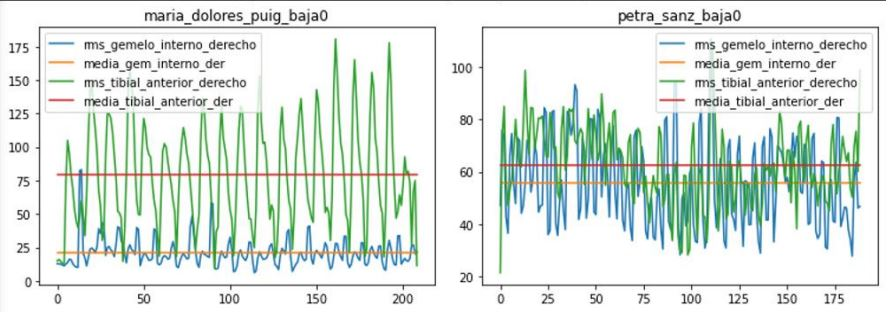
<br> 
Para comprobar esto vamos a calcular el índice de cocontracciones y vamos a ver si está negativamente correlacionado con la diferencia de actividad entre tibiales y gemelos. 
- Si esto de verdad es así, podremos decir que en los casos donde el andador ha ayudado a separar la actividad entre tibiales y gemelos, en consecuencia ha rebajado la presencia de cocontracciones en la marcha del paciente

En esta sección vamos a calcular el índice de coactivación con esta fórmula:
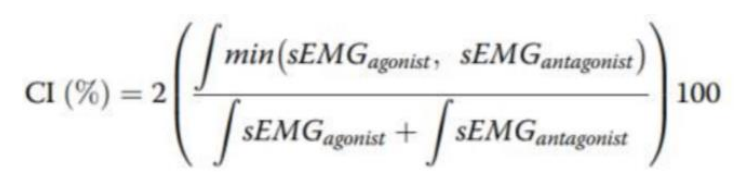

Y vamos a generar este tipo de gráficos con la comparación del EMG entre músculos antagonistas y las medias, donde se puede comparar rápidamente la actividad general.

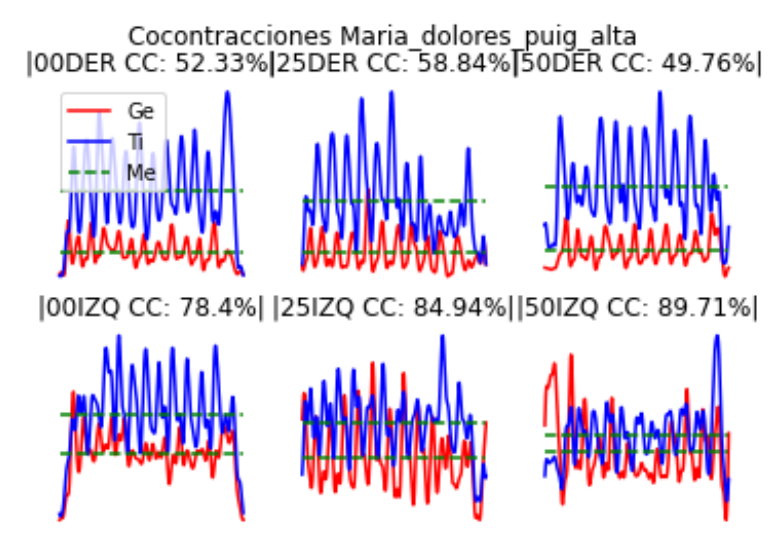


In [ ]:
senales_resampled={}

In [ ]:
fsEMG = 4.03  # Frecuencia de muestreo

factorinterpolacion=1
fsEMGinterpolada=fsEMG*factorinterpolacion

def interpolar_senal(senal):
    x = np.arange(len(senal))
    x_interp = np.linspace(0, len(senal) - 1, len(senal) * factorinterpolacion)
    interpolacion = interp1d(x, senal, kind='cubic')
    senal_interp = interpolacion(x_interp)


    return senal_interp




def apply_highpass_filter(data, cutoff_freq):
    # Diseñar el filtro paso alto
    b, a = butter(N=4, Wn=cutoff_freq / (fsEMGinterpolada/2), btype='high', analog=False)
    # Aplicar el filtro a los datos
    filtered_data = filtfilt(b, a, data)
    return filtered_data

def intento_CI_cortando_emg_y_bajando_senal(senal):
    senal=interpolar_senal(senal)
    senal=apply_highpass_filter(senal,0.5)
   
    primercuarto=int((15/100)*len(senal))
    tercercuarto=int((85/100)*len(senal))
    senal=senal[primercuarto:tercercuarto]

    # con el minimo esta un poco mal
    # min_absoluto = min(senal)
    # senal = [x +abs( min_absoluto) for x in senal]
    
    
    
    # con el cuartil 
    minimo=np.percentile(senal,15)
    senal = [x +abs( minimo) for x in senal]
    #pongo a 0 todos los que estan por debajo de 0
    for i in np.arange(len(senal)):
        if senal[i]<0:
            senal[i]=0
            
    return senal


In [ ]:
def replace_nan_with_average(lst):
    for i in range(len(lst)):
        if math.isnan(lst[i]):
            # Encuentra el valor anterior que no es NaN
            prev_val = lst[i - 1] if i > 0 else float('nan')

            # Encuentra el siguiente valor que no es NaN
            next_index = i + 1
            while next_index < len(lst) and math.isnan(lst[next_index]):
                next_index += 1
            next_val = lst[next_index] if next_index < len(lst) else float('nan')

            # Calcula el promedio si es posible
            if not math.isnan(prev_val) and not math.isnan(next_val):
                lst[i] = (prev_val + next_val) / 2
            elif not math.isnan(prev_val):
                lst[i] = prev_val
            elif not math.isnan(next_val):
                lst[i] = next_val
            # Si ambos, prev_val y next_val, son NaN, entonces no se realiza el reemplazo
    return lst

In [ ]:
import math
diccionariolimpio=diccionario.copy()

"""
Esta función es para limpiar missing values
"""
def limpiarNans(lista):
    listaSinNans=[]
    for i in np.arange(len(lista)):
        
        if( np.isnan(lista[i])):
            i+=1
        else:
            listaSinNans.append(lista[i])
    return listaSinNans
"""
Esta función es para calcular el numerador de la fracción min(emg1,emg2), devuelve el mínimo de la media de las señales
"""
def funcionMinimaMedias(f1,f2):
    media1=np.mean(f1)
    media2=np.mean(f2)
    if media1<media2:
        return f1
    else:
        return f2


"""
Esta función calcula la integral de la señal.
"""
def integralLista(lista):
    
    if(np.isnan(lista[-1])):
        lista=lista[:-1]
    
    return np.trapz(lista)

#Definimos un diccionario para almacenar el CI para cada caso
notaCoactivaciones={}
def indiceCocontracciones():
    
    listaNombres=[]
    """
    Al igual que en casos anteriores, vamos a ir iterando para cada nombre/peso/velocidad
    Por eso separamos el nombre del resto de la key como antes:-6=-4 caracteres de la velocidad - 2 dígitos del peso
    """
    for key in diccionario.keys():
        # print(key)
        nombre=str(key)[:len(str(key))-6]
        listaNombres.append(nombre)
    pesos=["00","25","50"]
    velocidades=["alta","medi","baja"]
    # musculos=["gemeloInternoDerecho","tibialAnteriorDerecho","gemeloInternoIzquierdo","tibialAnteriorIzquierdo"]
    
    
    #Para cada nombre y velocidad declaramos un conjunto de subplots
    for nombre in list(set(listaNombres)):
        for velocidad in velocidades:
            fig, axs = plt.subplots(2, len(pesos),figsize=(30, 20))
            fig.suptitle("Cocontracciones "+nombre+velocidad,fontsize=25)
            contador=0
            primero=True
            for peso in pesos:
                #Nos saltamos los casos donde no hay registros para que no de error
                if("50" in peso and "Petra" in nombre and ("baja"  in velocidad or "alta" in velocidad)):
                    break
                dataset=diccionario.get(nombre+velocidad+peso)
                #cogemos la señal, limpiamos los nans y la resampleamos para que la fórmula funcione bien, ya que 
                #recordemos que estamos trabajando con las señales tratadas por mdurance que ofrecen un número muy bajo de muestras
                rms_gemelo_interno_derecho=dataset.iloc[:,7].values
                rms_gemelo_interno_derecho = replace_nan_with_average(rms_gemelo_interno_derecho)
                
                #rms_gemelo_interno_derecho=signal.resample(rms_gemelo_interno_derecho,1000)
                
                rms_gemelo_interno_derecho=intento_CI_cortando_emg_y_bajando_senal(rms_gemelo_interno_derecho)
                
                
                rms_tibial_anterior_derecho=dataset.iloc[:,8].values


                rms_tibial_anterior_derecho = replace_nan_with_average(rms_tibial_anterior_derecho)

                rms_gemelo_interno_derecho=limpiarNans(rms_gemelo_interno_derecho)
                
                rms_tibial_anterior_derecho=limpiarNans(rms_tibial_anterior_derecho)
                #rms_tibial_anterior_derecho=signal.resample(rms_tibial_anterior_derecho,1000)
                rms_tibial_anterior_derecho=intento_CI_cortando_emg_y_bajando_senal(rms_tibial_anterior_derecho)


#normalizacion señales entre 0 y 1 porque lo que miramos es la coactivacion comun en tiempo, la amplitud de las señales nos da igual
                rms_tibial_anterior_derecho_Norm=rms_tibial_anterior_derecho/max(rms_tibial_anterior_derecho)
                rms_gemelo_interno_derecho_Norm=rms_gemelo_interno_derecho/max(rms_gemelo_interno_derecho)

                auc_gemelo_interno_derecho = np.trapz(rms_gemelo_interno_derecho_Norm)
                auc_tibial_anterior_derecho = np.trapz(rms_tibial_anterior_derecho_Norm)
                
                # Identificar el área común
                area_comun = np.minimum(rms_tibial_anterior_derecho_Norm, rms_gemelo_interno_derecho_Norm)
                
                # Calcular el área bajo la curva común
                auc_comun = np.trapz(area_comun)
                
                # Calcular el índice de coactivación
                indice_coactivacion_Der =2*100*( auc_comun / (auc_tibial_anterior_derecho + auc_gemelo_interno_derecho))
                indice_coactivacion_Der=np.round(indice_coactivacion_Der,2)
            



            
                #calculo CI con la formula 
                # minimoderecha = funcionMinimaMedias(rms_gemelo_interno_derecho, rms_tibial_anterior_derecho)
                # score1= 2*100*(integralLista(minimoderecha)/(integralLista(rms_gemelo_interno_derecho)+integralLista(rms_tibial_anterior_derecho)))
                # score1=np.round(score1,2)

            
                notaCoactivaciones[nombre+velocidad+peso+"Derecha"]=indice_coactivacion_Der
                
                #Nos ayudamos del bucle para ir ploteando las gráficas dentro del subplot
                #Pintamos también la media de las señales que nos ayuda a ver rápidamente la actividad de los músculos. (Función ones)
                #Comprobamos si estamos en la primera iteración o no para no repetir la leyenda muchas veces.
                
                axs[0,contador].plot(np.arange(len(rms_gemelo_interno_derecho_Norm)),rms_gemelo_interno_derecho_Norm,label="Ge",color="r")
                axs[0,contador].plot(np.arange(len(rms_tibial_anterior_derecho_Norm)),rms_tibial_anterior_derecho_Norm,label="Ti",color="b")
                axs[0, contador].fill_between(np.arange(len(area_comun)), area_comun, color="purple", alpha=0.3)

                axs[0, contador].plot(np.arange(len(rms_tibial_anterior_derecho_Norm)), np.ones(len(rms_tibial_anterior_derecho_Norm)) * 0, color="black", linestyle='--', lw=4)
                axs[0,contador].legend()

                #axs[0,contador].axis('off')
                titulo="|"+peso+"DER CC: "+str(indice_coactivacion_Der)+"%|"
                axs[0,contador].set_title(titulo,fontsize=25)
                # axs[contador, 0].figure()
                
                
                #Hacemos lo mismo para la pierna izquierda que va a ir en los 3 subplots de la línea de abajo (00IZQ, 25IZQ, 50IZQ)
                rms_gemelo_interno_izquierdo=dataset.iloc[:,9].values

                rms_gemelo_interno_izquierdo = replace_nan_with_average(rms_gemelo_interno_izquierdo)
                rms_gemelo_interno_izquierdo=limpiarNans(rms_gemelo_interno_izquierdo)
                
                #rms_gemelo_interno_izquierdo=signal.resample(rms_gemelo_interno_izquierdo,1000)
                
                rms_gemelo_interno_izquierdo=intento_CI_cortando_emg_y_bajando_senal(rms_gemelo_interno_izquierdo)
                
                rms_tibial_anterior_izquierdo=dataset.iloc[:,10].values

                rms_tibial_anterior_izquierdo = replace_nan_with_average(rms_tibial_anterior_izquierdo)            

                rms_tibial_anterior_izquierdo=limpiarNans(rms_tibial_anterior_izquierdo)
                #rms_tibial_anterior_izquierdo=signal.resample(rms_tibial_anterior_izquierdo,1000)
                
                rms_tibial_anterior_izquierdo=intento_CI_cortando_emg_y_bajando_senal(rms_tibial_anterior_izquierdo)

                rms_tibial_anterior_izquierdo_Norm=rms_tibial_anterior_izquierdo/max(rms_tibial_anterior_izquierdo)
                rms_gemelo_interno_izquierdo_Norm=rms_gemelo_interno_izquierdo/max(rms_gemelo_interno_izquierdo)




                auc_tibial_anterior_izquierdo = np.trapz(rms_tibial_anterior_izquierdo_Norm)
                auc_gemelo_interno_izquierdo = np.trapz(rms_gemelo_interno_izquierdo_Norm)
                
                # Identificar el área común
                area_comun_izq = np.minimum(rms_tibial_anterior_izquierdo_Norm, rms_gemelo_interno_izquierdo_Norm)
                
                # Calcular el área bajo la curva común
                auc_comun_izq = np.trapz(area_comun_izq)
                
                # Calcular el índice de coactivación
                indice_coactivacion_Izq = 2 * 100 * (auc_comun_izq / (auc_tibial_anterior_izquierdo + auc_gemelo_interno_izquierdo))
                indice_coactivacion_Izq = np.round(indice_coactivacion_Izq, 2)

            
                # minimoIzquierda=funcionMinimaMedias(rms_gemelo_interno_izquierdo, rms_tibial_anterior_izquierdo)
                # score2= 2*100*(integralLista(minimoIzquierda)/(integralLista(rms_gemelo_interno_izquierdo)+integralLista(rms_tibial_anterior_izquierdo)))
                # score2=np.round(score2,2)
                notaCoactivaciones[nombre+velocidad+peso+"Izquierda"]=indice_coactivacion_Izq
                axs[1,contador].plot(np.arange(len(rms_gemelo_interno_izquierdo_Norm)),rms_gemelo_interno_izquierdo_Norm,label="Ge",color="r")
                axs[1,contador].plot(np.arange(len(rms_tibial_anterior_izquierdo_Norm)),rms_tibial_anterior_izquierdo_Norm,label="Tib",color="b")
                axs[1, contador].fill_between(np.arange(len(area_comun_izq)), area_comun_izq, color="purple", alpha=0.3)
               
                axs[1, contador].plot(np.arange(len(rms_tibial_anterior_derecho_Norm)), np.ones(len(rms_tibial_anterior_derecho_Norm)) * 0, color="black", linestyle='--', lw=4)
                #axs[1,contador].axis('off')

                axs[1,contador].legend()
                titulo="|"+peso+"IZQ CC: "+str(indice_coactivacion_Izq)+"%|"

                axs[1,contador].set_title(titulo,fontsize=25)
                # axs[contador, 1].figure()
                
                contador+=1
                for ax in axs.flat:
                    ax.label_outer()



                # Obtener la longitud de rms_gemelo_interno_izquierdo
                longitud_objetivo = len(rms_gemelo_interno_izquierdo)
                
                # Obtener las columnas relevantes del dataset
                datos_relevantes = dataset.iloc[:, :7]
                
                # Ajustar el tamaño de los datos relevantes para que coincida con rms_gemelo_interno_izquierdo
                if len(datos_relevantes) > longitud_objetivo:
                    # Recortar si los datos relevantes son más largos
                    datos_relevantes = datos_relevantes.iloc[:longitud_objetivo]
                elif len(datos_relevantes) < longitud_objetivo:
                    # Rellenar con NaNs si los datos relevantes son más cortos
                    cantidad_rellenar = longitud_objetivo - len(datos_relevantes)
                    relleno = pd.DataFrame(np.nan, index=range(cantidad_rellenar), columns=datos_relevantes.columns)
                    datos_relevantes = pd.concat([datos_relevantes, relleno], ignore_index=True)
                nuevas_columnas = dataset.columns
                try:
                # Ahora puedes concatenar de manera segura
                    datos_ajustados = np.column_stack((datos_relevantes, rms_gemelo_interno_derecho, rms_tibial_anterior_derecho, rms_gemelo_interno_izquierdo, rms_tibial_anterior_izquierdo))
                    diccionariolimpio[nombre+velocidad+peso] = pd.DataFrame(datos_ajustados, columns=nuevas_columnas)
                except:
                    None
                
                                
indiceCocontracciones()



In [ ]:
import numbers
diccionarioContraccionMediaEmg={}
# Definir un MinMaxScaler personalizado
def max_abs_scaler(data):
    max_abs = np.max(np.abs(data))
    return data / max_abs

fsEMG = 4.03  # Frecuencia de muestreo
distancia_muestras = int(fsEMG * 0.5)  # Distancia en muestras para 1 segundo




listaNombres=[]
for key in diccionario.keys():
    # print(key)
    nombre=str(key)[:len(str(key))-6]
    listaNombres.append(nombre)
pesos=["00","25","50"]
velocidades=["alta","medi","baja"]

maxima_contraccion_gemelo={}
maxima_contraccion_tibial={}
#Para cada nombre y velocidad declaramos un conjunto de subplots
    
for nombre in list(set(listaNombres)):
    lista_maximo_gemelo=[]
    lista_maximo_tibial=[]
    for velocidad in velocidades:
        for peso in pesos:
            try:
                dataset = diccionariolimpio[nombre+velocidad+peso]
    
                
                # Eliminas las filas que contienen NaN en las columnas seleccionadas
                
                rms_gemelo_interno_derecho = dataset.iloc[:, 7].values
                rms_tibial_anterior_derecho = dataset.iloc[:, 8].values
                rms_gemelo_interno_izquierdo = dataset.iloc[:, 9].values
                rms_tibial_anterior_izquierdo = dataset.iloc[:, 10].values
                
                rms_gemelo_interno_derecho = replace_nan_with_average(rms_gemelo_interno_derecho)
                rms_tibial_anterior_derecho = replace_nan_with_average(rms_tibial_anterior_derecho)
                rms_gemelo_interno_izquierdo = replace_nan_with_average(rms_gemelo_interno_izquierdo)
                rms_tibial_anterior_izquierdo = replace_nan_with_average(rms_tibial_anterior_izquierdo)

                        
                maximo_gemelo = np.max([
                    np.max(np.abs(rms_gemelo_interno_derecho)),
                    np.max(np.abs(rms_gemelo_interno_izquierdo)),
                ])
                maximo_tibial = np.max([
                    np.max(np.abs(rms_tibial_anterior_derecho)),
                    np.max(np.abs(rms_tibial_anterior_izquierdo))
                ])
    
                lista_maximo_gemelo.append(maximo_gemelo)
                lista_maximo_tibial.append(maximo_tibial)

            except:
                print(nombre)


    print(nombre)
    print(lista_maximo_gemelo)
    print(lista_maximo_tibial)            
    maxima_contraccion_gemelo[nombre]=max(lista_maximo_gemelo)
    maxima_contraccion_tibial[nombre]=max(lista_maximo_tibial)
            
print(maxima_contraccion_gemelo)
print(maxima_contraccion_tibial)

for key in diccionariolimpio.keys():
    dataset = diccionariolimpio.get(key)

    rms_gemelo_interno_derecho = dataset.iloc[:, 7].values
    rms_tibial_anterior_derecho = dataset.iloc[:, 8].values
    rms_gemelo_interno_izquierdo = dataset.iloc[:, 9].values
    rms_tibial_anterior_izquierdo = dataset.iloc[:, 10].values
    eje_x = np.arange(len(rms_gemelo_interno_derecho))

    
    rms_gemelo_interno_derecho = replace_nan_with_average(rms_gemelo_interno_derecho)
    rms_tibial_anterior_derecho = replace_nan_with_average(rms_tibial_anterior_derecho)
    rms_gemelo_interno_izquierdo = replace_nan_with_average(rms_gemelo_interno_izquierdo)
    rms_tibial_anterior_izquierdo = replace_nan_with_average(rms_tibial_anterior_izquierdo)


    # Normalizar las señales usando el máximo absoluto
    nombre=str(key)[:len(str(key))-6]

    rms_gemelo_interno_derecho = rms_gemelo_interno_derecho / maxima_contraccion_gemelo[nombre]
    rms_tibial_anterior_derecho = rms_tibial_anterior_derecho / maxima_contraccion_tibial[nombre]
    rms_gemelo_interno_izquierdo = rms_gemelo_interno_izquierdo / maxima_contraccion_gemelo[nombre]
    rms_tibial_anterior_izquierdo = rms_tibial_anterior_izquierdo / maxima_contraccion_tibial[nombre]


    
    # Calcula la media de cada señal
    media_gid = rms_gemelo_interno_derecho.mean()
    media_tad = rms_tibial_anterior_derecho.mean()
    media_gii = rms_gemelo_interno_izquierdo.mean()
    media_tai = rms_tibial_anterior_izquierdo.mean()

    # Encuentra los picos por encima de la media para cada señal
    picos_gid, propiedades_gid = find_peaks(rms_gemelo_interno_derecho, height=media_gid, distance=distancia_muestras)
    picos_tad, propiedades_tad = find_peaks(rms_tibial_anterior_derecho, height=media_tad, distance=distancia_muestras)
    picos_gii, propiedades_gii = find_peaks(rms_gemelo_interno_izquierdo, height=media_gii, distance=distancia_muestras)
    picos_tai, propiedades_tai = find_peaks(rms_tibial_anterior_izquierdo, height=media_tai, distance=distancia_muestras)

    if key== "Jose_antonio_nieto_alta00":
        print(picos_gii)
        print(media_gii)

    # Calcula la media de las amplitudes de los picos
    media_amplitud_gid = propiedades_gid["peak_heights"].mean() if picos_gid.size > 0 else 0
    media_amplitud_tad = propiedades_tad["peak_heights"].mean() if picos_tad.size > 0 else 0
    media_amplitud_gii = propiedades_gii["peak_heights"].mean() if picos_gii.size > 0 else 0
    media_amplitud_tai = propiedades_tai["peak_heights"].mean() if picos_tai.size > 0 else 0

    # Muestra las medias de las amplitudes de los picos
    print(f"Media de amplitudes de picos para {key}:")
    print(f"rms_gemelo_interno_derecho: {media_amplitud_gid}")
    print(f"rms_tibial_anterior_derecho: {media_amplitud_tad}")
    print(f"rms_gemelo_interno_izquierdo: {media_amplitud_gii}")
    print(f"rms_tibial_anterior_izquierdo: {media_amplitud_tai}")


    diccionarioContraccionMediaEmg[key+" tibialAnteriorDerecho"]=media_amplitud_tad
    diccionarioContraccionMediaEmg[key+" tibialAnteriorIzquierdo"]=media_amplitud_tai
    diccionarioContraccionMediaEmg[key+" gemeloInternoIzquierdo"]=media_amplitud_gii
    diccionarioContraccionMediaEmg[key+" gemeloInternoDerecho"]=media_amplitud_gid

    # Gráfico de líneas
    plt.figure(figsize=(10, 5))
    plt.plot(eje_x, rms_gemelo_interno_derecho, label="rms_gemelo_interno_derecho")
    plt.plot(eje_x, rms_tibial_anterior_derecho, label="rms_tibial_anterior_derecho")
    plt.plot(eje_x, rms_gemelo_interno_izquierdo, label="rms_gemelo_interno_izquierdo")
    plt.plot(eje_x, rms_tibial_anterior_izquierdo, label="rms_tibial_anterior_izquierdo")

    # Marca los picos en el gráfico
    plt.plot(picos_gid, rms_gemelo_interno_derecho[picos_gid], "x")
    plt.plot(picos_tad, rms_tibial_anterior_derecho[picos_tad], "x")
    plt.plot(picos_gii, rms_gemelo_interno_izquierdo[picos_gii], "x")
    plt.plot(picos_tai, rms_tibial_anterior_izquierdo[picos_tai], "x")

    plt.title(key)
    plt.legend()
    plt.show()


In [ ]:
contador=0

"""

for key in senales_resampled.keys():
    if "Antonio" in str(key):

        if contador==2:
            contador=0
            plt.legend()
            plt.figure()
        plt.plot(senales_resampled[key], label=str(key))

        contador+=1
"""
import scipy.signal as sig
correlaciones={}
def cross_correlation():
    for key in list(senales_resampled.keys()):
        key=key[:-6]
        tibialder=senales_resampled[key+"TibDer"]
        tibialder=(tibialder-np.mean(tibialder))/np.std(tibialder)
        tibializq=senales_resampled[key+"TibIzq"]
        tibializq=(tibializq-np.mean(tibializq))/np.std(tibializq)
        
        correlaciones[key+"Tib"]=sig.correlate(tibialder,tibializq,mode='full')
        correlaciones[key+"Tib"]=(correlaciones[key+"Tib"]-np.mean(correlaciones[key+"Tib"]))/np.std(correlaciones[key+"Tib"])

        
        fsEMG = 4.03  # Frecuencia de muestreo original
        factor_resampleo = 1000  # Factor de resampleo
        time = np.arange(len(tibialder)) / fsEMG


        cross_corr_timetib = np.arange(len(correlaciones[key+"Tib"])) - (len(tibializq) - 1)
        cross_corr_timetib = cross_corr_timetib / fsEMG

        plt.plot(time,tibialder,label="tibialder")
        plt.plot(time,tibializq,label="tibialder")
        plt.plot(cross_corr_timetib,correlaciones[key+"Tib"],label="correlaciones")
        plt.title(key+" Tib")
        plt.legend()
        plt.figure()
        
        
        Gemder=senales_resampled[key+"GemDer"]
        Gemder=(Gemder-np.mean(Gemder))/np.std(Gemder)

        Gemizq=senales_resampled[key+"GemIzq"]
        Gemizq=(Gemizq-np.mean(Gemizq))/np.std(Gemizq)

        correlaciones[key+"Gem"]=sig.correlate(Gemder,Gemizq,mode='full')
        correlaciones[key+"Gem"]=(correlaciones[key+"Gem"]-np.mean(correlaciones[key+"Gem"]))/np.std(correlaciones[key+"Gem"])
        
        cross_corr_timeGem = np.arange(len(correlaciones[key+"Gem"])) - (len(Gemizq) - 1)
        cross_corr_timeGem = cross_corr_timeGem / fsEMG
        plt.plot(time,Gemder,label="Gemder")
        plt.plot(time,Gemizq,label="Gemizq")
        plt.plot(cross_corr_timeGem,correlaciones[key+"Gem"],label="correlaciones")
        plt.title(key+" Gem")
        plt.legend()
        plt.figure()

cross_correlation()

In [ ]:
#print(notaCoactivaciones)

In [ ]:
listaNombres=[]
for key in diccionario.keys():
        # print(key)
        nombre=str(key)[:len(str(key))-6]
        listaNombres.append(nombre)
        
listaNombres=set(listaNombres)
print(listaNombres)
#listaNombres=["Antonio_jose_collado_","carmen_villalon_","Maria_dolores_puig_","Maria_cinta_climent_","Marcelino_ocana_","Josefa_isabel_garcia_"]
listaNombres=["Carmen_zamorano_","Pilar_bravo_","Emilia_escribano_","Juana_bermejo_","Celestina_garcia_","Jose_antonio_nieto_","Miguel_angel_muro_"]


In [ ]:
#el CI sube con  el peso
diccionario_CI_peso={}

        
pesos=["00","25","50"]
velocidades=["baja","medi","alta"]
piernas=["Izquierda","Derecha"]

for nombre in listaNombres:
        for velocidad in velocidades:
            for pierna in piernas:
                lista=[]
                for peso in pesos:
                    if("50" in peso and "Petra" in nombre and ("baja"  in velocidad or "alta" in velocidad)):
                        break
                    lista.append(notaCoactivaciones[nombre+velocidad+peso+pierna])
                    diccionario_CI_peso[nombre+velocidad+pierna]=lista


                    
def normalizar_lista(lista):
    min_val = min(lista)
    max_val = max(lista)
    if min_val == max_val:
        return [0.0] * len(lista)  # Evitar la división por cero si todos los valores son iguales
    return [(x - min_val) / (max_val - min_val) for x in lista]                   
CI_peso_normalizado = {}

for key, lista in diccionario_CI_peso.items():
    CI_peso_normalizado[key] = normalizar_lista(lista)

    
    
CI_peso_normalizado=diccionario_CI_peso.copy()







#calculamos media
media=[]
for i in np.arange(3):
    lista_suma=[]
    
    for key in CI_peso_normalizado.keys():
        if(len(CI_peso_normalizado[key]))==2:
            break
        lista_suma.append(CI_peso_normalizado[key][i])
    media.append(np.sum(lista_suma)/len(lista_suma))
print(media)


        
for key in diccionario_CI_peso.keys():
    plt.plot(CI_peso_normalizado[key],marker="o", color="blue", alpha=0.3)
    plt.xlabel("Peso 0, 25 o 50")
    plt.ylabel("Presencia de cocontracciones")
    
    plt.title("Presencia de cocontracciones al subir el peso")
plt.plot(media, color="red", label="Media (decremento del " + str(np.round( ((media[2]-media[0]) / media[0]) * 100,2)) + ") %", lw=4.5)
plt.legend()




import random

plt.figure()


listax=[]
listay=[]
for key in diccionario_CI_peso.keys():
    for i in np.arange(len(diccionario_CI_peso[key])):
        listax.append(i)
        listay.append(CI_peso_normalizado[key][i])

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Convierte las listas en arrays de numpy
x = np.array(listax)
y = np.array(listay)

# Realiza una regresión lineal
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Calcula R^2
r_squared = r_value ** 2

# Graficar los puntos de dispersión
listax2=listax
for i in np.arange(len(listax)):
    listax2[i]=listax[i]+random.uniform(-0.15, 0.15)

plt.scatter(listax2, listay, color="blue", alpha=0.2, label="Datos")

# Calcular los valores de y correspondientes a la regresión lineal
y_regresion = slope * x + intercept

# Graficar la línea de regresión
plt.plot(x, y_regresion, color="red", label="Regresión Lineal")

# Mostrar el valor de R^2 en el gráfico
plt.text(0.5, 0.9, f'R^2 = {r_squared:.4f}', transform=plt.gca().transAxes, fontsize=12)

# Mostrar la leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

# Imprime el valor de R^2
print(f"Coeficiente de determinación R^2: {r_squared:.4f}")

In [ ]:
#el CI sube con la velocidad

diccionario_CI_vel={}

        
pesos=["00","25","50"]
velocidades=["baja","medi","alta"]
piernas=["Izquierda","Derecha"]

for nombre in listaNombres:
        for peso in pesos:
            for pierna in piernas:
                lista=[]
                for velocidad in velocidades:
                    if("50" in peso and "Petra" in nombre and ("baja"  in velocidad or "alta" in velocidad)):
                        break
                    lista.append(notaCoactivaciones[nombre+velocidad+peso+pierna])
                    diccionario_CI_vel[nombre+peso+pierna]=lista
                    #diccionario_CI_vel[nombre+peso+pierna]=[lista[0], lista[-1]]
                    
def normalizar_lista(lista):
    min_val = min(lista)
    max_val = max(lista)
    if min_val == max_val:
        return [0.0] * len(lista)  # Evitar la división por cero si todos los valores son iguales
    return [(x - min_val) / (max_val - min_val) for x in lista]                   
CI_vel_normalizado = {}

for key, lista in diccionario_CI_vel.items():
    CI_vel_normalizado[key] = normalizar_lista(lista)


CI_vel_normalizado=diccionario_CI_vel.copy()






#ploteamos normalizado

#calculamos media
media=[]
for i in np.arange(len(CI_vel_normalizado[key])):
    lista_suma=[]
    for key in CI_vel_normalizado.keys():
        lista_suma.append(CI_vel_normalizado[key][i])
    media.append(np.sum(lista_suma)/len(lista_suma))
print(media)

desviacion_estandar = []
for i in np.arange(len(CI_vel_normalizado[key])):
    lista_valores = []
    for key in CI_vel_normalizado.keys():
        lista_valores.append(CI_vel_normalizado[key][i])
    desviacion_estandar.append(np.std(lista_valores))  # Usamos np.std para calcular la desviación estándar

        
for key in diccionario_CI_vel.keys():
    plt.plot(CI_vel_normalizado[key], marker="o", color="red", alpha=0.3)
    plt.xlabel("Velocidad baja, media o alta")
    plt.ylabel("Presencia de cocontracciones")
    
    plt.title("Presencia de cocontracciones al subir la velocidad")
plt.plot(media, color="Black", label="Media (incremento del " + str(np.round( ((media[2]-media[0]) / media[0]) * 100,2)) + ") %", lw=4.5)
#plt.plot(media, color="Black", label="Media (incremento del " + str(np.round( ((media[1]-media[0]) / media[0]) * 100,2)) + ") %", lw=4.5)
#plt.plot(desviacion_estandar,color="Blue",lw=4.5)
plt.legend()

import random

plt.figure()


listax=[]
listay=[]
for key in diccionario_CI_vel.keys():
    for i in np.arange(len(diccionario_CI_vel[key])):
        #plt.scatter(i, CI_vel_normalizado[key][i],color="red", alpha=0.3)
        listax.append(i)
        listay.append(CI_vel_normalizado[key][i])

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Convierte las listas en arrays de numpy
x = np.array(listax)
y = np.array(listay)

# Realiza una regresión lineal
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Calcula R^2
r_squared = r_value ** 2

# Graficar los puntos de dispersión
listax2=listax
for i in np.arange(len(listax)):
    listax2[i]=listax[i]+random.uniform(-0.15, 0.15)
plt.scatter(listax, listay, color="red", alpha=0.2, label="Datos")

# Calcular los valores de y correspondientes a la regresión lineal
y_regresion = slope * x + intercept

# Graficar la línea de regresión
plt.plot(x, y_regresion, color="blue", label="Regresión Lineal")

# Mostrar el valor de R^2 en el gráfico
plt.text(0.5, 0.9, f'R^2 = {r_squared:.4f}', transform=plt.gca().transAxes, fontsize=12)
# Mostrar la leyenda
plt.title("Presencia de cocontracciones al subir la velocidad")

plt.legend()

# Mostrar el gráfico
plt.show()

# Imprime el valor de R^2
print(f"Coeficiente de determinación R^2: {r_squared:.4f}")




lista_diferencias=[]



In [ ]:
#simetria al cambiar el peso
simetria=pd.read_csv("./simetria/sim.csv", header=0, index_col=0,delimiter=";")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
#AQUIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII

diccionario_sim_peso={}

        
pesos=["00","25","50"]
velocidades=["baja","medi","alta"]
musculos=["gemelo","tibial"]

for nombre in listaNombres:
        for velocidad in velocidades:
            for musculo in musculos:
                lista=[]
                for peso in pesos:
                    if("50" in peso and "Petra" in nombre and ("baja"  in velocidad or "alta" in velocidad)):
                        break
                    lista.append(simetria.loc[nombre+velocidad+peso,musculo])
                diccionario_sim_peso[nombre+velocidad+musculo]=lista
#print(diccionario_sim_peso)
diccionario_sim_peso_limpio=diccionario_sim_peso.copy()
for key in diccionario_sim_peso.keys():
    if len(diccionario_sim_peso[key])==0:
        del diccionario_sim_peso_limpio[key]
        
#print(len(diccionario_sim_peso))
#print(len(diccionario_sim_peso_limpio))
diccionario_sim_peso=diccionario_sim_peso_limpio
#print(len(diccionario_sim_peso))



sim_peso_normalizado = {}

for key, lista in diccionario_sim_peso.items():
    sim_peso_normalizado[key] = normalizar_lista(lista)
    
    
    
    
    
sim_peso_normalizado=diccionario_sim_peso.copy()








#ploteamos normalizado

#calculamos media
media=[]
for i in np.arange(3):
    lista_suma=[]
    for key in sim_peso_normalizado.keys():
        if len(sim_peso_normalizado[key])==2:
            break
        lista_suma.append(sim_peso_normalizado[key][i])
    media.append(np.sum(lista_suma)/len(lista_suma))
#print(media)

desviacion_estandar = []
for i in range(3):
    lista_valores = []
    for key in sim_peso_normalizado.keys():
        if len(sim_peso_normalizado[key])==2:
            break
        lista_valores.append(sim_peso_normalizado[key][i])
    desviacion_estandar.append(np.std(lista_valores))  # Usamos np.std para calcular la desviación estándar

        
for key in diccionario_sim_peso.keys():
    plt.plot(sim_peso_normalizado[key], marker="o", color="blue", alpha=0.3)
    plt.xlabel("peso 0, 25 o 50")
    plt.ylabel("simetría")
    
    plt.title("Cambio en la simetria al subir el peso")
plt.plot(media, color="red", label="Media (incremento del " + str(np.round( ((media[2]-media[0]) / media[0]) * 100,2)) + ") %", lw=4.5)
#plt.plot(desviacion_estandar,color="Blue",lw=4.5)
plt.legend()

import random

plt.figure()

print(diccionario_sim_peso.keys())

listax=[]
listay=[]
for key in diccionario_sim_peso.keys():
    for i in np.arange(len(diccionario_sim_peso[key])):
        #plt.scatter(i, sim_peso_normalizado[key][i],color="red", alpha=0.3)
        listax.append(i)
        listay.append(sim_peso_normalizado[key][i])

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Convierte las listas en arrays de numpy
x = np.array(listax)
y = np.array(listay)

# Realiza una regresión lineal
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Calcula R^2
r_squared = r_value ** 2

# Graficar los puntos de dispersión
listax2=listax
for i in np.arange(len(listax)):
    listax2[i]=listax[i]+random.uniform(-0.15, 0.15)
plt.scatter(listax, listay, color="blue", alpha=0.2, label="Datos")

# Calcular los valores de y correspondientes a la regresión lineal
y_regresion = slope * x + intercept

# Graficar la línea de regresión
plt.plot(x, y_regresion, color="red", label="Regresión Lineal")

# Mostrar el valor de R^2 en el gráfico
plt.text(0.5, 0.9, f'R^2 = {r_squared:.4f}', transform=plt.gca().transAxes, fontsize=12)
# Mostrar la leyenda
plt.title("Cambio en la simetría al subir la velocidad")

plt.legend()

# Mostrar el gráfico
plt.show()

# Imprime el valor de R^2
print(f"Coeficiente de determinación R^2: {r_squared:.4f}")

In [ ]:
simetria

In [ ]:
#simetria al cambiar la velocidad
simetria=pd.read_csv("./simetria/sim.csv", header=0, index_col=0,delimiter=";")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
#print(simetria)

diccionario_sim_vel={}

        
pesos=["00","25","50"]
velocidades=["baja","medi","alta"]
musculos=["gemelo","tibial"]
print(listaNombres)
for nombre in listaNombres:
        for peso in pesos:
            for musculo in musculos:
                lista=[]
                for velocidad in velocidades:
                    if("50" in peso and "Petra" in nombre and ("baja"  in velocidad or "alta" in velocidad)):
                        break
                    lista.append(simetria.loc[nombre+velocidad+peso,musculo])
                diccionario_sim_vel[nombre+peso+musculo]=lista
#print(diccionario_sim_vel)
diccionario_sim_vel_limpio=diccionario_sim_vel.copy()
for key in diccionario_sim_vel.keys():
    if len(diccionario_sim_vel[key])==0:
        try: 
            del diccionario_sim_vel_limpio[key]
        except: 
            print(key)
#print(len(diccionario_sim_vel))
#print(len(diccionario_sim_vel_limpio))
diccionario_sim_vel=diccionario_sim_vel_limpio
#print(len(diccionario_sim_vel))



sim_vel_normalizado = {}

for key, lista in diccionario_sim_vel.items():
    sim_vel_normalizado[key] = normalizar_lista(lista)

    
    
    
sim_vel_normalizado=diccionario_sim_vel.copy()







#calculamos media
media=[]
for i in np.arange(3):
    lista_suma=[]
    for key in sim_vel_normalizado.keys():
        lista_suma.append(sim_vel_normalizado[key][i])
    media.append(np.sum(lista_suma)/len(lista_suma))
#print(media)

desviacion_estandar = []
for i in range(3):
    lista_valores = []
    for key in sim_vel_normalizado.keys():
        lista_valores.append(sim_vel_normalizado[key][i])
    desviacion_estandar.append(np.std(lista_valores))  # Usamos np.std para calcular la desviación estándar

        
for key in diccionario_sim_vel.keys():
    plt.plot(sim_vel_normalizado[key], marker="o", color="red", alpha=0.3)
    plt.xlabel("Velocidad baja, media o alta")
    plt.ylabel("simetría")
    
    plt.title("Cambio en la simetria al subir la velocidad")
plt.plot(media, color="Black", label="Media (incremento del " + str(np.round( ((media[2]-media[0]) / media[0]) * 100,2)) + ") %", lw=4.5)
#plt.plot(desviacion_estandar,color="Blue",lw=4.5)
plt.legend()

import random

plt.figure()




listax=[]
listay=[]
for key in diccionario_sim_vel.keys():
    for i in np.arange(3):
        #plt.scatter(i, sim_vel_normalizado[key][i],color="red", alpha=0.3)
        listax.append(i)
        listay.append(sim_vel_normalizado[key][i])

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Convierte las listas en arrays de numpy
x = np.array(listax)
y = np.array(listay)

# Realiza una regresión lineal
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Calcula R^2
r_squared = r_value ** 2

# Graficar los puntos de dispersión
listax2=listax
for i in np.arange(len(listax)):
    listax2[i]=listax[i]+random.uniform(-0.15, 0.15)
plt.scatter(listax, listay, color="red", alpha=0.2, label="Datos")

# Calcular los valores de y correspondientes a la regresión lineal
y_regresion = slope * x + intercept

# Graficar la línea de regresión
plt.plot(x, y_regresion, color="blue", label="Regresión Lineal")

# Mostrar el valor de R^2 en el gráfico
plt.text(0.5, 0.9, f'R^2 = {r_squared:.4f}', transform=plt.gca().transAxes, fontsize=12)
# Mostrar la leyenda
plt.title("Cambio en la simetría al subir la velocidad")

plt.legend()

# Mostrar el gráfico
plt.show()

# Imprime el valor de R^2
print(f"Coeficiente de determinación R^2: {r_squared:.4f}")


In [ ]:
diccionario_numero_pasos={}


In [ ]:
"""
Para estudiar el ROM, de la misma manera que con el EMG sacamos la contracción media, vamos a sacar el rango articular 
medio de cada caso de estudio.
Primero, para cada caso, comprobamos en qué caso estamos para leer las fases de la marcha de esa persona.
Cuando ya hemos accedido al caso en cuestión, por ejemplo: Mariacinta_baja_0 left swing, sacamos la amplitud de todas sus
fases de swing, porque para estudiar la fase de swing en general de este caso de estudio, usaremos la media de todas las
fases de swing registradas en ese caso de estudio:
#para todas las fases de swing nos quedamos con la amplitud y calculamos la media
                for swinglist in todaslasswings:
                    if len(swinglist>0):
                        listaDiferencias.append(max(swinglist)-min(swinglist))
                dato= np.mean(listaDiferencias)
Hacemos lo mismo para fase de Stance, ambas piernas, todos los casos de estudio, etc.
Esta función devuelve la media del ROM de ese caso de estudio.
Como antes, usamos un try porque hay algunos pacientes que no tienen registros y al intentar leer los datos daría error.

"""
def sacarAmplitudMediaPorCasoFasePierna(key_persona,fase, pierna):
    # print(key_persona+fase+pierna)

    dato=0
    try:
        if  pierna=="izq":
            listaFase=diccionarioFasesMarcha.get(key_persona+" left_hip_real") 
            if fase=="swing":
                todaslasswings=listaFase[0]
                listaDiferencias=[]
                for swinglist in todaslasswings:
                    if len(swinglist>0):
                        #print("mi swing")
                        #print("max"+str(max(swinglist)))
                        #print("min"+str(min(swinglist)))
                        #print("diff"+str(max(swinglist)-min(swinglist)))
                        listaDiferencias.append(abs(min(swinglist)-max(swinglist)))
                #plt.bar(range(len(listaDiferencias)), listaDiferencias, color='blue')

                #plt.figure()
                #percentil_10 = np.percentile(listaDiferencias, 10)
                lista_filtrada = [num for num in listaDiferencias if num >= 1]
                diccionario_numero_pasos[key_persona+" left_hip_real"]=len(lista_filtrada)

                #plt.bar(range(len(lista_filtrada)), lista_filtrada, color='red')
                #plt.figure()
                
                dato= np.mean(lista_filtrada)
            elif fase=="stance":
                todaslasstances=listaFase[1]
                listaDiferencias=[]
                for stancelist in todaslasstances:
                    if len(stancelist>0):

                        listaDiferencias.append(abs(min(stancelist)-max(stancelist)))

                lista_filtrada = [num for num in listaDiferencias if num >= 1]

                #plt.bar(range(len(lista_filtrada)), lista_filtrada, color='red')
                #plt.figure()
                
                dato= np.mean(lista_filtrada)
    
        
        elif  pierna=="der":
            listaFase=diccionarioFasesMarcha.get(key_persona+" right_hip_real")
            if fase=="swing":
                todaslasswings=listaFase[0]
                listaDiferencias=[]
                for swinglist in todaslasswings:
                    if len(swinglist>0):

                        listaDiferencias.append(abs(min(swinglist)-max(swinglist)))

                lista_filtrada = [num for num in listaDiferencias if num >= 1]

                #plt.bar(range(len(lista_filtrada)), lista_filtrada, color='red')
                #plt.figure()
                diccionario_numero_pasos[key_persona+" right_hip_real"]=len(lista_filtrada)

                dato= np.mean(lista_filtrada)
    
            
            elif fase=="stance":
                todaslasstances=listaFase[1]
                listaDiferencias=[]
                for stancelist in todaslasstances:
                    if len(stancelist>0):

                        listaDiferencias.append(abs(min(stancelist)-max(stancelist)))

                lista_filtrada = [num for num in listaDiferencias if num >= 1]

                #plt.bar(range(len(lista_filtrada)), lista_filtrada, color='red')
                #plt.figure()
                
                dato= np.mean(lista_filtrada)                
    
        elif ("Petra_sanz_alta50" in key_persona or "Petra_sanz_baja50" in key_persona):
            dato=0  

    except:
        #print("error para" +key_persona+fase+pierna)

        dato=0
 
    return dato


"""
Esta función nos va a servir más adelante para plotear las relaciones que hay entre las fases de la marcha y los soportes
de peso para cada velocidad y buscar correlaciones.
El funcionamiento de esta función es similar a cuando buscábamos el coeficiente de pearson entre coactivaciones y diferencias
de EMG entre gemelo y tibial.

"""
def plot_relationship(support_points_sw, amplitude_sw, support_points_st, amplitude_st, title, rswing, rstance):
    plt.scatter(np.array(support_points_sw)-2, amplitude_sw, color='b', label="swing fase", alpha=0.5)
    plt.scatter(np.array(support_points_st)+2, amplitude_st, color='r', label="stance fase", alpha=0.5)
    plt.title(title)

    poli_reg = PolynomialFeatures(degree=2)
    X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(np.array(support_points_sw), amplitude_sw, test_size=0.2)
    X_train_poli = poli_reg.fit_transform(X_train_p.reshape(-1, 1))
    X_test_poli = poli_reg.fit_transform(X_test_p.reshape(-1, 1))
    pr = linear_model.LinearRegression()  
    pr.fit(X_train_poli, y_train_p)
    Y_pred_pr = pr.predict(X_test_poli)
    plt.plot(X_test_p, Y_pred_pr, 'b--', linewidth=3, label="R2 swing: "+str(np.round(pr.score(X_train_poli, y_train_p), 2)))
    rswing.append(pr.score(X_train_poli, y_train_p))

    poli_reg = PolynomialFeatures(degree=2)
    X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(np.array(support_points_st), amplitude_st, test_size=0.2)
    X_train_poli = poli_reg.fit_transform(X_train_p.reshape(-1, 1))
    X_test_poli = poli_reg.fit_transform(X_test_p.reshape(-1, 1))
    pr = linear_model.LinearRegression()  
    pr.fit(X_train_poli, y_train_p)
    Y_pred_pr = pr.predict(X_test_poli)
    plt.plot(X_test_p, Y_pred_pr, 'r--', linewidth=3, label="R2 stance: "+str(np.round(pr.score(X_train_poli, y_train_p), 2)))
    rstance.append(pr.score(X_train_poli, y_train_p))

    plt.xlabel("soportes de peso")
    plt.ylabel("amplitud 0-1 (por normalización)")
    plt.legend()
    plt.figure()


"""
Sacamos los gráficos de barra de la misma manera que sacabamos los del EMG. La explicación es la misma.
"""      
def diferenciasygráficosROM1():
    listaNombres=[]
    for key in diccionarioFasesMarcha.keys():
        # print(key)
        nombre=str(key)[:str(key).find(" ")-6]
        listaNombres.append(nombre)
    
    
    
    
    pesos=["00","25","50"]
    velocidades=["alta","medi","baja"]
    fase=["swingDerecho","stanceDerecho","swingIzquierdo","stanceIzquierdo"]

    barWidth = 0.2
    
    fig = plt.subplots(figsize =(12, 8))
    br1= np.arange(len(pesos))
    br2 = [x + barWidth for x in br1]
    br3 = [x + barWidth for x in br2]
    br4 = [x + barWidth for x in br3]
    listaResultados=[]
    

    
    velocidadAltaM_ST=[]
    velocidadMediaM_ST=[]
    velocidadBajaM_ST=[]  
    velocidadAltaP_ST=[]
    velocidadMediaP_ST=[]
    velocidadBajaP_ST=[]
    
    velocidadAltaM_SW=[]
    velocidadMediaM_SW=[]
    velocidadBajaM_SW=[]  
    velocidadAltaP_SW=[]
    velocidadMediaP_SW=[]
    velocidadBajaP_SW=[]
    
    for nombre in list(set(listaNombres)):
            for velocidad in velocidades:
                # print(velocidad)
                swingIzquierdo=[]
                stanceIzquierdo=[]
                swingDerecho=[]
                stanceDerecho=[]
                for peso in pesos:
                        
                #sacamos la amplitud media de los swings de esa persona para esa velocidad y ese peso con la funcion sacarAmplitudMediaPorCasoFasePierna
                    swingIzquierdo.append(sacarAmplitudMediaPorCasoFasePierna(str(nombre+velocidad+peso),"swing","izq"))
                    stanceIzquierdo.append(sacarAmplitudMediaPorCasoFasePierna(str(nombre+velocidad+peso),"stance","izq"))
                    swingDerecho.append(sacarAmplitudMediaPorCasoFasePierna(str(nombre+velocidad+peso),"swing","der"))
                    stanceDerecho.append(sacarAmplitudMediaPorCasoFasePierna(str(nombre+velocidad+peso),"stance","der"))
                    if (velocidad=="alta"):
                        velocidadAltaP_SW.append(int(peso))
                        velocidadAltaP_SW.append(int(peso))
                        
                        velocidadAltaP_ST.append(int(peso))
                        velocidadAltaP_ST.append(int(peso))
                    elif (velocidad=="medi"):
                        velocidadMediaP_SW.append(int(peso))
                        velocidadMediaP_SW.append(int(peso))
                        
                        velocidadMediaP_ST.append(int(peso))
                        velocidadMediaP_ST.append(int(peso))
                    elif (velocidad=="baja"):
                        velocidadBajaP_SW.append(int(peso))
                        velocidadBajaP_SW.append(int(peso))
                        
                        velocidadBajaP_ST.append(int(peso))
                        velocidadBajaP_ST.append(int(peso))
                    
                todosDatos=[]
                for dato in swingIzquierdo:
                    todosDatos.append(dato)
                for dato in stanceIzquierdo:
                    todosDatos.append(dato)
                for dato in swingDerecho:
                    todosDatos.append(dato)
                for dato in stanceDerecho:
                    todosDatos.append(dato)
                """
                Escalamos los datos del ROM para poderlos comparar más adelante entre diferentes personas para buscar correlaciones.
                Puede no ser del todo necesario, pero en todo caso es algo positivo.
                """ 
                
                """
                escalador = MinMaxScaler()
                escalador.fit(np.array(todosDatos).reshape(-1, 1))
                # print(np.array(swingIzquierdo))
                
                swingIzquierdo=escalador.transform(np.array(swingIzquierdo).reshape(-1, 1))
                stanceIzquierdo=escalador.transform(np.array(stanceIzquierdo).reshape(-1, 1))
                swingDerecho=escalador.transform(np.array(swingDerecho).reshape(-1, 1))
                stanceDerecho=escalador.transform(np.array(stanceDerecho).reshape(-1, 1))
                """
               
                swingIzquierdo=np.array(swingIzquierdo).reshape(-1, 1)
                stanceIzquierdo=np.array(stanceIzquierdo).reshape(-1, 1)
                swingDerecho=np.array(swingDerecho).reshape(-1, 1)
                stanceDerecho=np.array(stanceDerecho).reshape(-1, 1)               
                """
                Clasificamos los datos según la velocidad en cuestión porque en este caso vamos a comparar los ROM 
                para una misma velocidad con diferentes soportes de peso.
                """
                if (velocidad=="alta"):
                    for i in np.arange(len(swingDerecho)):
                        velocidadAltaM_SW.append(swingDerecho[i][0])
                        velocidadAltaM_SW.append(swingIzquierdo[i][0])
                    for i in np.arange(len(stanceDerecho)):
                        velocidadAltaM_ST.append(stanceDerecho[i][0])
                        velocidadAltaM_ST.append(stanceIzquierdo[i][0])
                elif (velocidad=="medi"):
                    
                    for i in np.arange(len(swingDerecho)):

                        velocidadMediaM_SW.append(swingDerecho[i][0])
                        velocidadMediaM_SW.append(swingIzquierdo[i][0])
                    
                    for i in np.arange(len(stanceDerecho)):
                        velocidadMediaM_ST.append(stanceDerecho[i][0])
                        velocidadMediaM_ST.append(stanceIzquierdo[i][0])
                
                elif (velocidad=="baja"):
                    for i in np.arange(len(swingDerecho)):
                        velocidadBajaM_SW.append(swingDerecho[i][0])
                        velocidadBajaM_SW.append(swingIzquierdo[i][0])
                    for i in np.arange(len(stanceDerecho)):

                        velocidadBajaM_ST.append(stanceDerecho[i][0])
                        velocidadBajaM_ST.append(stanceIzquierdo[i][0])
                
            

                   
                """
                Creamos el barplot de la misma manera que hemos hecho con los EMG.
                """
                plt.title("ROM " + nombre+velocidad+" ")
                
                # print(swingIzquierdo.T[0])
               
                
                rects1=plt.bar(br1, swingIzquierdo.T[0], color ='brown', width = barWidth, edgecolor ='black', label ='swingIzquierdo')
                rects2=plt.bar(br2, stanceIzquierdo.T[0], color ='pink', width = barWidth, edgecolor ='black', label ='stanceIzquierdo')
                rects3=plt.bar(br3, swingDerecho.T[0], color ='grey', width = barWidth, edgecolor ='black', label ='swingDerecho')
                rects4=plt.bar(br4, stanceDerecho.T[0], color ='olive', width = barWidth, edgecolor ='black', label ='stanceDerecho')
                plt.xlabel("weights", fontweight ='bold', fontsize = 15)
                plt.ylabel("Amplitud (º)", fontweight ='bold', fontsize = 15)
                # plt.ylim(0, 30)
                plt.xticks([r + barWidth for r in range(len(pesos))],
                           pesos)
                plt.legend()

                autolabel(rects1)
                autolabel(rects2)
                autolabel(rects3)
                autolabel(rects4)
                plt.figure()
                

    """
    Ahora vamos a plotear unos scatter plots para ver el comportamiento general del ROM dada una velocidad, para los 
    distintos soportes de peso.
    Para ello necesitamos saber a qué soporte de peso(0 ,25,50) pertenece cada uno de los ROM medio que tenemos ya almacenado,
    ya que, en nuestro scatter plot para buscar correlaciones vamos a tener en el eje y la amplitud media del ROM de cada 
    caso de estudio, y en el eje x vamos a tener a qué soporte de peso pertenece ese caso de estudio.
    De esta manera, si nosotros ya tenemos una lista con cada ROM medio, necesitamos una lista con los soportes de peso de 
    cada ROM donde los índices coincidan para plotear los puntos con las coordenadas x, y correctamente.
    """
    listaIndices=[]
    listaIndicest=[]
    for o in np.arange(100):
        try:
            indice= velocidadMediaM_SW.index(0)
            
            
            
            if velocidadMediaP_SW[indice]==50:
                listaIndices.append(indice)
            velocidadMediaP_SW.pop(indice)
            velocidadMediaM_SW.pop(indice)
            
            
        except:
            break
    #print("lalisata"+ str(listaIndices))
    for indice in listaIndices:
        velocidadMediaP_SW.insert(indice, 50)
        velocidadMediaM_SW.insert(indice, 0)

    for o in np.arange(100):
        try:
            indice= velocidadMediaM_ST.index(0)
            
            
            
            if velocidadMediaP_ST[indice]==50:
                listaIndicest.append(indice)
            velocidadMediaP_ST.pop(indice)
            velocidadMediaM_ST.pop(indice)
            
            
        except:
            break
    #print("lalisata"+ str(listaIndicest))
    for indice in listaIndicest:
        velocidadMediaP_ST.insert(indice, 50)
        velocidadMediaM_ST.insert(indice, 0)

    
 
    """
   Cuando ya tenemos las listas ordenadas y listas para plotear, utilizamos la función plot_relationship comentada anteriormente
   Repetimos este proceso varias veces para tener un coeficiente de Pearson fiable y por último ploteamos unos barplots con los 
   coeficientes de Pearson para ver como han variado y poder considerar la fiabilidad de nuestros resultados.
    """
    rswingalta=[]
    rswingbaja=[]
    rswingmedia=[]
    rstancemedia=[]
    rstancebaja=[]
    rstancealta=[]

    for i in np.arange(20):
        plot_relationship(velocidadAltaP_SW, velocidadAltaM_SW, velocidadAltaP_ST, velocidadAltaM_ST, "Relacion ROM-S.PESO EN V=ALTA", rswingalta, rstancealta)

        plot_relationship(velocidadMediaP_SW, velocidadMediaM_SW, velocidadMediaP_ST, velocidadMediaM_ST, "Relacion ROM-S.PESO EN V=MEDIA", rswingmedia, rstancemedia)

        plot_relationship(velocidadBajaP_SW, velocidadBajaM_SW, velocidadBajaP_ST, velocidadBajaM_ST, "Relacion ROM-S.PESO EN V=BAJA", rswingbaja, rstancebaja)
     
    fig, axs = plt.subplots(2, 3)
    fig.suptitle("Variaciones del coeficiente R ")
    axs[0,0].boxplot(rswingbaja)
    axs[0,0].set_title('Swing V= Baja ')
    axs[1,0].boxplot(rstancebaja)
    axs[1,0].set_title('Stance V= Baja')

    axs[0,1].boxplot(rswingmedia)
    axs[0,1].set_title('Swing V= Media')

    axs[1,1].boxplot(rstancemedia)
    axs[1,1].set_title('Stance V= Media')

    axs[0,2].boxplot(rswingalta)
    axs[0,2].set_title('Swing V= Alta')

    axs[1,2].boxplot(rstancealta)
    axs[1,2].set_title('Stance V= Alta')
    
try:    
    diferenciasygráficosROM1()
except:
    None


In [ ]:
"""
Ahora vamos a hacer el caso contrario. Para un mismo soporte de peso, vamos a ver cómo cambia el ROM al variar la velocidad
"""
def diferenciasygráficosROM2():
    listaNombres=[]
    for key in diccionarioFasesMarcha.keys():
        # print(key)
        nombre=str(key)[:str(key).find(" ")-6]
        listaNombres.append(nombre)
    
    
    
    
    pesos=["00","25","50"]
    velocidades=["baja","medi","alta"]
    fase=["swingDerecho","stanceDerecho","swingIzquierdo","stanceIzquierdo"]

    barWidth = 0.2
    
    fig = plt.subplots(figsize =(12, 8))
    br1= np.arange(len(pesos))
    br2 = [x + barWidth for x in br1]
    br3 = [x + barWidth for x in br2]
    br4 = [x + barWidth for x in br3]
    listaResultados=[]
    
    #listas scatter

    
    peso50M_ST=[]
    peso25M_ST=[]
    peso0M_ST=[]  
    peso50P_ST=[]
    peso25P_ST=[]
    peso0P_ST=[]
    
    peso50M_SW=[]
    peso25M_SW=[]
    peso0M_SW=[]  
    peso50P_SW=[]
    peso25P_SW=[]
    peso0P_SW=[]
    
    for nombre in list(set(listaNombres)):
            for peso in pesos:
                # print(velocidad)
                swingIzquierdo=[]
                stanceIzquierdo=[]
                swingDerecho=[]
                stanceDerecho=[]
                for velocidad in velocidades:
                        
                #metemos la amplitud media de los swings de esa persona para esa velocidad y ese peso
                    swingIzquierdo.append(sacarAmplitudMediaPorCasoFasePierna(str(nombre+velocidad+peso),"swing","izq"))
                    stanceIzquierdo.append(sacarAmplitudMediaPorCasoFasePierna(str(nombre+velocidad+peso),"stance","izq"))
                    swingDerecho.append(sacarAmplitudMediaPorCasoFasePierna(str(nombre+velocidad+peso),"swing","der"))
                    stanceDerecho.append(sacarAmplitudMediaPorCasoFasePierna(str(nombre+velocidad+peso),"stance","der"))
                    
                    velocidadTraducida=0
                    if velocidad=="alta":
                        velocidadTraducida=100
                    if velocidad=="medi":
                        velocidadTraducida=50
                    if velocidad=="baja":
                        velocidadTraducida=0
                    
                    if (peso=="50"):
                        peso50P_SW.append(velocidadTraducida)
                        peso50P_SW.append(velocidadTraducida)
                        
                        peso50P_ST.append(velocidadTraducida)
                        peso50P_ST.append(velocidadTraducida)
                    elif (peso=="25"):
                        peso25P_SW.append(velocidadTraducida)
                        peso25P_SW.append(velocidadTraducida)
                        
                        peso25P_ST.append(velocidadTraducida)
                        peso25P_ST.append(velocidadTraducida)
                    elif (peso=="00"):
                        peso0P_SW.append(velocidadTraducida)
                        peso0P_SW.append(velocidadTraducida)
                        
                        peso0P_ST.append(velocidadTraducida)
                        peso0P_ST.append(velocidadTraducida)
                    
                todosDatos=[]
                for dato in swingIzquierdo:
                    todosDatos.append(dato)
                for dato in stanceIzquierdo:
                    todosDatos.append(dato)
                for dato in swingDerecho:
                    todosDatos.append(dato)
                for dato in stanceDerecho:
                    todosDatos.append(dato)
                    
                
                plt.title("ROM " + nombre+"peso: "+peso+" ")
                
                # print(swingIzquierdo.T[0])
               
                
                rects1=plt.bar(br1, swingIzquierdo, color ='brown', width = barWidth, edgecolor ='black', label ='swingIzquierdo')
                rects2=plt.bar(br2, stanceIzquierdo, color ='pink', width = barWidth, edgecolor ='black', label ='stanceIzquierdo')
                rects3=plt.bar(br3, swingDerecho, color ='grey', width = barWidth, edgecolor ='black', label ='swingDerecho')
                rects4=plt.bar(br4, stanceDerecho, color ='olive', width = barWidth, edgecolor ='black', label ='stanceDerecho')
                plt.xlabel("Velocidades", fontweight ='bold', fontsize = 15)
                plt.ylabel("Amplitud (º)", fontweight ='bold', fontsize = 15)
                plt.xlabel("velocidades")
                plt.xticks([r + barWidth for r in range(len(velocidades))],
                           velocidades)
                plt.legend()
                plt.ylim(0, 30)

                autolabel(rects1)
                autolabel(rects2)
                autolabel(rects3)
                autolabel(rects4)
                plt.figure()
                
                """
                escalador = MinMaxScaler()
                escalador.fit(np.array(todosDatos).reshape(-1, 1))
                # print(np.array(swingIzquierdo))
                swingIzquierdo=escalador.transform(np.array(swingIzquierdo).reshape(-1, 1))
                stanceIzquierdo=escalador.transform(np.array(stanceIzquierdo).reshape(-1, 1))
                swingDerecho=escalador.transform(np.array(swingDerecho).reshape(-1, 1))
                stanceDerecho=escalador.transform(np.array(stanceDerecho).reshape(-1, 1))
                
                """
                
                swingIzquierdo=np.array(swingIzquierdo).reshape(-1, 1)
                stanceIzquierdo=np.array(stanceIzquierdo).reshape(-1, 1)
                swingDerecho=np.array(swingDerecho).reshape(-1, 1)
                stanceDerecho=np.array(stanceDerecho).reshape(-1, 1)
                if (peso=="50"):
                    for i in np.arange(len(swingDerecho)):
                        peso50M_SW.append(swingDerecho[i][0])
                        peso50M_SW.append(swingIzquierdo[i][0])
                    for i in np.arange(len(stanceDerecho)):
                        peso50M_ST.append(stanceDerecho[i][0])
                        peso50M_ST.append(stanceIzquierdo[i][0])
                elif (peso=="25"):
                    
                    for i in np.arange(len(swingDerecho)):

                        peso25M_SW.append(swingDerecho[i][0])
                        peso25M_SW.append(swingIzquierdo[i][0])
                    
                    for i in np.arange(len(stanceDerecho)):
                        peso25M_ST.append(stanceDerecho[i][0])
                        peso25M_ST.append(stanceIzquierdo[i][0])
                
                elif (peso=="00"):
                    for i in np.arange(len(swingDerecho)):
                        peso0M_SW.append(swingDerecho[i][0])
                        peso0M_SW.append(swingIzquierdo[i][0])
                    for i in np.arange(len(stanceDerecho)):

                        peso0M_ST.append(stanceDerecho[i][0])
                        peso0M_ST.append(stanceIzquierdo[i][0])
                
                

    
    listaIndices=[]
    for q in np.arange(100):
        try:
            indice= peso25M_SW.index(0)

            if peso25P_SW[indice]==0:
                listaIndices.append(indice)
            peso25P_SW.pop(indice)
            peso25M_SW.pop(indice)

        except:
            break

    for indice in listaIndices:
        peso25P_SW.insert(indice, 0)
        peso25M_SW.insert(indice, 0)




    listaIndicest=[]
    for w in np.arange(100):
        try:
            indice= peso25M_ST.index(0)
            if peso25P_ST[indice]==0:
                listaIndicest.append(indice)
            peso25P_ST.pop(indice)
            peso25M_ST.pop(indice)
        except:
            break
    for indice in listaIndicest:
        peso25P_ST.insert(indice, 0)
        peso25M_ST.insert(indice, 0)





    listaIndices2=[]
    for e in np.arange(100):
        try:
            indice= peso50M_SW.index(0)
            if peso50P_SW[indice]==0:
                listaIndices2.append(indice)
            peso50P_SW.pop(indice)
            peso50M_SW.pop(indice)
        except:
            break
    
    for indice in listaIndices2:
        peso50P_SW.insert(indice, 0)
        peso50M_SW.insert(indice, 0)



    listaIndicest2=[]
    for r in np.arange(100):
        try:
            indice= peso50M_ST.index(0)
            if peso50P_ST[indice]==0:
                listaIndicest2.append(indice)
            peso50P_ST.pop(indice)
            peso50M_ST.pop(indice)
            
            
        except:
            break
    for indice in listaIndicest2:
        peso50P_ST.insert(indice, 0)
        peso50M_ST.insert(indice, 0)
    
    
    
    
    
    listaIndices3=[]

    for t in np.arange(100):
        try:
            indice= peso0M_SW.index(0)
            if peso0P_SW[indice]==0:
                listaIndices3.append(indice)
            peso0P_SW.pop(indice)
            peso0M_SW.pop(indice)
        except:
            break
    for indice in listaIndices3:
        peso0P_SW.insert(indice, 0)
        peso0M_SW.insert(indice, 0)
        
        
    listaIndicest3=[]
    for y in np.arange(100):
        try:
            indice= peso0M_ST.index(0)
            if peso0P_ST[indice]==0:
                listaIndicest3.append(indice)
            peso0P_ST.pop(indice)
            peso0M_ST.pop(indice)
        except:
            break
    for indice in listaIndicest3:
        peso0P_ST.insert(indice, 0)
        peso0M_ST.insert(indice, 0)
  
   
    rswingalta=[]
    rswingbaja=[]
    rswingmedia=[]
    rstancemedia=[]
    rstancebaja=[]
    rstancealta=[]

    for i in np.arange(20):
        plot_relationship(peso50P_SW, peso50M_SW, peso50P_ST, peso50M_ST, "Relacion ROM-VEL EN S.PESO=50", rswingalta, rstancealta)
        plot_relationship(peso25P_SW, peso25M_SW, peso25P_ST, peso25M_ST, "Relacion ROM-VEL EN S.PESO=25", rswingmedia, rstancemedia)
        plot_relationship(peso0P_SW, peso0M_SW, peso0P_ST, peso0M_ST, "Relacion ROM-VEL EN S.PESO=0", rswingbaja, rstancebaja)
    
    
    fig, axs = plt.subplots(2, 3)
    fig.suptitle("Variaciones del coeficiente R ")
    axs[0,0].boxplot(rswingbaja)
    axs[0,0].set_title('Swing peso 0')
    axs[1,0].boxplot(rstancebaja)
    axs[1,0].set_title('Stance peso 0')

    axs[0,1].boxplot(rswingmedia)
    axs[0,1].set_title('Swing peso 25')

    axs[1,1].boxplot(rstancemedia)
    axs[1,1].set_title('Stance peso 25')

    axs[0,2].boxplot(rswingalta)
    axs[0,2].set_title('Swing peso 50')

    axs[1,2].boxplot(rstancealta)
    axs[1,2].set_title('Stance peso 50')

  


    
try:
    diferenciasygráficosROM2()
except:
    None

In [ ]:
print(diccionario_numero_pasos)

"""
cuento el numero de fases swing y me quedo con las posibles mal contadas


cuento la suma de las dos piernas


for key in diccionarioFasesMarcha.keys():
    contador_pasos=len(diccionarioFasesMarcha[key][0])
    
    fases_swing=diccionarioFasesMarcha[key][0]
    
    tamanos=[]
    for fase in fases_swing:
        
        tamanos.append(len(fase))
        
    tamanos_filtrado=[]
    for tamano in tamanos:
        if tamano>= np.percentile(tamanos,5):
            tamanos_filtrado.append(tamano)
        
    plt.boxplot(tamanos_filtrado)
    plt.title(key)
    plt.figure()
    
    diccionario_numero_pasos[key]=len(tamanos_filtrado)"""

In [ ]:
ancho_paso={}
cadencia={}
for key in diccionario_numero_pasos.keys():
    
    if "alta"in key:
        v=0.4
    elif "medi"in key:
        v=0.225
    elif "baja" in key:
        v=0.058
    t=diccionario_tiempos_rom[key]
    """
    En cuanto a tu pregunta sobre dividir el tiempo entre 2, parece que estás tomando el enfoque correcto.
    Si el tiempo que tienes es el tiempo total de la prueba y quieres obtener la información por cada pierna,
    es lógico dividir ese tiempo entre 2.
    """
    distancia_recorrida_total=v*(t)
    
    ancho=round(distancia_recorrida_total/diccionario_numero_pasos[key]*100,2)
    print("soy " + str(key)+" \n \the andado " +str(round(t,2)) +" segundos\n\t la distancia rec de esta pierna es "+ str(round(distancia_recorrida_total,2))+"metros \n\t he dado "+str(diccionario_numero_pasos[key]) +" pasos con esta pierna\n\t el ancho del paso medio es "+str(ancho)+"cm")
    
    ancho_paso[key]=ancho
    cadencia[key] = diccionario_numero_pasos[key] / diccionario_tiempos_rom[key] * 60  # pasos por minuto = cadencia de cada pierna pero quiero la cadencia de la persiona asi que sumo las cadencias. No 

sumas=cadencia.copy()
listanombres=[]
for clave in cadencia:
    nombre, lado = clave.split(' ')[0], clave.split(' ')[-1]
    listanombres.append(nombre)

print (listanombres)
listanombres=set(listanombres)

for nombre in listanombres:
    cadencia[nombre + " left_hip_real"]= cadencia[nombre + " left_hip_real"]+cadencia[nombre + " right_hip_real"]
    cadencia[nombre + " right_hip_real"]= cadencia[nombre + " left_hip_real"]+cadencia[nombre + " right_hip_real"]
    
    #print(ancho_paso)
plt.figure(figsize=[50,20])
bars = plt.bar(ancho_paso.keys(), ancho_paso.values())
plt.xlabel('Key')
plt.ylabel('Ancho Paso')
plt.title('Ancho Paso for Different Keys')
plt.xticks(rotation=90)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom',rotation=90, weight="bold")

plt.show()



plt.figure(figsize=[50,20])
bars = plt.bar(cadencia.keys(), cadencia.values())
plt.xlabel('Key')
plt.ylabel('Ancho Paso')
plt.title('Ancho Paso for Different Keys')
plt.xticks(rotation=90)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom',rotation=90, weight="bold")

plt.show()

In [ ]:
print(listanombres
     )

print(cadencia
     )


In [ ]:
def extraer_fases_simultaneasSLS(contador_eje_x_propio,senalpropia,senalotrapierna,actual_otra_pierna):
    eje_x_comun=contador_eje_x_propio #esta variable me mira donde empieza el swing desde donde estoy
    entrado=False
    primeravez=True
    comunes=[]
    iniciocomun=0
    #print("aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa")
    #print("propia"+str(len(lensenalpropia)))
    #print("senalotrapierna"+str(len(senalotrapierna)))
    while(eje_x_comun<len(senalpropia) and eje_x_comun<len(senalotrapierna)):

        if(eje_x_comun>=len(senalpropia) or eje_x_comun>=len(senalotrapierna) ):
            break        
        if(senalotrapierna[eje_x_comun]not in actual_otra_pierna and entrado==False):
            eje_x_comun+=1
           # print(eje_x_comun)

        elif(senalotrapierna[eje_x_comun] in actual_otra_pierna):
            if primeravez==True:
                    primeravez=False
                    iniciocomun=eje_x_comun
            entrado=True
            comunes.append(senalpropia[eje_x_comun])
            eje_x_comun+=1
            #print(eje_x_comun)
        elif(senalotrapierna[eje_x_comun] not in actual_otra_pierna and entrado==True):
            break

    return comunes,iniciocomun,eje_x_comun
#double limb support
import math
"""
#aqui el actual de la otra pierna tiene que ser el stance, buscamos los momentos donde las stance son simultaneas
def extraer_fases_simultaneasDLS(contador_eje_x_propio,senalpropia,senalotrapierna,actual_esta_pierna,actual_otra_pierna,siguienteotrapierna):
    eje_x_comun=contador_eje_x_propio #esta variable me mira donde empieza el swing desde donde estoy
    entrado1=False
    entrado2=False
    primeravez=True
    primeravezFinal1=True
    primeravez2=True
    comunes1=[]
    comunes2=[]
    iniciocomun1=0
    final1=0
    iniciocomun2=0
    acabadopierna1=False
    contador=0
    
    senalpropia = [math.trunc(valor * 10**6) / 10**6 for valor in senalpropia]
    senalotrapierna = [math.trunc(valor * 10**6) / 10**6 for valor in senalotrapierna]
    actual_esta_pierna = [math.trunc(valor * 10**6) / 10**6 for valor in actual_esta_pierna]  
    actual_otra_pierna = [math.trunc(valor * 10**6) / 10**6 for valor in actual_otra_pierna]
    siguienteotrapierna = [math.trunc(valor * 10**6) / 10**6 for valor in siguienteotrapierna]
    
    print(senalpropia)
    print(senalotrapierna)
    print(actual_esta_pierna)
    print(actual_otra_pierna)

    #print(siguienteotrapierna)
    while(eje_x_comun<len(senalpropia) and eje_x_comun<len(senalotrapierna)):
    #while(True):
        print("eje_x_comun vale"+str(eje_x_comun/fsROM))
        print("senal vale"+str(senalotrapierna[eje_x_comun]))
        print(senalotrapierna[eje_x_comun] in siguienteotrapierna )
        print(acabadopierna1 )
        


        if (eje_x_comun>=contador_eje_x_propio+len(actual_esta_pierna)):

            break
            
        if(senalotrapierna[eje_x_comun] not in actual_otra_pierna and senalotrapierna[eje_x_comun] not in siguienteotrapierna and entrado1==False):
            eje_x_comun+=1   
        
        
        elif( senalotrapierna[eje_x_comun]  in siguienteotrapierna and senalotrapierna[eje_x_comun] not in actual_otra_pierna ):
            #print("VUELVO A ENCONTRAR EN "+str(np.round(eje_x_comun/fsROM,2)))

            if primeravez2==True:
                    primeravez2=False
                    iniciocomun2=eje_x_comun
                    print(iniciocomun2)
            entrado2=True
            comunes2.append(senalpropia[eje_x_comun])
            eje_x_comun+=1
            
        
        
        elif(senalotrapierna[eje_x_comun] not in actual_otra_pierna and entrado1==True and senalotrapierna[eje_x_comun] not in siguienteotrapierna):
            if primeravezFinal1==True:
                final1=eje_x_comun
                primeravezFinal1=False
            eje_x_comun+=1
            acabadopierna1=True
            break
            

           
        elif(senalotrapierna[eje_x_comun] in actual_otra_pierna and acabadopierna1==False):
            #print("encuentra algo al principio en "+str(np.round(eje_x_comun/fsROM,2)))

            if primeravez==True:
                    primeravez=False
                    iniciocomun1=eje_x_comun
            #print("fase1 para x= "+str(eje_x_comun))
            entrado1=True
            comunes1.append(senalpropia[eje_x_comun])
            eje_x_comun+=1

        

        

            

        
            
    return comunes1,comunes2,iniciocomun1,iniciocomun2,final1,eje_x_comun

"""



def extraer_fases_simultaneasDLS(contador_eje_x_propio, senalpropia, senalotrapierna, actual_esta_pierna, actual_otra_pierna):
    eje_x_comun = contador_eje_x_propio  # esta variable me mira donde empieza el swing desde donde estoy
    primeravez = True
    comunes1 = []
    iniciocomun1 = 0

    senalpropia = [math.trunc(valor * 10**6) / 10**6 for valor in senalpropia]
    senalotrapierna = [math.trunc(valor * 10**6) / 10**6 for valor in senalotrapierna]
    actual_esta_pierna = [math.trunc(valor * 10**6) / 10**6 for valor in actual_esta_pierna]
    actual_otra_pierna = [math.trunc(valor * 10**6) / 10**6 for valor in actual_otra_pierna]
    #print(senalpropia)
    #print(senalotrapierna)
    #print(actual_esta_pierna)
    #print(actual_otra_pierna)
    while eje_x_comun < contador_eje_x_propio + len(actual_esta_pierna):
       # print("para X= "+str(eje_x_comun/fsROM))

        if senalotrapierna[eje_x_comun] in actual_otra_pierna and senalpropia[eje_x_comun] in actual_esta_pierna:
            #print("ENTRA CON")
            #print("AMARILLA "+str(senalotrapierna[eje_x_comun]))
            #print("VERDE "+str(senalpropia[eje_x_comun]))
            
            if primeravez==True:
                primeravez = False
                iniciocomun1 = eje_x_comun

            comunes1.append(senalpropia[eje_x_comun])
            eje_x_comun += 1


        else:
            #print("no entra")
            #print("am "+str(senalotrapierna[eje_x_comun]))
            #print("ver "+str(senalpropia[eje_x_comun]))            
            if iniciocomun1 >0:
                break
            eje_x_comun += 1
    return comunes1, iniciocomun1, eje_x_comun





In [ ]:
"""

POR ALGUN MOTIVO SI INTENTO SACAR LAS FASES SIMULTANEAS A AMBAS PIERNAS A LA VEZ CON ALGUNAS GRAFICAS SE LIA 
ASI QUE ME HE HECHO DOS BLOQUES CON LO MISMO, EN UNO SACO LAS SLS PARA UNA PIERNA Y EN EL OTRO LOS DE LA OTRA Y LOS METO EN EL MISMO DICCIONARIO


"""
diccionario_SLS={}
diccionario_SLS={}
diccionario_DLS={}



In [ ]:
#IZQUIERDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

#single limb support

#pinto las fases de la marcha de ambas piernas juntas
#paso 4


sls_izquierdos={}

for key in diccionarioRomInterpolado.keys():
    
#for key in ["Emilia_escribano_medi00"]:
    #print(key)

    
    lista_duraciones_sls=[]
    
    plt.figure(figsize=[16,4])
    
    
    
    senalIzquierda=diccionarioRomInterpolado.get(key).iloc[:,2].values
    fasesMarchaIzquierda=diccionarioFasesMarcha[key+" left_hip_real"]
    senalDerecha=diccionarioRomInterpolado.get(key).iloc[:,3].values
    fasesMarchaDerecha=diccionarioFasesMarcha[key+" right_hip_real"]

    indicemaxIZQ=(len(fasesMarchaIzquierda[0])+len(fasesMarchaIzquierda[1]))
    indicemaxDER=(len(fasesMarchaDerecha[0])+len(fasesMarchaDerecha[1]))
    indicemax=max(indicemaxIZQ,indicemaxDER)
    
    
    contador_eje_x_izquierda=0
    contador_eje_x_derecha=0
    
    ultimo_faseanterior_IZQ=0
    contadorswing_IZQ=0
    contadorstance_IZQ=0
    
    ultimo_faseanterior_DER=0
    contadorswing_DER=0
    contadorstance_DER=0
    

    ultimo_faseanterior_DER=0
    contadorswing_DER=0
    contadorstance_DER=0
    
    
    swing_der_actual=[]
    swing_izq_actual=[]
    
    SLS_IZQUIERDO_TOTAL=[]

    
    if (abs(fasesMarchaIzquierda[0][0][0]-senalIzquierda[0])<=0.0001):
        plt.plot(np.arange(contador_eje_x_izquierda,contador_eje_x_izquierda+len(fasesMarchaIzquierda[0][0]))/fsROM,fasesMarchaIzquierda[0][0],color="red" )
        
        contador_eje_x_izquierda=contador_eje_x_izquierda+len(fasesMarchaIzquierda[0][0])
        ultimo_faseanterior_IZQ=fasesMarchaIzquierda[0][0][-1]
        contadorswing_IZQ+=1
        SLS_IZQUIERDO_TOTAL.extend(-20*np.ones(len(fasesMarchaIzquierda[0][0])))


    elif (abs(fasesMarchaIzquierda[1][0][0] -senalIzquierda[0])<=0.0001):
        #primero stance

        plt.plot(np.arange(contador_eje_x_izquierda,contador_eje_x_izquierda+len(fasesMarchaIzquierda[1][0]))/fsROM,fasesMarchaIzquierda[1][0],color="green" )
        contador_eje_x_izquierda=contador_eje_x_izquierda+len(fasesMarchaIzquierda[1][0])
        ultimo_faseanterior_IZQ=fasesMarchaIzquierda[1][0][-1]
        contadorstance_IZQ+=1
        SLS_IZQUIERDO_TOTAL.extend(-20*np.ones(len(fasesMarchaIzquierda[1][0])))


        
    if (abs(fasesMarchaDerecha[0][0][0]-senalDerecha[0])<=0.0001):
        plt.plot(np.arange(contador_eje_x_derecha,contador_eje_x_derecha+len(fasesMarchaDerecha[0][0]))/fsROM,fasesMarchaDerecha[0][0],color="blue" )
        
        contador_eje_x_derecha=contador_eje_x_derecha+len(fasesMarchaDerecha[0][0])
        ultimo_faseanterior_DER=fasesMarchaDerecha[0][0][-1]
        contadorswing_DER+=1

    elif (abs(fasesMarchaDerecha[1][0][0] -senalDerecha[0])<=0.0001):
        #primero stance

        plt.plot(np.arange(contador_eje_x_derecha,contador_eje_x_derecha+len(fasesMarchaDerecha[1][0]))/fsROM,fasesMarchaDerecha[1][0],color="orange" )
        contador_eje_x_derecha=contador_eje_x_derecha+len(fasesMarchaDerecha[1][0])
        ultimo_faseanterior_DER=fasesMarchaDerecha[1][0][-1]
        contadorstance_DER+=1

    indice_IZQ = np.where(senalIzquierda == ultimo_faseanterior_IZQ)[0]
    indice_der = np.where(senalDerecha == ultimo_faseanterior_DER)[0]
    
    for i in np.arange(0,indicemax):
        indice_IZQ = np.where(senalIzquierda == ultimo_faseanterior_IZQ)[0]
        indice_der = np.where(senalDerecha == ultimo_faseanterior_DER)[0]
        
       # print(indice_IZQ)
        #print(indice_der)
        
        try:
            if abs(senalIzquierda[indice_IZQ+1]-fasesMarchaIzquierda[0][contadorswing_IZQ][0])<=0.0001:
                SLS_IZQUIERDO_TOTAL.extend(-20*np.ones(len(fasesMarchaIzquierda[0][contadorswing_IZQ])))

                swing_izq_actual=fasesMarchaIzquierda[0][contadorswing_IZQ]
                plt.plot(np.arange(contador_eje_x_izquierda,contador_eje_x_izquierda+len(fasesMarchaIzquierda[0][contadorswing_IZQ]))/fsROM,fasesMarchaIzquierda[0][contadorswing_IZQ],color="red",label="Swing izquierdo" )
                contador_eje_x_izquierda=contador_eje_x_izquierda+len(fasesMarchaIzquierda[0][contadorswing_IZQ])
                ultimo_faseanterior_IZQ=fasesMarchaIzquierda[0][contadorswing_IZQ][-1]
                contadorswing_IZQ+=1

        except Exception as e:
            None
             #print(f"AAAAAAAAAAExcepción en la iteración {i} - Tipo: {type(e).__name__}, Mensaje: {e}")

        try:
            if abs(senalDerecha[indice_der+1] - fasesMarchaDerecha[0][contadorswing_DER][0])<=0.0001:
                
                swing_der_actual=fasesMarchaDerecha[0][contadorswing_DER]
                #plt.axvline(x=contador_eje_x_derecha/fsROM, color='black')
                plt.plot(np.arange(contador_eje_x_derecha,contador_eje_x_derecha+len(fasesMarchaDerecha[0][contadorswing_DER]))/fsROM,fasesMarchaDerecha[0][contadorswing_DER],color="blue",label="Swing derecho" )
                contador_eje_x_derecha=contador_eje_x_derecha+len(fasesMarchaDerecha[0][contadorswing_DER])
                #plt.axvline(x=contador_eje_x_derecha/fsROM, color='black')
                ultimo_faseanterior_DER=fasesMarchaDerecha[0][contadorswing_DER][-1]
                contadorswing_DER+=1
        except Exception as e:
            None
             #print(f"BBBBBBBBExcepción en la iteración {i} - Tipo: {type(e).__name__}, Mensaje: {e}")

            
        try:
            if  abs(senalIzquierda[indice_IZQ+1] -fasesMarchaIzquierda[1][contadorstance_IZQ][0])<=0.0001:
                    #para cada fase stance vamos a calcular el single limb support
                    
                    #saco el numero de muestras comunes entre la stance actual y la swing actual de la otra pierna
                    #he puesto las swing antes para que cuando venga a la stance ya se cual es la swing actual

                    #contador_eje_x_propio,senalpropia,senalotrapierna,actual_otra_pierna
                    plt.plot(np.arange(contador_eje_x_izquierda,contador_eje_x_izquierda+len(fasesMarchaIzquierda[1][contadorstance_IZQ]))/fsROM,fasesMarchaIzquierda[1][contadorstance_IZQ],color="green" ,label="Stance izquierdo")
                    

                    comunes,iniciocomun,eje_x_comun=extraer_fases_simultaneasSLS(contador_eje_x_izquierda,senalIzquierda,senalDerecha,swing_der_actual)
                    plt.plot(np.arange(iniciocomun,eje_x_comun)/fsROM,comunes,".",color="black",label="Single limb support izquierdo")
                    
                    lista_duraciones_sls.append(len(comunes))




                    mitad1 = fasesMarchaIzquierda[1][contadorstance_IZQ][:len(fasesMarchaIzquierda[1][contadorstance_IZQ])//2]
                    mitad2 = fasesMarchaIzquierda[1][contadorstance_IZQ][len(fasesMarchaIzquierda[1][contadorstance_IZQ])//2:]


                    mitad1 = [int(x * 1000) / 1000 for x in mitad1]
                    mitad2 = [int(x * 1000) / 1000 for x in mitad2]
                    comunes_trunc = [int(x * 1000) / 1000 for x in comunes]


                    mitad1_filtrada = [x for x in mitad1 if x not in comunes_trunc]
                    mitad2_filtrada = [x for x in mitad2 if x not in comunes_trunc]

                    SLS_IZQUIERDO_TOTAL.extend(-20*np.ones(len(mitad1_filtrada)))

                    SLS_IZQUIERDO_TOTAL.extend(comunes)

                    SLS_IZQUIERDO_TOTAL.extend(-20*np.ones(len(mitad2_filtrada)))


                
                    
                    contador_eje_x_izquierda=contador_eje_x_izquierda+len(fasesMarchaIzquierda[1][contadorstance_IZQ])
                    ultimo_faseanterior_IZQ=fasesMarchaIzquierda[1][contadorstance_IZQ][-1]
                    contadorstance_IZQ+=1
        except Exception as e:
            None
            #print(f"CCCCCCCCCCCCCExcepción en la iteración {i} - Tipo: {type(e).__name__}, Mensaje: {e}")







        try:
            if  abs(senalDerecha[indice_der+1]- fasesMarchaDerecha[1][contadorstance_DER][0])<=0.0001:
                    plt.plot(np.arange(contador_eje_x_derecha,contador_eje_x_derecha+len(fasesMarchaDerecha[1][contadorstance_DER]))/fsROM,fasesMarchaDerecha[1][contadorstance_DER],color="orange",label="Stance derecho" )


                    #comunesDER,iniciocomunDER,eje_x_comunDER=extraer_fases_simultaneasSLSDER(contador_eje_x_derecha,senalDerecha,senalIzquierda,swing_izq_actual)




                    #plt.plot(np.arange(iniciocomunDER,eje_x_comunDER)/fsROM,comunesDER,".",color="purple",label="Single limb support derecho")

                    contador_eje_x_derecha=contador_eje_x_derecha+len(fasesMarchaDerecha[1][contadorstance_DER])
                    ultimo_faseanterior_DER=fasesMarchaDerecha[1][contadorstance_DER][-1]
                    contadorstance_DER+=1

        except Exception as e:
            None
            #print(f"DDDDDDDDDDDDExcepción en la iteración {i} - Tipo: {type(e).__name__}, Mensaje: {e}")
           

    #plt.plot(np.arange(len(senalDerecha))/fsROM,senalDerecha,"--")
    #plt.plot(np.arange(len(senalIzquierda))/fsROM,senalIzquierda,"--")
    
    
    #ahora miramos cuanto porcentaje de toda la señal representa esta fase
    total_fase_un_pie=np.sum(lista_duraciones_sls)
    
    #no se si hacerlo como la suma de todo eltiempo total de sls entre la length de la señal total
    #o sacar la cantidad de tiempo en stance para cada paso y promediarla con los demas pasos (donde paso es una fase de la marcha swing + stance)
    #o es lo mismo?


    suma_tamanos = 0
    
    for lista in fasesMarchaIzquierda[1]:
        suma_tamanos += len(lista)
    print(key)
    print("sls"+str(total_fase_un_pie))
    print("suma_tamanos"+str(suma_tamanos))
    print((total_fase_un_pie/suma_tamanos    )*100)
    
    diccionario_SLS[key + " left_hip_real"]=(total_fase_un_pie/suma_tamanos    )*100

    
    diccionario_SLS[key + " left_hip_real"]=(total_fase_un_pie/len(senalIzquierda))*100
    
    plt.title(key)
    legend_labels = ['Swing derecho', 'Swing izquierdo', 'Stance izquierdo', 'Single limb support derecho', 'Single limb support izquierdo','Stance derecho']
    legend_colors = ['blue', 'red', 'green', 'purple', 'black','orange']
    legend_linestyles = ['-', '-', '-', ':', ':', '-']
    legend_elements = [plt.Line2D([0], [0], color=color, linestyle=linestyle, linewidth=2, marker='o' if linestyle == '.' else None) 
                   for color, linestyle in zip(legend_colors, legend_linestyles)]

    plt.legend(legend_elements, legend_labels, loc='upper right')

    plt.plot(np.arange(len(SLS_IZQUIERDO_TOTAL))/fsROM,SLS_IZQUIERDO_TOTAL)        
    sls_izquierdos[key]=SLS_IZQUIERDO_TOTAL    
    plt.show()

In [ ]:
#DERECHAAAAAAAAAAAAAAAAAAAAA

#single limb support

#pinto las fases de la marcha de ambas piernas juntas
#paso 4
sls_derechos={}

#for key in diccionarioRomInterpolado.keys():
    
for key in ["Carmen_zamorano_alta00"]:
    #print(key)
    lista_duraciones_sls=[]

    plt.figure(figsize=[10,6])
    
    
    
    senalIzquierda=diccionarioRomInterpolado.get(key).iloc[:,2].values
    fasesMarchaIzquierda=diccionarioFasesMarcha[key+" left_hip_real"]
    senalDerecha=diccionarioRomInterpolado.get(key).iloc[:,3].values
    fasesMarchaDerecha=diccionarioFasesMarcha[key+" right_hip_real"]

    indicemaxIZQ=(len(fasesMarchaIzquierda[0])+len(fasesMarchaIzquierda[1]))
    indicemaxDER=(len(fasesMarchaDerecha[0])+len(fasesMarchaDerecha[1]))
    indicemax=max(indicemaxIZQ,indicemaxDER)
    
    
    contador_eje_x_izquierda=0
    contador_eje_x_derecha=0
    
    ultimo_faseanterior_IZQ=0
    contadorswing_IZQ=0
    contadorstance_IZQ=0
    
    ultimo_faseanterior_DER=0
    contadorswing_DER=0
    contadorstance_DER=0
    

    ultimo_faseanterior_DER=0
    contadorswing_DER=0
    contadorstance_DER=0
    
    
    swing_der_actual=[]
    swing_izq_actual=[]



    SLS_DERECHO_TOTAL=[]
    
    if (abs(fasesMarchaIzquierda[0][0][0]-senalIzquierda[0])<=0.0001):
        plt.plot(np.arange(contador_eje_x_izquierda,contador_eje_x_izquierda+len(fasesMarchaIzquierda[0][0]))/fsROM,fasesMarchaIzquierda[0][0],color="blue" )
        
        contador_eje_x_izquierda=contador_eje_x_izquierda+len(fasesMarchaIzquierda[0][0])
        ultimo_faseanterior_IZQ=fasesMarchaIzquierda[0][0][-1]
        contadorswing_IZQ+=1

    elif (abs(fasesMarchaIzquierda[1][0][0] -senalIzquierda[0])<=0.0001):
        #primero stance

        plt.plot(np.arange(contador_eje_x_izquierda,contador_eje_x_izquierda+len(fasesMarchaIzquierda[1][0]))/fsROM,fasesMarchaIzquierda[1][0],color="blue" )
        contador_eje_x_izquierda=contador_eje_x_izquierda+len(fasesMarchaIzquierda[1][0])
        ultimo_faseanterior_IZQ=fasesMarchaIzquierda[1][0][-1]
        contadorstance_IZQ+=1

        
    if (abs(fasesMarchaDerecha[0][0][0]-senalDerecha[0])<=0.0001):
        plt.plot(np.arange(contador_eje_x_derecha,contador_eje_x_derecha+len(fasesMarchaDerecha[0][0]))/fsROM,fasesMarchaDerecha[0][0],color="purple" )
        
        contador_eje_x_derecha=contador_eje_x_derecha+len(fasesMarchaDerecha[0][0])
        ultimo_faseanterior_DER=fasesMarchaDerecha[0][0][-1]
        contadorswing_DER+=1
        SLS_DERECHO_TOTAL.extend(-20*np.ones(len(fasesMarchaDerecha[0][0])))

    elif (abs(fasesMarchaDerecha[1][0][0] -senalDerecha[0])<=0.0001):
        #primero stance

        plt.plot(np.arange(contador_eje_x_derecha,contador_eje_x_derecha+len(fasesMarchaDerecha[1][0]))/fsROM,fasesMarchaDerecha[1][0],color="purple" )
        contador_eje_x_derecha=contador_eje_x_derecha+len(fasesMarchaDerecha[1][0])
        ultimo_faseanterior_DER=fasesMarchaDerecha[1][0][-1]
        contadorstance_DER+=1
        SLS_DERECHO_TOTAL.extend(-20*np.ones(len(fasesMarchaDerecha[1][0])))


    indice_IZQ = np.where(senalIzquierda == ultimo_faseanterior_IZQ)[0]
    indice_der = np.where(senalDerecha == ultimo_faseanterior_DER)[0]
    
    for i in np.arange(0,indicemax):
        indice_IZQ = np.where(senalIzquierda == ultimo_faseanterior_IZQ)[0]
        indice_der = np.where(senalDerecha == ultimo_faseanterior_DER)[0]
        
        
        
       # print(indice_IZQ)
        #print(indice_der)
        
        try:
            if abs(senalIzquierda[indice_IZQ+1]-fasesMarchaIzquierda[0][contadorswing_IZQ][0])<=0.0001:
                swing_izq_actual=fasesMarchaIzquierda[0][contadorswing_IZQ]
                plt.plot(np.arange(contador_eje_x_izquierda,contador_eje_x_izquierda+len(fasesMarchaIzquierda[0][contadorswing_IZQ]))/fsROM,fasesMarchaIzquierda[0][contadorswing_IZQ],color="blue",label="Swing izquierdo" )
                #SLS_DERECHO_TOTAL.extend(-20*np.ones(len(fasesMarchaIzquierda[0][contadorswing_IZQ])))
                contador_eje_x_izquierda=contador_eje_x_izquierda+len(fasesMarchaIzquierda[0][contadorswing_IZQ])
                ultimo_faseanterior_IZQ=fasesMarchaIzquierda[0][contadorswing_IZQ][-1]
                contadorswing_IZQ+=1
        except Exception as e:
            None
             #print(f"AAAAAAAAAAExcepción en la iteración {i} - Tipo: {type(e).__name__}, Mensaje: {e}")

        try:
            if abs(senalDerecha[indice_der+1] - fasesMarchaDerecha[0][contadorswing_DER][0])<=0.0001:
                
                swing_der_actual=fasesMarchaDerecha[0][contadorswing_DER]
                #plt.axvline(x=contador_eje_x_derecha/fsROM, color='black')
                plt.plot(np.arange(contador_eje_x_derecha,contador_eje_x_derecha+len(fasesMarchaDerecha[0][contadorswing_DER]))/fsROM,fasesMarchaDerecha[0][contadorswing_DER],color="purple",label="Swing derecho" )
                SLS_DERECHO_TOTAL.extend(-20*np.ones(len(fasesMarchaDerecha[0][contadorswing_DER])))

                contador_eje_x_derecha=contador_eje_x_derecha+len(fasesMarchaDerecha[0][contadorswing_DER])
                #plt.axvline(x=contador_eje_x_derecha/fsROM, color='black')
                ultimo_faseanterior_DER=fasesMarchaDerecha[0][contadorswing_DER][-1]
                contadorswing_DER+=1
        except Exception as e:
            None
             #print(f"BBBBBBBBExcepción en la iteración {i} - Tipo: {type(e).__name__}, Mensaje: {e}")

            
        try:
            if  abs(senalIzquierda[indice_IZQ+1] -fasesMarchaIzquierda[1][contadorstance_IZQ][0])<=0.0001:
                    #para cada fase stance vamos a calcular el single limb support
                    
                    #saco el numero de muestras comunes entre la stance actual y la swing actual de la otra pierna
                    #he puesto las swing antes para que cuando venga a la stance ya se cual es la swing actual

                    #contador_eje_x_propio,senalpropia,senalotrapierna,actual_otra_pierna
                    plt.plot(np.arange(contador_eje_x_izquierda,contador_eje_x_izquierda+len(fasesMarchaIzquierda[1][contadorstance_IZQ]))/fsROM,fasesMarchaIzquierda[1][contadorstance_IZQ],color="blue" ,label="Stance izquierdo")
                    #print("CCCC")
                    #SLS_DERECHO_TOTAL.extend(-20*np.ones(len(fasesMarchaIzquierda[1][contadorstance_IZQ])))


                    #comunes,iniciocomun,eje_x_comun=extraer_fases_simultaneasSLS(contador_eje_x_izquierda,senalIzquierda,senalDerecha,swing_der_actual)
                    #plt.plot(np.arange(iniciocomun,eje_x_comun)/fsROM,comunes,".",color="black",label="Single limb support izquierdo")

                    contador_eje_x_izquierda=contador_eje_x_izquierda+len(fasesMarchaIzquierda[1][contadorstance_IZQ])
                    ultimo_faseanterior_IZQ=fasesMarchaIzquierda[1][contadorstance_IZQ][-1]
                    contadorstance_IZQ+=1
        except Exception as e:
            None







        try:
            if  abs(senalDerecha[indice_der+1]- fasesMarchaDerecha[1][contadorstance_DER][0])<=0.0001:
                    plt.plot(np.arange(contador_eje_x_derecha,contador_eje_x_derecha+len(fasesMarchaDerecha[1][contadorstance_DER]))/fsROM,fasesMarchaDerecha[1][contadorstance_DER],color="purple",label="Stance derecho" )


                    comunes,iniciocomun,eje_x_comun=extraer_fases_simultaneasSLS(contador_eje_x_derecha,senalDerecha,senalIzquierda,swing_izq_actual)

                    lista_duraciones_sls.append(len(comunes))


                    #plt.plot(np.arange(iniciocomun,eje_x_comun)/fsROM,comunes,".",color="purple",label="Single limb support derecho")

                    mitad1 = fasesMarchaDerecha[1][contadorstance_DER][:len(fasesMarchaDerecha[1][contadorstance_DER])//2]
                    mitad2 = fasesMarchaDerecha[1][contadorstance_DER][len(fasesMarchaDerecha[1][contadorstance_DER])//2:]
                
                    mitad1_filtrada = [x for x in mitad1 if x not in comunes]
                    mitad2_filtrada = [x for x in mitad2 if x not in comunes]
                

                    SLS_DERECHO_TOTAL.extend(-20*np.ones(len(mitad1_filtrada)))
                    SLS_DERECHO_TOTAL.extend(comunes)
                    SLS_DERECHO_TOTAL.extend(-20*np.ones(len(mitad2_filtrada)))
                    
                    contador_eje_x_derecha=contador_eje_x_derecha+len(fasesMarchaDerecha[1][contadorstance_DER])
                    ultimo_faseanterior_DER=fasesMarchaDerecha[1][contadorstance_DER][-1]
                    contadorstance_DER+=1

        

        except Exception as e:
            None
           

    
    
    total_fase_un_pie=np.sum(lista_duraciones_sls)
    
    #no se si hacerlo como la suma de todo eltiempo total de sls entre la length de la señal total


    #no es entre la length de la señal sino entre la length de todas las fases stance

#stance derecha es un 60% de toda la marcha.
    #aqui estoy calculando el porcentaje sobre las fases stance derecha. Osea que si me sale que el sls es 60%, es 60% de 60. que es 36.
    #el dls seria 40% de 60 que es 24. la suma tiene qque dar 60.
    #los valores normales del sls y del dls son 40sls y 20dls asi que mas o menos esta bien. un poco a favor del dls pero esta bien pq son mayores
    
    suma_tamanos = 0
    
    for lista in fasesMarchaDerecha[1]:
        suma_tamanos += len(lista)
    print(key)
    print("sls"+str(total_fase_un_pie))
    print("suma_tamanos"+str(suma_tamanos))
    print((total_fase_un_pie/suma_tamanos    )*100)
    
    diccionario_SLS[key + " right_hip_real"]=(total_fase_un_pie/suma_tamanos    )*100
    
    """
    #plt.title(key)
    legend_labels = ['Right Swing Phase', 'Left Swing Phase', 'Right Stance Phase','Left Stance Phase',  'Right Single Limb Support', 'Left Single Limb Support', 'Double Limb Support']
    legend_colors = ['blue', 'red', 'orange','green', 'purple', 'black',"grey"]
    legend_linestyles = ['-', '-', '-', '-', '-', '-', '-']
    legend_elements = [plt.Line2D([0], [0], color=color, linestyle=linestyle, linewidth=2, marker='o' if linestyle == '.' else None) 
                   for color, linestyle in zip(legend_colors, legend_linestyles)]

    plt.legend(legend_elements, legend_labels, loc='upper right')
    """
    # Definir las etiquetas y colores para la nueva leyenda
    legend_labels = ['ROM Signal', 'Single Limb Support', 'Double Limb Support']
    legend_colors = ['blue', 'purple', 'grey']
    legend_linestyles = ['-', '-', '-']
    
    # Crear elementos de leyenda personalizados
    legend_elements = [
        plt.Line2D([0], [0], color='purple', linestyle='-', linewidth=2),
        plt.Line2D([0], [0], color='grey', linestyle='-', linewidth=2)
    ]
    
    # Añadir la leyenda al gráfico
    #plt.legend(legend_elements, legend_labels, loc='upper right')


    señal_izq=sls_izquierdos[key]
    señal_izq= [None if valor == -20 else valor for valor in señal_izq]

    #plt.plot(np.arange(len(señal_izq))/fsROM,señal_izq,".",color="black",label="Single limb support izquierdo")        
    sls_derechos[key]=SLS_DERECHO_TOTAL

    plana_negra=[None if valor==None else -8 for valor in  señal_izq]
    plana_lila=[None if valor==-20 else -8 for valor in  SLS_DERECHO_TOTAL]

    dls=[]
    
    for i in np.arange(min(len(SLS_DERECHO_TOTAL),len(señal_izq))):
        if (señal_izq[i]==None and SLS_DERECHO_TOTAL[i]==-20):
            dls.append(-5)
        else:
            dls.append(-8)



    cambios = np.where(np.diff(dls) != 0)[0]
    
    # Crear el plot de la señal
    #plt.step(range(len(dls)), dls, where='post')
    
    def rescale_signal(signal, new_min, new_max):
        old_min, old_max = min(signal), max(signal)
        return [(new_max - new_min) * (x - old_min) / (old_max - old_min) + new_min for x in signal]

    # Reescalamos las señales
    senalIzquierda_rescaled = rescale_signal(diccionarioRomInterpolado.get(key).iloc[:,2].values, -10, 20)
    senalDerecha_rescaled = rescale_signal(diccionarioRomInterpolado.get(key).iloc[:,3].values, -10, 20)

    plt.figure(figsize=[10,6])

    # Aplicar reescalado y graficar
    plt.plot(np.arange(len(senalIzquierda_rescaled)) / fsROM, senalIzquierda_rescaled, color="blue", label="Left Hip Signal")
    plt.plot(np.arange(len(senalDerecha_rescaled)) / fsROM, senalDerecha_rescaled, color="purple", label="Right Hip Signal")
    
    # Mantener las barras verticales y ejes
    for cambio in cambios:
        tiempo_cambio = cambio / fsROM
        plt.axvline(x=tiempo_cambio, color='grey', linestyle='--')
    
    # Etiquetas y título
    plt.ylabel("Sagital hip ROM [º]")
    plt.xlabel("Time [s]")
    plt.xlabel("Percentage of Gait Cycle [%]")  # Opcional, si quieres dejar el label vacío.
    plt.xticks([7.1, 8.7], ['0', '100'])
    # Eliminar las etiquetas del eje X.
    plt.xlim(7.1, 8.7)
    
    # Guardar y mostrar
    plt.savefig('rescaled_plot.svg', format='svg', dpi=300)
    plt.show()


        

In [ ]:
diccionario_SLS_medio={}

for key in diccionarioRomInterpolado.keys():
    sls_medio=0.5*(diccionario_SLS[key + " right_hip_real"]+diccionario_SLS[key + " left_hip_real"])  
    #sls_medio=(diccionario_SLS[key + " right_hip_real"])  
    sls_sobre_60=(sls_medio/100)*60
    dls=60-sls_sobre_60
    
    print(key)
    print(sls_medio)
    print(sls_sobre_60)
    print(dls)


    diccionario_SLS[key + " right_hip_real"]=sls_sobre_60
    diccionario_SLS[key + " left_hip_real"]=sls_sobre_60
    diccionario_DLS[key]=dls
    
    
    


In [ ]:
diccionario_SLS

In [ ]:
#tablas de cada uno 


#pongo cada diccionario
"""
diccionario_numero_pasos={}
diccionario_tiempos_rom={}
ancho_paso={}
diccionarioMaximaMediaEmg={}
notaCoactivaciones={}
amplitudrommediastance={}
amplitudrommediaswing={}
cadencia={}


simetria
"""
diccionario_estado_funcional={
  'Emilia_escribano_': "Fragilidad",
 'Josefa_isabel_garcia_': "Prefragilidad",
 'Maria_dolores_puig_': "Robusta",
 'Juana_bermejo_': "Discapacidad",
 'Pilar_bravo_': "Discapacidad",
 'Celestina_garcia_': "Fragilidad",
 'Antonio_jose_collado_': "Prefragilidad",
 'Jose_antonio_nieto_': "Discapacidad",
 'Maria_cinta_climent_': "Prefragilidad",
 'Miguel_angel_muro_': "Discapacidad",
 'Marcelino_ocana_': "Prefragilidad",
 'Carmen_zamorano_': "Fragilidad",
 'Petra_sanz_': "Discapacidad",
 'carmen_villalon_': "Robusta",
    
 'Felicidad_Perez_': "Discapacidad",
 'Angel_perez_': "Discapacidad",
 'Manuela_garcia_': "Fragilidad",
 'Elvira_diaz_': "Discapacidad",
 'Enrique_serrano_': "Robusta",
 'Ramon_Dario_Molinary_': "Fragilidad"
}


edades = {
    'Emilia_escribano_': 90,
    'Josefa_isabel_garcia_': 86,
    'Maria_dolores_puig_': 70,
    'Juana_bermejo_': 85,
    'Pilar_bravo_': 89,
    'Celestina_garcia_': 92,
    'Antonio_jose_collado_': 82,
    'Jose_antonio_nieto_': 82,
    'Maria_cinta_climent_': 79,
    'Miguel_angel_muro_': 92,
    'Marcelino_ocana_': 86,
    'Carmen_zamorano_': 91,
    'Petra_sanz_': 95,
    'carmen_villalon_': 87,
    'Felicidad_Perez_': 85,
    'Angel_perez_': 89,
    'Manuela_garcia_': 80,
    'Elvira_diaz_': 75,
    'Enrique_serrano_': 81,
    'Ramon_Dario_Molinary_': 85
}


genero = {
    'Emilia_escribano_':  'MUJER',
    'Josefa_isabel_garcia_':  'MUJER',
    'Maria_dolores_puig_':  'MUJER',
    'Juana_bermejo_':  'MUJER',
    'Pilar_bravo_':  'MUJER',
    'Celestina_garcia_':  'MUJER',
    'Antonio_jose_collado_':  'HOMBRE',
    'Jose_antonio_nieto_':  'HOMBRE',
    'Maria_cinta_climent_':  'MUJER',
    'Miguel_angel_muro_':  'HOMBRE',
    'Marcelino_ocana_':  'HOMBRE',
    'Carmen_zamorano_':  'MUJER',
    'Petra_sanz_':  'MUJER',
    'carmen_villalon_':  'MUJER',
    'Felicidad_Perez_':  'MUJER',
    'Angel_perez_':  'HOMBRE',
    'Manuela_garcia_':  'MUJER',
    'Elvira_diaz_':  'MUJER',
    'Enrique_serrano_':  'HOMBRE',
    'Ramon_Dario_Molinary_':  'HOMBRE'
}
datos_altura = {
    'Emilia_escribano_': 165,
    'Josefa_isabel_garcia_': 161,
    'Maria_dolores_puig_': 140,
    'Juana_bermejo_': 154,
    'Pilar_bravo_': 154,
    'Celestina_garcia_': 155,
    'Antonio_jose_collado_': 160,
    'Jose_antonio_nieto_': 172,
    'Maria_cinta_climent_': 159,
    'Miguel_angel_muro_': 168,
    'Marcelino_ocana_': 169,
    'Carmen_zamorano_': 144,
    'Petra_sanz_': 150,
    'carmen_villalon_': 159,
    'Felicidad_Perez_': 155,
    'Angel_perez_': 168,
    'Manuela_garcia_': 146,
    'Elvira_diaz_': 142,
    'Enrique_serrano_': 154,
    'Ramon_Dario_Molinary_': 180
}

datos_peso = {
    'Emilia_escribano_': 81,
    'Josefa_isabel_garcia_': 67,
    'Maria_dolores_puig_': 53,
    'Juana_bermejo_': 59,
    'Pilar_bravo_': 69,
    'Celestina_garcia_': 83,
    'Antonio_jose_collado_': 84.5,
    'Jose_antonio_nieto_': 64,
    'Maria_cinta_climent_': 61,
    'Miguel_angel_muro_': 67,
    'Marcelino_ocana_': 66,
    'Carmen_zamorano_': 56,
    'Petra_sanz_': 62,
    'carmen_villalon_': 70,
    'Felicidad_Perez_': 50,
    'Angel_perez_': 62,
    'Manuela_garcia_': 64,
    'Elvira_diaz_': 67,
    'Enrique_serrano_': 79,
    'Ramon_Dario_Molinary_': 79
}

datos_ayuda_tecnica = {
    'Emilia_escribano_': 'Andador de 4 ruedas',
    'Josefa_isabel_garcia_': 'NO',
    'Maria_dolores_puig_': 'NO',
    'Juana_bermejo_': 'Andador de 4 ruedas',
    'Pilar_bravo_': 'Andador de 4 ruedas',
    'Celestina_garcia_': 'NO',
    'Antonio_jose_collado_': 'NO',
    'Jose_antonio_nieto_': 'Baston',
    'Maria_cinta_climent_': 'NO',
    'Miguel_angel_muro_': 'NO',
    'Marcelino_ocana_': 'NO',
    'Carmen_zamorano_': 'Baston',
    'Petra_sanz_': 'Andador de 4 ruedas',
    'carmen_villalon_': 'NO',
    'Felicidad_Perez_': 'Baston',
    'Angel_perez_': 'Andador de 4 ruedas',
    'Manuela_garcia_': 'NO',
    'Elvira_diaz_': 'Andador de 4 ruedas',
    'Enrique_serrano_': 'NO',
    'Ramon_Dario_Molinary_': 'Andador de 4 ruedas'
}


"""
columns = [
    "Nombre",
    "Estado_funcional",
    "Velocidad",
    "Soporte_de_peso",
    "Contraccion_media_tibial_izq",
    "Contraccion_media_tibial_der",
    "Contraccion_media_gemelo_izq",
    "Contraccion_media_gemelo_der",
    "CI_Izquierda",
    "CI_Derecha",
    "porcentaje_swing",
    "porcentaje_stance",
    "Amplitud_rom_media_swing_izq",
    "Amplitud_rom_media_swing_der",
    "Amplitud_rom_media_stance_izq",
    "Amplitud_rom_media_stance_der",
    "Simetria_gemelo",
    "Simetria_tibial",
    "Numero_Pasos_Izquierda",
    "Numero_Pasos_Derecha",
    "Tiempo_total_prueba_rom",
    "Cadencia_derecha",
    "Cadencia_izquierda",
    "Cadencia_derecha",
    "Longitud_zancada_izquierda",
    "Longitud_zancada_derecha"
]"""
listaNombresEmg=[]
for key in diccionarioMaximaMediaEmg.keys():

    nombre=str(key)[:str(key).find(" ")-6]
    listaNombresEmg.append(nombre)
pesos=["00","25","50"]
velocidades=["alta","medi","baja"]


listaNombresROM=[]
for key in diccionarioRom.keys():

    nombre=str(key)[:-6]
    

    listaNombresROM.append(nombre)
pesos=["00","25","50"]
velocidades=["alta","medi","baja"]

#print(listaNombresEmg)
#print(listaNombresROM)

listaNombresEmg=list(set(listaNombresEmg))

listaNombresROM=list(set(listaNombresROM))


listanombresgeneral=list(listaNombresROM+listaNombresEmg)


datosparatabla=pd.DataFrame()


piernas=["izq","der"]
for nombre in list(set(listanombresgeneral)):
    for peso in pesos:
        for velocidad in velocidades:
            for pierna in piernas:
                nom=nombre[:-1]
                try:
                    Estado_funcional=diccionario_estado_funcional[nombre]
                except:
                    print("diccionario_estado_funcional no tiene " + str(nombre))

                Velocidad=velocidad

                Soporte_de_peso=peso

                edad=edades[nombre]
                sexo=genero[nombre]
                talla=datos_altura[nombre]
                peso_paciente=datos_peso[nombre]
                ayuda_tecnica=datos_ayuda_tecnica[nombre]


                # if pierna == "izq":
                #     try:

                #         Contraccion_media_tibial=diccionarioMaximaMediaEmg[nombre+velocidad+peso+" tibialAnteriorIzquierdo"]
                #     except:
                #         print("diccionarioMaximaMediaEmg no tiene " + str(nombre+velocidad+peso+" tibialAnteriorIzquierdo"))
                #         Contraccion_media_tibial=None
                # else:
                #     try:
                #         Contraccion_media_tibial=diccionarioMaximaMediaEmg[nombre+velocidad+peso+" tibialAnteriorDerecho"]
                #     except:
                #         print("diccionarioMaximaMediaEmg no tiene " + str(nombre+velocidad+peso+" tibialAnteriorDerecho"))
                #         Contraccion_media_tibial=None



                # if pierna == "izq":

                #     try:
                #         Contraccion_media_gemelo=diccionarioMaximaMediaEmg[nombre+velocidad+peso+" gemeloInternoIzquierdo"]
                #     except:
                #         print("diccionarioMaximaMediaEmg no tiene " + str(nombre+velocidad+peso+" gemeloInternoIzquierdo"))
                #         Contraccion_media_gemelo=None
                # else:
                #     try:
                #         Contraccion_media_gemelo=diccionarioMaximaMediaEmg[nombre+velocidad+peso+" gemeloInternoDerecho"]
                #     except:
                #         print("diccionarioMaximaMediaEmg no tiene " + str(nombre+velocidad+peso+" gemeloInternoDerecho"))
                #         Contraccion_media_gemelo=None



                if pierna == "izq":
                    try:

                        Contraccion_media_tibial=diccionarioContraccionMediaEmg[nombre+velocidad+peso+" tibialAnteriorIzquierdo"]
                    except:
                        print("diccionarioContraccionMediaEmg no tiene " + str(nombre+velocidad+peso+" tibialAnteriorIzquierdo"))
                        Contraccion_media_tibial=None
                else:
                    try:
                        Contraccion_media_tibial=diccionarioContraccionMediaEmg[nombre+velocidad+peso+" tibialAnteriorDerecho"]
                    except:
                        print("diccionarioContraccionMediaEmg no tiene " + str(nombre+velocidad+peso+" tibialAnteriorDerecho"))
                        Contraccion_media_tibial=None



                if pierna == "izq":

                    try:
                        Contraccion_media_gemelo=diccionarioContraccionMediaEmg[nombre+velocidad+peso+" gemeloInternoIzquierdo"]
                    except:
                        print("diccionarioContraccionMediaEmg no tiene " + str(nombre+velocidad+peso+" gemeloInternoIzquierdo"))
                        Contraccion_media_gemelo=None
                else:
                    try:
                        Contraccion_media_gemelo=diccionarioContraccionMediaEmg[nombre+velocidad+peso+" gemeloInternoDerecho"]
                    except:
                        print("diccionarioContraccionMediaEmg no tiene " + str(nombre+velocidad+peso+" gemeloInternoDerecho"))
                        Contraccion_media_gemelo=None









                
                if pierna == "izq":
                    try:
                        CI=notaCoactivaciones[nombre+velocidad+peso+"Izquierda"]

                    except:
                        print("notaCoactivaciones no tiene " + str(nombre+velocidad+peso+"Izquierda"))
                        CI=None
                else:
                    try:
                        CI=notaCoactivaciones[nombre+velocidad+peso+"Derecha"]
                    except: 
                        print("notaCoactivaciones no tiene " + str(nombre+velocidad+peso+"Derecha"))
                        CI=None
                
                
                if pierna == "izq":
                    try:
                        Amplitud_rom_media_swing=amplitudrommediaswing[nombre+velocidad+peso+" left_hip_real Swing"]
                    except:
                        print("amplitudrommediaswing no tiene " + str(nombre+velocidad+peso+" left_hip_real Swing"))
                        Amplitud_rom_media_swing=None
                else:
                    try:
                        Amplitud_rom_media_swing=amplitudrommediaswing[nombre+velocidad+peso+" right_hip_real Swing"]
                    except:
                        print("amplitudrommediaswing no tiene " + str(nombre+velocidad+peso+" right_hip_real Swing"))
                        Amplitud_rom_media_swing=None

                if pierna == "izq":
                    try:
                        Amplitud_rom_media_stance=amplitudrommediastance[nombre+velocidad+peso+" left_hip_real Stance"]
                    except:
                        print("amplitudrommediastance no tiene " + str(nombre+velocidad+peso+" left_hip_real Stance"))
                        Amplitud_rom_media_stance=None
                else:
                    try:
                        Amplitud_rom_media_stance=amplitudrommediastance[nombre+velocidad+peso+" right_hip_real Stance"]
                    except:
                        print("amplitudrommediastance no tiene " + str(nombre+velocidad+peso+" right_hip_real Stance"))
                        Amplitud_rom_media_stance=None
                try:
                    Simetria_gemelo=simetria.loc[nombre+velocidad+peso,"gemelo"]
                except:
                    print("simetria no tiene " + str(nombre+velocidad+peso+"gemelo"))
                    Simetria_gemelo=None
                try:
                    Simetria_tibial=simetria.loc[nombre+velocidad+peso,"tibial"]
                except:
                    print("simetria no tiene " + str(nombre+velocidad+peso+"tibial"))
                    Simetria_tibial=None
                
                
                
                if pierna == "izq":
                    try:
                        Numero_Pasos=diccionario_numero_pasos[nombre+velocidad+peso+" left_hip_real"]+diccionario_numero_pasos[nombre+velocidad+peso+" right_hip_real"]
                    except:
                        print("diccionario_numero_pasos no tiene " + str(nombre+velocidad+peso+" left_hip_real"))
                        Numero_Pasos=None
                else:
                    try:
                        Numero_Pasos=diccionario_numero_pasos[nombre+velocidad+peso+" right_hip_real"]+diccionario_numero_pasos[nombre+velocidad+peso+" left_hip_real"]
                    except:
                        print("diccionario_numero_pasos no tiene " + str(nombre+velocidad+peso+" right_hip_real"))
                        Numero_Pasos=None
                try:
                    Tiempo_total_prueba_rom=diccionario_tiempos_rom[nombre+velocidad+peso+" right_hip_real"]
                except:
                    print("diccionario_tiempos_rom no tiene " + str(nombre+velocidad+peso+" right_hip_real"))
                    Tiempo_total_prueba_rom=None

                
                if pierna == "izq":
                    try:
                        Cadencia=cadencia[nombre+velocidad+peso+" left_hip_real"]
                    except:         
                        print("cadencia no tiene " + str(nombre+velocidad+peso+" left_hip_real"))
                        Cadencia=None
                else:        
                    try:
                        Cadencia=cadencia[nombre+velocidad+peso+" right_hip_real"]
                    except:
                        print("cadencia no tiene " + str(nombre+velocidad+peso+" right_hip_real"))
                        Cadencia=None



                

                if pierna == "izq":
                    try:
                        porcentaje_swing=diccionario_porcentaje_swing[nombre+velocidad+peso+" left_hip_real"]
                    except:         
                        print("porcentaje_swing no tiene " + str(nombre+velocidad+peso+" left_hip_real"))
                        porcentaje_swing=None
                else:        
                    try:
                        porcentaje_swing=diccionario_porcentaje_swing[nombre+velocidad+peso+" right_hip_real"]
                    except:
                        print("porcentaje_swing no tiene " + str(nombre+velocidad+peso+" right_hip_real"))
                        porcentaje_swing=None


                if pierna == "izq":
                    try:
                        porcentaje_stance=diccionario_porcentaje_stance[nombre+velocidad+peso+" left_hip_real"]
                    except:         
                        print("porcentaje_stance no tiene " + str(nombre+velocidad+peso+" left_hip_real"))
                        porcentaje_stance=None
                else:        
                    try:
                        porcentaje_stance=diccionario_porcentaje_stance[nombre+velocidad+peso+" right_hip_real"]
                    except:
                        print("porcentaje_stance no tiene " + str(nombre+velocidad+peso+" right_hip_real"))
                        porcentaje_stance=None



                
                
                if pierna == "izq":
                    try:
                        Longitud_paso=ancho_paso[nombre+velocidad+peso+" left_hip_real"]
                    except:
                        print("ancho_paso no tiene " + str(nombre+velocidad+peso+" left_hip_real"))
                        Longitud_paso=None
                else:        
                    try:
                        Longitud_paso=ancho_paso[nombre+velocidad+peso+" right_hip_real"]
                    except:   
                        print("ancho_paso no tiene " + str(nombre+velocidad+peso+" right_hip_real"))
                        Longitud_paso=None

                if pierna == "izq":
                    try:
                        Single_limb_support=diccionario_SLS[nombre+velocidad+peso+" left_hip_real"]
                    except:
                        print("diccionario_SLS no tiene " + str(nombre+velocidad+peso+" left_hip_real"))
                        Single_limb_support=None
                else:        

                    try:
                        Single_limb_support=diccionario_SLS[nombre+velocidad+peso+" right_hip_real"]
                    except:
                        print("diccionario_SLS no tiene " + str(nombre+velocidad+peso+" right_hip_real"))
                        Single_limb_support=None


                try:
                    Double_limb_support=diccionario_DLS[nombre+velocidad+peso]
                except:
                    print("diccionario_DLS no tiene " + str(nombre+velocidad+peso))
                    Double_limb_support=None

                if velocidad=="alta":
                    Velocidad_numerica=0.4
                elif velocidad=="medi":
                    Velocidad_numerica=0.225
                elif velocidad=="baja" :
                    Velocidad_numerica=0.058
                
                fila=pd.Series({
                    "Nombre":nombre[:-1],
                    "edad":edad,
                    "sexo":sexo,
                    "talla":talla,
                    "peso_paciente":peso_paciente,
                    "ayuda_tecnica":ayuda_tecnica,
                    "Estado_funcional":Estado_funcional,
                    "Velocidad":Velocidad,
                    "Velocidad_numerica":Velocidad_numerica,
                    "Soporte_de_peso":Soporte_de_peso,
                    "Simetria_gemelo":Simetria_gemelo,
                    "Simetria_tibial":Simetria_tibial,
                    "Tiempo_total_prueba_rom":Tiempo_total_prueba_rom,
                    "Numero_Pasos_Total":Numero_Pasos,

                    "Double_limb_support":Double_limb_support,
                    "Pierna":pierna,


                    "porcentaje_swing":porcentaje_swing,
                    "porcentaje_stance":porcentaje_stance,
                    "Amplitud_rom_media_swing":Amplitud_rom_media_swing,
                    "Amplitud_rom_media_stance":Amplitud_rom_media_stance,

                    "Cadencia":Cadencia,
                    "Longitud_paso":Longitud_paso,                
                    "Single_limb_support":Single_limb_support,
                    "Contraccion_media_tibial":Contraccion_media_tibial,
                    "Contraccion_media_gemelo":Contraccion_media_gemelo,


                    "CI":CI





                })

                claves_fila = set(fila.keys())
                columnas_dataframe = set(datosparatabla.columns)


                #datosparatabla = datosparatabla.append(fila, ignore_index=True)

                datosparatabla=pd.concat([datosparatabla,pd.DataFrame([fila])],ignore_index=True)
                #datosparatabla.reset_index(drop=True, inplace=True)

datosparatabla.to_csv("C:/Users/Dania/OneDrive - URV/ptacticas werium/Analisis_EMG_ROM_Daniel_Anchuela/tablaEntera.csv")

In [ ]:
print(len(listanombresgeneral))

print(list(set(listanombresgeneral)))

In [ ]:

notaCoactivaciones.keys()
